### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon_max = 1
        self.epsilon = 1
        # the below epsilon decay rate has been calculated from the graph as shown at the end of the file
        self.epsilon_decay = 0.9991
        #self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        #print("Get Action state is ",state)
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # Give a random action only amongst possible action
            return random.sample(possible_actions_index,1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")

    def save(self, name):
        self.model.save(name)

In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
Episodes = 20000

### DQN block

In [6]:
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.pkl")

Initial State is  [1, 4, 6]
episode 0, reward -312.0, memory_length 123, epsilon 0.9991, time 734.0, rides 122
Initial State is  [2, 12, 1]
episode 1, reward -30.0, memory_length 259, epsilon 0.9982008099999999, time 730.0, rides 135
Initial State is  [4, 10, 6]
episode 2, reward -300.0, memory_length 398, epsilon 0.9973024292709999, time 722.0, rides 138
Initial State is  [1, 12, 6]
episode 3, reward -210.0, memory_length 526, epsilon 0.996404857084656, time 730.0, rides 127
Initial State is  [3, 4, 6]
episode 4, reward -471.0, memory_length 646, epsilon 0.9955080927132798, time 742.0, rides 119
Initial State is  [4, 20, 4]
episode 5, reward -356.0, memory_length 776, epsilon 0.9946121354298378, time 725.0, rides 129
Initial State is  [1, 21, 2]
episode 6, reward 127.0, memory_length 905, epsilon 0.993716984507951, time 728.0, rides 128
Initial State is  [4, 10, 4]
episode 7, reward -214.0, memory_length 1039, epsilon 0.9928226392218938, time 732.0, rides 133
Initial State is  [1, 15,

episode 66, reward -435.0, memory_length 2000, epsilon 0.9414564844924047, time 735.0, rides 125
Initial State is  [0, 18, 4]
episode 67, reward 69.0, memory_length 2000, epsilon 0.9406091736563615, time 728.0, rides 115
Initial State is  [3, 7, 6]
episode 68, reward -242.0, memory_length 2000, epsilon 0.9397626254000708, time 724.0, rides 132
Initial State is  [2, 21, 2]
episode 69, reward -381.0, memory_length 2000, epsilon 0.9389168390372108, time 723.0, rides 126
Initial State is  [0, 14, 6]
episode 70, reward -511.0, memory_length 2000, epsilon 0.9380718138820773, time 727.0, rides 142
Initial State is  [2, 14, 1]
episode 71, reward -337.0, memory_length 2000, epsilon 0.9372275492495834, time 727.0, rides 134
Initial State is  [1, 23, 0]
episode 72, reward -410.0, memory_length 2000, epsilon 0.9363840444552588, time 728.0, rides 131
Initial State is  [0, 6, 0]
episode 73, reward -420.0, memory_length 2000, epsilon 0.9355412988152491, time 731.0, rides 136
Initial State is  [4, 4, 

episode 132, reward -308.0, memory_length 2000, epsilon 0.8871387370561484, time 725.0, rides 131
Initial State is  [3, 2, 0]
episode 133, reward -91.0, memory_length 2000, epsilon 0.8863403121927979, time 723.0, rides 118
Initial State is  [3, 23, 4]
episode 134, reward -92.0, memory_length 2000, epsilon 0.8855426059118243, time 729.0, rides 117
Initial State is  [4, 23, 6]
episode 135, reward -191.0, memory_length 2000, epsilon 0.8847456175665037, time 735.0, rides 128
Initial State is  [3, 0, 5]
episode 136, reward -19.0, memory_length 2000, epsilon 0.8839493465106939, time 732.0, rides 114
Initial State is  [0, 7, 0]
episode 137, reward -423.0, memory_length 2000, epsilon 0.8831537920988343, time 724.0, rides 130
Initial State is  [3, 12, 5]
episode 138, reward -158.0, memory_length 2000, epsilon 0.8823589536859453, time 730.0, rides 126
Initial State is  [0, 20, 2]
episode 139, reward -292.0, memory_length 2000, epsilon 0.8815648306276279, time 731.0, rides 121
Initial State is  [

episode 197, reward 92.0, memory_length 2000, epsilon 0.8367079131561852, time 726.0, rides 118
Initial State is  [4, 12, 3]
episode 198, reward -195.0, memory_length 2000, epsilon 0.8359548760343446, time 727.0, rides 126
Initial State is  [0, 18, 5]
episode 199, reward 140.0, memory_length 2000, epsilon 0.8352025166459137, time 736.0, rides 134
Initial State is  [4, 12, 0]
episode 200, reward -310.0, memory_length 2000, epsilon 0.8344508343809324, time 728.0, rides 135
Initial State is  [3, 2, 3]
episode 201, reward -358.0, memory_length 2000, epsilon 0.8336998286299895, time 725.0, rides 121
Initial State is  [1, 19, 2]
episode 202, reward -95.0, memory_length 2000, epsilon 0.8329494987842225, time 732.0, rides 134
Initial State is  [0, 18, 1]
episode 203, reward -175.0, memory_length 2000, epsilon 0.8321998442353167, time 726.0, rides 127
Initial State is  [4, 11, 1]
episode 204, reward -242.0, memory_length 2000, epsilon 0.8314508643755049, time 727.0, rides 118
Initial State is  

episode 263, reward -189.0, memory_length 2000, epsilon 0.7884336807797003, time 730.0, rides 124
Initial State is  [4, 14, 2]
episode 264, reward -174.0, memory_length 2000, epsilon 0.7877240904669985, time 734.0, rides 128
Initial State is  [0, 17, 6]
episode 265, reward -234.0, memory_length 2000, epsilon 0.7870151387855783, time 732.0, rides 124
Initial State is  [3, 6, 1]
episode 266, reward -193.0, memory_length 2000, epsilon 0.7863068251606713, time 734.0, rides 128
Initial State is  [2, 12, 4]
episode 267, reward -171.0, memory_length 2000, epsilon 0.7855991490180266, time 727.0, rides 119
Initial State is  [2, 0, 2]
episode 268, reward 61.0, memory_length 2000, epsilon 0.7848921097839104, time 733.0, rides 128
Initial State is  [1, 17, 4]
episode 269, reward -384.0, memory_length 2000, epsilon 0.7841857068851049, time 730.0, rides 118
Initial State is  [3, 14, 1]
episode 270, reward 45.0, memory_length 2000, epsilon 0.7834799397489083, time 726.0, rides 130
Initial State is  [

episode 329, reward -123.0, memory_length 2000, epsilon 0.7429446515486574, time 738.0, rides 127
Initial State is  [3, 13, 3]
episode 330, reward -245.0, memory_length 2000, epsilon 0.7422760013622636, time 737.0, rides 117
Initial State is  [2, 15, 6]
episode 331, reward 103.0, memory_length 2000, epsilon 0.7416079529610375, time 723.0, rides 131
Initial State is  [0, 7, 5]
episode 332, reward -222.0, memory_length 2000, epsilon 0.7409405058033726, time 728.0, rides 119
Initial State is  [0, 16, 2]
episode 333, reward -43.0, memory_length 2000, epsilon 0.7402736593481495, time 732.0, rides 127
Initial State is  [4, 1, 1]
episode 334, reward -132.0, memory_length 2000, epsilon 0.7396074130547361, time 741.0, rides 135
Initial State is  [1, 19, 3]
episode 335, reward -220.0, memory_length 2000, epsilon 0.7389417663829868, time 729.0, rides 124
Initial State is  [4, 18, 3]
episode 336, reward -39.0, memory_length 2000, epsilon 0.7382767187932421, time 736.0, rides 130
Initial State is  

episode 395, reward 111.0, memory_length 2000, epsilon 0.7000801319381782, time 736.0, rides 118
Initial State is  [1, 14, 3]
episode 396, reward -86.0, memory_length 2000, epsilon 0.6994500598194339, time 724.0, rides 120
Initial State is  [4, 9, 5]
episode 397, reward -130.0, memory_length 2000, epsilon 0.6988205547655963, time 731.0, rides 132
Initial State is  [4, 9, 1]
episode 398, reward -41.0, memory_length 2000, epsilon 0.6981916162663073, time 728.0, rides 135
Initial State is  [0, 2, 5]
episode 399, reward -88.0, memory_length 2000, epsilon 0.6975632438116677, time 730.0, rides 127
Initial State is  [4, 13, 3]
episode 400, reward 149.0, memory_length 2000, epsilon 0.6969354368922371, time 730.0, rides 124
Initial State is  [2, 14, 1]
episode 401, reward -95.0, memory_length 2000, epsilon 0.6963081949990341, time 724.0, rides 148
Initial State is  [4, 18, 3]
episode 402, reward -26.0, memory_length 2000, epsilon 0.6956815176235349, time 723.0, rides 127
Initial State is  [4, 2

episode 461, reward -133.0, memory_length 2000, epsilon 0.6596886997072332, time 728.0, rides 117
Initial State is  [0, 22, 2]
episode 462, reward -223.0, memory_length 2000, epsilon 0.6590949798774967, time 738.0, rides 132
Initial State is  [2, 17, 3]
episode 463, reward -7.0, memory_length 2000, epsilon 0.6585017943956069, time 724.0, rides 129
Initial State is  [4, 5, 6]
episode 464, reward 420.0, memory_length 2000, epsilon 0.6579091427806508, time 730.0, rides 124
Initial State is  [0, 13, 4]
episode 465, reward 304.0, memory_length 2000, epsilon 0.6573170245521482, time 735.0, rides 127
Initial State is  [4, 20, 2]
episode 466, reward -118.0, memory_length 2000, epsilon 0.6567254392300513, time 733.0, rides 132
Initial State is  [0, 12, 2]
episode 467, reward -183.0, memory_length 2000, epsilon 0.6561343863347443, time 732.0, rides 138
Initial State is  [4, 23, 5]
episode 468, reward 94.0, memory_length 2000, epsilon 0.655543865387043, time 730.0, rides 115
Initial State is  [0,

episode 527, reward -55.0, memory_length 2000, epsilon 0.6216276689878266, time 732.0, rides 116
Initial State is  [1, 7, 5]
episode 528, reward 14.0, memory_length 2000, epsilon 0.6210682040857376, time 732.0, rides 133
Initial State is  [1, 23, 5]
episode 529, reward -16.0, memory_length 2000, epsilon 0.6205092427020604, time 726.0, rides 129
Initial State is  [2, 5, 2]
episode 530, reward -234.0, memory_length 2000, epsilon 0.6199507843836286, time 740.0, rides 137
Initial State is  [0, 15, 6]
episode 531, reward 149.0, memory_length 2000, epsilon 0.6193928286776833, time 723.0, rides 130
Initial State is  [1, 10, 1]
episode 532, reward -195.0, memory_length 2000, epsilon 0.6188353751318734, time 733.0, rides 132
Initial State is  [0, 4, 4]
episode 533, reward -136.0, memory_length 2000, epsilon 0.6182784232942546, time 730.0, rides 120
Initial State is  [4, 14, 1]
episode 534, reward -145.0, memory_length 2000, epsilon 0.6177219727132898, time 727.0, rides 121
Initial State is  [3,

episode 593, reward 44.0, memory_length 2000, epsilon 0.5857625862360999, time 732.0, rides 118
Initial State is  [4, 6, 3]
episode 594, reward -229.0, memory_length 2000, epsilon 0.5852353999084874, time 722.0, rides 130
Initial State is  [0, 6, 6]
episode 595, reward -60.0, memory_length 2000, epsilon 0.5847086880485698, time 729.0, rides 116
Initial State is  [2, 9, 4]
episode 596, reward -84.0, memory_length 2000, epsilon 0.584182450229326, time 729.0, rides 120
Initial State is  [3, 12, 5]
episode 597, reward 255.0, memory_length 2000, epsilon 0.5836566860241196, time 721.0, rides 123
Initial State is  [0, 6, 4]
episode 598, reward 118.0, memory_length 2000, epsilon 0.5831313950066979, time 737.0, rides 119
Initial State is  [1, 0, 4]
episode 599, reward 260.0, memory_length 2000, epsilon 0.5826065767511919, time 738.0, rides 120
Initial State is  [2, 23, 3]
episode 600, reward 281.0, memory_length 2000, epsilon 0.5820822308321157, time 727.0, rides 114
Initial State is  [3, 10, 1

episode 659, reward 45.0, memory_length 2000, epsilon 0.5519667552647562, time 738.0, rides 136
Initial State is  [4, 2, 0]
episode 660, reward 127.0, memory_length 2000, epsilon 0.551469985185018, time 729.0, rides 116
Initial State is  [3, 7, 6]
episode 661, reward 6.0, memory_length 2000, epsilon 0.5509736621983514, time 735.0, rides 138
Initial State is  [0, 19, 2]
episode 662, reward 118.0, memory_length 2000, epsilon 0.550477785902373, time 722.0, rides 135
Initial State is  [4, 23, 5]
episode 663, reward 95.0, memory_length 2000, epsilon 0.5499823558950608, time 731.0, rides 118
Initial State is  [0, 16, 1]
episode 664, reward 152.0, memory_length 2000, epsilon 0.5494873717747553, time 722.0, rides 136
Initial State is  [3, 16, 2]
episode 665, reward 390.0, memory_length 2000, epsilon 0.548992833140158, time 724.0, rides 124
Initial State is  [0, 7, 0]
episode 666, reward 425.0, memory_length 2000, epsilon 0.5484987395903319, time 727.0, rides 145
Initial State is  [0, 18, 1]
ep

episode 725, reward -1.0, memory_length 2000, epsilon 0.520120789678948, time 729.0, rides 140
Initial State is  [2, 23, 1]
episode 726, reward 325.0, memory_length 2000, epsilon 0.519652680968237, time 745.0, rides 124
Initial State is  [1, 18, 1]
episode 727, reward 290.0, memory_length 2000, epsilon 0.5191849935553656, time 734.0, rides 136
Initial State is  [0, 10, 1]
episode 728, reward 116.0, memory_length 2000, epsilon 0.5187177270611658, time 727.0, rides 124
Initial State is  [1, 6, 6]
episode 729, reward 233.0, memory_length 2000, epsilon 0.5182508811068107, time 723.0, rides 118
Initial State is  [2, 8, 4]
episode 730, reward 199.0, memory_length 2000, epsilon 0.5177844553138146, time 731.0, rides 122
Initial State is  [1, 22, 5]
episode 731, reward 146.0, memory_length 2000, epsilon 0.5173184493040321, time 732.0, rides 129
Initial State is  [0, 22, 0]
episode 732, reward 242.0, memory_length 2000, epsilon 0.5168528626996585, time 726.0, rides 126
Initial State is  [0, 14, 

episode 791, reward 46.0, memory_length 2000, epsilon 0.49011219113457677, time 730.0, rides 129
Initial State is  [4, 18, 3]
episode 792, reward -43.0, memory_length 2000, epsilon 0.48967109016255567, time 722.0, rides 136
Initial State is  [0, 15, 4]
episode 793, reward 232.0, memory_length 2000, epsilon 0.48923038618140935, time 725.0, rides 117
Initial State is  [2, 18, 4]
episode 794, reward 294.0, memory_length 2000, epsilon 0.48879007883384606, time 734.0, rides 127
Initial State is  [0, 3, 4]
episode 795, reward 426.0, memory_length 2000, epsilon 0.4883501677628956, time 727.0, rides 135
Initial State is  [4, 21, 0]
episode 796, reward 169.0, memory_length 2000, epsilon 0.48791065261190897, time 727.0, rides 147
Initial State is  [2, 18, 1]
episode 797, reward 170.0, memory_length 2000, epsilon 0.48747153302455826, time 728.0, rides 124
Initial State is  [0, 1, 0]
episode 798, reward 82.0, memory_length 2000, epsilon 0.48703280864483617, time 729.0, rides 130
Initial State is  

episode 857, reward 280.0, memory_length 2000, epsilon 0.4618349519291645, time 734.0, rides 111
Initial State is  [1, 1, 4]
episode 858, reward 306.0, memory_length 2000, epsilon 0.46141930047242824, time 730.0, rides 132
Initial State is  [2, 10, 3]
episode 859, reward 407.0, memory_length 2000, epsilon 0.46100402310200306, time 722.0, rides 127
Initial State is  [1, 0, 6]
episode 860, reward 92.0, memory_length 2000, epsilon 0.46058911948121123, time 732.0, rides 105
Initial State is  [0, 0, 2]
episode 861, reward 219.0, memory_length 2000, epsilon 0.46017458927367816, time 726.0, rides 131
Initial State is  [4, 10, 5]
episode 862, reward 357.0, memory_length 2000, epsilon 0.45976043214333184, time 731.0, rides 118
Initial State is  [3, 15, 6]
episode 863, reward 249.0, memory_length 2000, epsilon 0.4593466477544028, time 732.0, rides 137
Initial State is  [4, 15, 5]
episode 864, reward 229.0, memory_length 2000, epsilon 0.45893323577142386, time 729.0, rides 119
Initial State is  [

episode 923, reward 119.0, memory_length 2000, epsilon 0.4351891805214193, time 726.0, rides 131
Initial State is  [2, 4, 4]
episode 924, reward 505.0, memory_length 2000, epsilon 0.43479751025895, time 735.0, rides 115
Initial State is  [1, 9, 1]
episode 925, reward 120.0, memory_length 2000, epsilon 0.43440619249971696, time 736.0, rides 133
Initial State is  [1, 10, 4]
episode 926, reward -127.0, memory_length 2000, epsilon 0.4340152269264672, time 729.0, rides 124
Initial State is  [2, 17, 3]
episode 927, reward 290.0, memory_length 2000, epsilon 0.4336246132222334, time 731.0, rides 130
Initial State is  [3, 12, 6]
episode 928, reward 135.0, memory_length 2000, epsilon 0.43323435107033337, time 726.0, rides 136
Initial State is  [4, 14, 2]
episode 929, reward 140.0, memory_length 2000, epsilon 0.43284444015437007, time 732.0, rides 118
Initial State is  [4, 6, 6]
episode 930, reward 132.0, memory_length 2000, epsilon 0.43245488015823114, time 731.0, rides 130
Initial State is  [2,

episode 989, reward 159.0, memory_length 2000, epsilon 0.4100807486566169, time 732.0, rides 125
Initial State is  [0, 3, 4]
episode 990, reward 538.0, memory_length 2000, epsilon 0.409711675982826, time 727.0, rides 126
Initial State is  [4, 2, 4]
episode 991, reward 328.0, memory_length 2000, epsilon 0.40934293547444145, time 724.0, rides 138
Initial State is  [4, 15, 2]
episode 992, reward 525.0, memory_length 2000, epsilon 0.40897452683251445, time 727.0, rides 133
Initial State is  [2, 5, 6]
episode 993, reward 441.0, memory_length 2000, epsilon 0.4086064497583652, time 725.0, rides 130
Initial State is  [2, 20, 4]
episode 994, reward 401.0, memory_length 2000, epsilon 0.40823870395358264, time 728.0, rides 140
Initial State is  [1, 20, 3]
episode 995, reward 201.0, memory_length 2000, epsilon 0.4078712891200244, time 729.0, rides 124
Initial State is  [4, 12, 5]
episode 996, reward 133.0, memory_length 2000, epsilon 0.4075042049598164, time 730.0, rides 111
Initial State is  [0, 

episode 1054, reward 544.0, memory_length 2000, epsilon 0.3867690509971357, time 724.0, rides 126
Initial State is  [3, 3, 6]
episode 1055, reward 178.0, memory_length 2000, epsilon 0.3864209588512383, time 728.0, rides 137
Initial State is  [2, 18, 5]
episode 1056, reward 650.0, memory_length 2000, epsilon 0.3860731799882722, time 730.0, rides 128
Initial State is  [0, 8, 4]
episode 1057, reward 554.0, memory_length 2000, epsilon 0.3857257141262827, time 722.0, rides 124
Initial State is  [2, 9, 2]
episode 1058, reward 281.0, memory_length 2000, epsilon 0.38537856098356904, time 745.0, rides 126
Initial State is  [0, 23, 1]
episode 1059, reward 501.0, memory_length 2000, epsilon 0.3850317202786838, time 739.0, rides 140
Initial State is  [3, 10, 6]
episode 1060, reward 294.0, memory_length 2000, epsilon 0.384685191730433, time 725.0, rides 124
Initial State is  [3, 11, 4]
episode 1061, reward 203.0, memory_length 2000, epsilon 0.38433897505787556, time 724.0, rides 118
Initial State i

episode 1119, reward 214.0, memory_length 2000, epsilon 0.3647825441678686, time 739.0, rides 125
Initial State is  [0, 9, 1]
episode 1120, reward 267.0, memory_length 2000, epsilon 0.3644542398781175, time 724.0, rides 131
Initial State is  [1, 19, 6]
episode 1121, reward 509.0, memory_length 2000, epsilon 0.3641262310622272, time 742.0, rides 125
Initial State is  [0, 15, 0]
episode 1122, reward 483.0, memory_length 2000, epsilon 0.36379851745427116, time 738.0, rides 126
Initial State is  [4, 0, 5]
episode 1123, reward 155.0, memory_length 2000, epsilon 0.3634710987885623, time 729.0, rides 130
Initial State is  [0, 4, 1]
episode 1124, reward 425.0, memory_length 2000, epsilon 0.3631439747996526, time 731.0, rides 127
Initial State is  [2, 22, 1]
episode 1125, reward 514.0, memory_length 2000, epsilon 0.36281714522233294, time 730.0, rides 132
Initial State is  [2, 17, 0]
episode 1126, reward 668.0, memory_length 2000, epsilon 0.36249060979163283, time 729.0, rides 119
Initial State

episode 1184, reward 581.0, memory_length 2000, epsilon 0.34404589557133, time 738.0, rides 113
Initial State is  [2, 17, 5]
episode 1185, reward 542.0, memory_length 2000, epsilon 0.3437362542653158, time 731.0, rides 133
Initial State is  [0, 6, 2]
episode 1186, reward 502.0, memory_length 2000, epsilon 0.343426891636477, time 723.0, rides 126
Initial State is  [0, 4, 1]
episode 1187, reward 436.0, memory_length 2000, epsilon 0.34311780743400416, time 734.0, rides 128
Initial State is  [4, 14, 0]
episode 1188, reward 237.0, memory_length 2000, epsilon 0.3428090014073136, time 732.0, rides 123
Initial State is  [0, 16, 4]
episode 1189, reward 19.0, memory_length 2000, epsilon 0.342500473306047, time 731.0, rides 134
Initial State is  [3, 19, 4]
episode 1190, reward 703.0, memory_length 2000, epsilon 0.34219222288007156, time 728.0, rides 137
Initial State is  [4, 11, 4]
episode 1191, reward 328.0, memory_length 2000, epsilon 0.3418842498794795, time 734.0, rides 123
Initial State is  

episode 1249, reward 451.0, memory_length 2000, epsilon 0.3244880550123232, time 731.0, rides 131
Initial State is  [4, 14, 5]
episode 1250, reward 286.0, memory_length 2000, epsilon 0.3241960157628121, time 731.0, rides 132
Initial State is  [3, 22, 5]
episode 1251, reward 511.0, memory_length 2000, epsilon 0.32390423934862556, time 747.0, rides 120
Initial State is  [2, 10, 0]
episode 1252, reward 706.0, memory_length 2000, epsilon 0.3236127255332118, time 733.0, rides 132
Initial State is  [3, 10, 4]
episode 1253, reward 340.0, memory_length 2000, epsilon 0.32332147408023193, time 730.0, rides 121
Initial State is  [0, 7, 4]
episode 1254, reward 389.0, memory_length 2000, epsilon 0.3230304847535597, time 734.0, rides 124
Initial State is  [4, 2, 6]
episode 1255, reward 357.0, memory_length 2000, epsilon 0.3227397573172815, time 722.0, rides 129
Initial State is  [3, 10, 4]
episode 1256, reward 291.0, memory_length 2000, epsilon 0.32244929153569596, time 727.0, rides 121
Initial Stat

episode 1314, reward 475.0, memory_length 2000, epsilon 0.3060420112579152, time 733.0, rides 136
Initial State is  [4, 6, 4]
episode 1315, reward 126.0, memory_length 2000, epsilon 0.3057665734477831, time 735.0, rides 141
Initial State is  [0, 18, 1]
episode 1316, reward 241.0, memory_length 2000, epsilon 0.30549138353168004, time 732.0, rides 122
Initial State is  [3, 11, 5]
episode 1317, reward 182.0, memory_length 2000, epsilon 0.30521644128650155, time 730.0, rides 149
Initial State is  [1, 21, 1]
episode 1318, reward 383.0, memory_length 2000, epsilon 0.3049417464893437, time 728.0, rides 125
Initial State is  [3, 14, 1]
episode 1319, reward 426.0, memory_length 2000, epsilon 0.30466729891750327, time 729.0, rides 138
Initial State is  [2, 9, 0]
episode 1320, reward 219.0, memory_length 2000, epsilon 0.3043930983484775, time 729.0, rides 122
Initial State is  [1, 9, 0]
episode 1321, reward 449.0, memory_length 2000, epsilon 0.30411914455996386, time 727.0, rides 129
Initial Stat

episode 1379, reward 254.0, memory_length 2000, epsilon 0.2886445624361513, time 734.0, rides 125
Initial State is  [1, 15, 2]
episode 1380, reward 679.0, memory_length 2000, epsilon 0.28838478232995873, time 735.0, rides 135
Initial State is  [3, 16, 6]
episode 1381, reward 605.0, memory_length 2000, epsilon 0.28812523602586176, time 722.0, rides 138
Initial State is  [1, 10, 3]
episode 1382, reward 614.0, memory_length 2000, epsilon 0.28786592331343847, time 726.0, rides 132
Initial State is  [0, 23, 6]
episode 1383, reward 523.0, memory_length 2000, epsilon 0.2876068439824564, time 736.0, rides 138
Initial State is  [2, 6, 1]
episode 1384, reward 470.0, memory_length 2000, epsilon 0.2873479978228722, time 740.0, rides 127
Initial State is  [1, 4, 4]
episode 1385, reward 288.0, memory_length 2000, epsilon 0.2870893846248316, time 726.0, rides 117
Initial State is  [4, 2, 0]
episode 1386, reward 552.0, memory_length 2000, epsilon 0.28683100417866925, time 741.0, rides 124
Initial Stat

episode 1444, reward 532.0, memory_length 2000, epsilon 0.2722360994868233, time 728.0, rides 113
Initial State is  [2, 20, 2]
episode 1445, reward 666.0, memory_length 2000, epsilon 0.2719910869972852, time 737.0, rides 137
Initial State is  [4, 19, 5]
episode 1446, reward 558.0, memory_length 2000, epsilon 0.2717462950189876, time 730.0, rides 128
Initial State is  [2, 4, 2]
episode 1447, reward 720.0, memory_length 2000, epsilon 0.2715017233534705, time 733.0, rides 123
Initial State is  [2, 8, 0]
episode 1448, reward 504.0, memory_length 2000, epsilon 0.27125737180245235, time 727.0, rides 131
Initial State is  [3, 3, 5]
episode 1449, reward 487.0, memory_length 2000, epsilon 0.2710132401678301, time 728.0, rides 127
Initial State is  [0, 8, 1]
episode 1450, reward 579.0, memory_length 2000, epsilon 0.2707693282516791, time 728.0, rides 128
Initial State is  [2, 8, 3]
episode 1451, reward 573.0, memory_length 2000, epsilon 0.2705256358562526, time 724.0, rides 131
Initial State is 

episode 1509, reward 373.0, memory_length 2000, epsilon 0.2567604019223241, time 720.0, rides 129
Initial State is  [4, 21, 4]
episode 1510, reward 591.0, memory_length 2000, epsilon 0.256529317560594, time 725.0, rides 137
Initial State is  [0, 4, 3]
episode 1511, reward 693.0, memory_length 2000, epsilon 0.25629844117478945, time 727.0, rides 138
Initial State is  [1, 14, 0]
episode 1512, reward 393.0, memory_length 2000, epsilon 0.2560677725777321, time 722.0, rides 133
Initial State is  [4, 15, 3]
episode 1513, reward 321.0, memory_length 2000, epsilon 0.25583731158241213, time 729.0, rides 119
Initial State is  [2, 17, 5]
episode 1514, reward 588.0, memory_length 2000, epsilon 0.25560705800198796, time 721.0, rides 127
Initial State is  [0, 22, 3]
episode 1515, reward 881.0, memory_length 2000, epsilon 0.25537701164978616, time 727.0, rides 131
Initial State is  [0, 6, 2]
episode 1516, reward 378.0, memory_length 2000, epsilon 0.25514717233930134, time 723.0, rides 122
Initial Sta

episode 1574, reward 520.0, memory_length 2000, epsilon 0.24216444519880526, time 732.0, rides 128
Initial State is  [4, 22, 5]
episode 1575, reward 432.0, memory_length 2000, epsilon 0.24194649719812633, time 722.0, rides 115
Initial State is  [0, 14, 2]
episode 1576, reward 733.0, memory_length 2000, epsilon 0.241728745350648, time 731.0, rides 131
Initial State is  [2, 15, 3]
episode 1577, reward 643.0, memory_length 2000, epsilon 0.2415111894798324, time 721.0, rides 125
Initial State is  [3, 2, 5]
episode 1578, reward 545.0, memory_length 2000, epsilon 0.24129382940930055, time 731.0, rides 122
Initial State is  [4, 6, 0]
episode 1579, reward 560.0, memory_length 2000, epsilon 0.24107666496283217, time 727.0, rides 122
Initial State is  [4, 13, 2]
episode 1580, reward 583.0, memory_length 2000, epsilon 0.24085969596436563, time 727.0, rides 116
Initial State is  [4, 7, 4]
episode 1581, reward 711.0, memory_length 2000, epsilon 0.2406429222379977, time 735.0, rides 124
Initial Stat

episode 1639, reward 841.0, memory_length 2000, epsilon 0.22839821903763116, time 730.0, rides 138
Initial State is  [3, 14, 0]
episode 1640, reward 406.0, memory_length 2000, epsilon 0.22819266064049729, time 731.0, rides 119
Initial State is  [0, 0, 1]
episode 1641, reward 706.0, memory_length 2000, epsilon 0.22798728724592082, time 730.0, rides 123
Initial State is  [3, 9, 4]
episode 1642, reward 405.0, memory_length 2000, epsilon 0.2277820986873995, time 725.0, rides 128
Initial State is  [3, 4, 0]
episode 1643, reward 535.0, memory_length 2000, epsilon 0.22757709479858082, time 728.0, rides 128
Initial State is  [0, 11, 3]
episode 1644, reward 678.0, memory_length 2000, epsilon 0.2273722754132621, time 727.0, rides 132
Initial State is  [1, 19, 5]
episode 1645, reward 495.0, memory_length 2000, epsilon 0.22716764036539017, time 736.0, rides 130
Initial State is  [2, 13, 0]
episode 1646, reward 770.0, memory_length 2000, epsilon 0.2269631894890613, time 730.0, rides 127
Initial Sta

episode 1704, reward 553.0, memory_length 2000, epsilon 0.2154145560746384, time 731.0, rides 130
Initial State is  [2, 8, 0]
episode 1705, reward 661.0, memory_length 2000, epsilon 0.21522068297417124, time 726.0, rides 128
Initial State is  [2, 0, 5]
episode 1706, reward 537.0, memory_length 2000, epsilon 0.2150269843594945, time 733.0, rides 122
Initial State is  [0, 4, 5]
episode 1707, reward 586.0, memory_length 2000, epsilon 0.21483346007357096, time 727.0, rides 143
Initial State is  [1, 18, 1]
episode 1708, reward 779.0, memory_length 2000, epsilon 0.21464010995950475, time 726.0, rides 125
Initial State is  [2, 9, 0]
episode 1709, reward 481.0, memory_length 2000, epsilon 0.2144469338605412, time 730.0, rides 129
Initial State is  [1, 17, 1]
episode 1710, reward 567.0, memory_length 2000, epsilon 0.2142539316200667, time 725.0, rides 121
Initial State is  [2, 14, 0]
episode 1711, reward 882.0, memory_length 2000, epsilon 0.21406110308160864, time 728.0, rides 129
Initial State

episode 1769, reward 640.0, memory_length 2000, epsilon 0.20316897025010547, time 730.0, rides 144
Initial State is  [3, 14, 5]
episode 1770, reward 748.0, memory_length 2000, epsilon 0.20298611817688036, time 742.0, rides 135
Initial State is  [2, 6, 3]
episode 1771, reward 605.0, memory_length 2000, epsilon 0.20280343067052117, time 725.0, rides 126
Initial State is  [4, 17, 2]
episode 1772, reward 618.0, memory_length 2000, epsilon 0.2026209075829177, time 728.0, rides 129
Initial State is  [2, 11, 0]
episode 1773, reward 607.0, memory_length 2000, epsilon 0.20243854876609307, time 722.0, rides 134
Initial State is  [1, 2, 4]
episode 1774, reward 433.0, memory_length 2000, epsilon 0.20225635407220358, time 724.0, rides 137
Initial State is  [3, 21, 3]
episode 1775, reward 964.0, memory_length 2000, epsilon 0.2020743233535386, time 726.0, rides 132
Initial State is  [4, 7, 0]
episode 1776, reward 550.0, memory_length 2000, epsilon 0.2018924564625204, time 733.0, rides 123
Initial Sta

episode 1834, reward 625.0, memory_length 2000, epsilon 0.191619504385702, time 733.0, rides 134
Initial State is  [2, 15, 3]
episode 1835, reward 608.0, memory_length 2000, epsilon 0.19144704683175487, time 725.0, rides 133
Initial State is  [2, 4, 4]
episode 1836, reward 637.0, memory_length 2000, epsilon 0.1912747444896063, time 725.0, rides 135
Initial State is  [1, 5, 2]
episode 1837, reward 701.0, memory_length 2000, epsilon 0.19110259721956566, time 728.0, rides 140
Initial State is  [2, 7, 1]
episode 1838, reward 432.0, memory_length 2000, epsilon 0.19093060488206803, time 730.0, rides 132
Initial State is  [3, 22, 4]
episode 1839, reward 379.0, memory_length 2000, epsilon 0.19075876733767416, time 726.0, rides 134
Initial State is  [3, 22, 5]
episode 1840, reward 392.0, memory_length 2000, epsilon 0.19058708444707026, time 723.0, rides 120
Initial State is  [4, 20, 6]
episode 1841, reward 480.0, memory_length 2000, epsilon 0.1904155560710679, time 731.0, rides 134
Initial Stat

episode 1899, reward 648.0, memory_length 2000, epsilon 0.180726586426172, time 728.0, rides 137
Initial State is  [0, 19, 4]
episode 1900, reward 764.0, memory_length 2000, epsilon 0.18056393249838845, time 736.0, rides 133
Initial State is  [0, 2, 1]
episode 1901, reward 539.0, memory_length 2000, epsilon 0.1804014249591399, time 728.0, rides 131
Initial State is  [2, 20, 2]
episode 1902, reward 605.0, memory_length 2000, epsilon 0.1802390636766767, time 726.0, rides 132
Initial State is  [0, 14, 5]
episode 1903, reward 391.0, memory_length 2000, epsilon 0.18007684851936767, time 730.0, rides 130
Initial State is  [0, 23, 3]
episode 1904, reward 715.0, memory_length 2000, epsilon 0.17991477935570024, time 724.0, rides 137
Initial State is  [4, 20, 0]
episode 1905, reward 566.0, memory_length 2000, epsilon 0.17975285605428012, time 735.0, rides 134
Initial State is  [0, 17, 4]
episode 1906, reward 543.0, memory_length 2000, epsilon 0.17959107848383127, time 726.0, rides 127
Initial St

episode 1964, reward 841.0, memory_length 2000, epsilon 0.17045289385318857, time 727.0, rides 145
Initial State is  [0, 12, 0]
episode 1965, reward 557.0, memory_length 2000, epsilon 0.1702994862487207, time 722.0, rides 135
Initial State is  [0, 1, 3]
episode 1966, reward 853.0, memory_length 2000, epsilon 0.17014621671109686, time 729.0, rides 147
Initial State is  [2, 9, 1]
episode 1967, reward 657.0, memory_length 2000, epsilon 0.16999308511605687, time 740.0, rides 141
Initial State is  [4, 5, 3]
episode 1968, reward 901.0, memory_length 2000, epsilon 0.1698400913394524, time 729.0, rides 135
Initial State is  [3, 12, 6]
episode 1969, reward 933.0, memory_length 2000, epsilon 0.1696872352572469, time 738.0, rides 132
Initial State is  [2, 1, 6]
episode 1970, reward 950.0, memory_length 2000, epsilon 0.1695345167455154, time 724.0, rides 128
Initial State is  [0, 9, 5]
episode 1971, reward 406.0, memory_length 2000, epsilon 0.16938193568044443, time 723.0, rides 126
Initial State 

episode 2029, reward 533.0, memory_length 2000, epsilon 0.16076322580681937, time 722.0, rides 121
Initial State is  [0, 5, 3]
episode 2030, reward 567.0, memory_length 2000, epsilon 0.16061853890359323, time 724.0, rides 143
Initial State is  [1, 18, 2]
episode 2031, reward 769.0, memory_length 2000, epsilon 0.16047398221858, time 722.0, rides 122
Initial State is  [0, 16, 3]
episode 2032, reward 822.0, memory_length 2000, epsilon 0.1603295556345833, time 728.0, rides 126
Initial State is  [3, 18, 1]
episode 2033, reward 885.0, memory_length 2000, epsilon 0.16018525903451217, time 740.0, rides 124
Initial State is  [1, 15, 4]
episode 2034, reward 917.0, memory_length 2000, epsilon 0.1600410923013811, time 726.0, rides 127
Initial State is  [0, 4, 5]
episode 2035, reward 698.0, memory_length 2000, epsilon 0.15989705531830986, time 728.0, rides 127
Initial State is  [3, 10, 0]
episode 2036, reward 924.0, memory_length 2000, epsilon 0.15975314796852338, time 723.0, rides 129
Initial Stat

episode 2094, reward 826.0, memory_length 2000, epsilon 0.1516243824764547, time 730.0, rides 127
Initial State is  [4, 15, 6]
episode 2095, reward 702.0, memory_length 2000, epsilon 0.1514879205322259, time 721.0, rides 145
Initial State is  [0, 20, 5]
episode 2096, reward 894.0, memory_length 2000, epsilon 0.15135158140374688, time 728.0, rides 121
Initial State is  [1, 2, 0]
episode 2097, reward 479.0, memory_length 2000, epsilon 0.15121536498048352, time 731.0, rides 137
Initial State is  [0, 1, 6]
episode 2098, reward 681.0, memory_length 2000, epsilon 0.1510792711520011, time 732.0, rides 121
Initial State is  [1, 16, 6]
episode 2099, reward 619.0, memory_length 2000, epsilon 0.15094329980796428, time 726.0, rides 125
Initial State is  [4, 3, 1]
episode 2100, reward 573.0, memory_length 2000, epsilon 0.15080745083813712, time 727.0, rides 121
Initial State is  [4, 10, 0]
episode 2101, reward 401.0, memory_length 2000, epsilon 0.1506717241323828, time 732.0, rides 124
Initial Stat

episode 2159, reward 618.0, memory_length 2000, epsilon 0.14300505134794966, time 729.0, rides 128
Initial State is  [2, 19, 6]
episode 2160, reward 797.0, memory_length 2000, epsilon 0.1428763468017365, time 730.0, rides 146
Initial State is  [4, 0, 3]
episode 2161, reward 1062.0, memory_length 2000, epsilon 0.14274775808961493, time 724.0, rides 129
Initial State is  [4, 0, 6]
episode 2162, reward 919.0, memory_length 2000, epsilon 0.14261928510733426, time 729.0, rides 143
Initial State is  [0, 9, 0]
episode 2163, reward 730.0, memory_length 2000, epsilon 0.14249092775073766, time 729.0, rides 118
Initial State is  [0, 2, 2]
episode 2164, reward 602.0, memory_length 2000, epsilon 0.14236268591576198, time 730.0, rides 138
Initial State is  [3, 20, 4]
episode 2165, reward 679.0, memory_length 2000, epsilon 0.1422345594984378, time 725.0, rides 141
Initial State is  [3, 20, 0]
episode 2166, reward 662.0, memory_length 2000, epsilon 0.1421065483948892, time 725.0, rides 126
Initial Sta

episode 2224, reward 634.0, memory_length 2000, epsilon 0.1348756999172306, time 738.0, rides 141
Initial State is  [3, 11, 6]
episode 2225, reward 687.0, memory_length 2000, epsilon 0.1347543117873051, time 726.0, rides 134
Initial State is  [3, 2, 4]
episode 2226, reward 590.0, memory_length 2000, epsilon 0.1346330329066965, time 727.0, rides 135
Initial State is  [2, 3, 4]
episode 2227, reward 863.0, memory_length 2000, epsilon 0.13451186317708047, time 731.0, rides 131
Initial State is  [3, 6, 0]
episode 2228, reward 576.0, memory_length 2000, epsilon 0.1343908025002211, time 729.0, rides 132
Initial State is  [3, 5, 0]
episode 2229, reward 943.0, memory_length 2000, epsilon 0.13426985077797088, time 727.0, rides 134
Initial State is  [1, 14, 5]
episode 2230, reward 842.0, memory_length 2000, epsilon 0.1341490079122707, time 726.0, rides 134
Initial State is  [4, 11, 6]
episode 2231, reward 830.0, memory_length 2000, epsilon 0.13402827380514964, time 729.0, rides 152
Initial State 

episode 2289, reward 867.0, memory_length 2000, epsilon 0.12720847450276915, time 725.0, rides 121
Initial State is  [0, 6, 1]
episode 2290, reward 744.0, memory_length 2000, epsilon 0.12709398687571666, time 732.0, rides 135
Initial State is  [4, 8, 6]
episode 2291, reward 917.0, memory_length 2000, epsilon 0.1269796022875285, time 729.0, rides 132
Initial State is  [4, 12, 1]
episode 2292, reward 798.0, memory_length 2000, epsilon 0.1268653206454697, time 722.0, rides 126
Initial State is  [3, 23, 6]
episode 2293, reward 880.0, memory_length 2000, epsilon 0.1267511418568888, time 727.0, rides 134
Initial State is  [1, 14, 4]
episode 2294, reward 660.0, memory_length 2000, epsilon 0.1266370658292176, time 730.0, rides 137
Initial State is  [4, 3, 0]
episode 2295, reward 990.0, memory_length 2000, epsilon 0.12652309246997132, time 738.0, rides 133
Initial State is  [2, 15, 6]
episode 2296, reward 788.0, memory_length 2000, epsilon 0.12640922168674834, time 726.0, rides 123
Initial Stat

episode 2354, reward 546.0, memory_length 2000, epsilon 0.1199771048102223, time 726.0, rides 132
Initial State is  [2, 20, 3]
episode 2355, reward 948.0, memory_length 2000, epsilon 0.11986912541589309, time 730.0, rides 134
Initial State is  [0, 10, 4]
episode 2356, reward 763.0, memory_length 2000, epsilon 0.11976124320301879, time 722.0, rides 130
Initial State is  [0, 20, 4]
episode 2357, reward 625.0, memory_length 2000, epsilon 0.11965345808413606, time 726.0, rides 124
Initial State is  [2, 9, 2]
episode 2358, reward 690.0, memory_length 2000, epsilon 0.11954576997186034, time 725.0, rides 124
Initial State is  [3, 20, 4]
episode 2359, reward 869.0, memory_length 2000, epsilon 0.11943817877888566, time 730.0, rides 142
Initial State is  [3, 2, 2]
episode 2360, reward 795.0, memory_length 2000, epsilon 0.11933068441798465, time 725.0, rides 128
Initial State is  [1, 12, 5]
episode 2361, reward 673.0, memory_length 2000, epsilon 0.11922328680200847, time 726.0, rides 127
Initial 

episode 2419, reward 593.0, memory_length 2000, epsilon 0.11315681392224945, time 731.0, rides 133
Initial State is  [1, 17, 4]
episode 2420, reward 658.0, memory_length 2000, epsilon 0.11305497278971943, time 721.0, rides 136
Initial State is  [2, 12, 0]
episode 2421, reward 715.0, memory_length 2000, epsilon 0.11295322331420868, time 738.0, rides 136
Initial State is  [3, 22, 2]
episode 2422, reward 847.0, memory_length 2000, epsilon 0.11285156541322588, time 729.0, rides 124
Initial State is  [3, 6, 6]
episode 2423, reward 808.0, memory_length 2000, epsilon 0.11274999900435398, time 730.0, rides 137
Initial State is  [2, 5, 3]
episode 2424, reward 624.0, memory_length 2000, epsilon 0.11264852400525006, time 730.0, rides 123
Initial State is  [1, 14, 0]
episode 2425, reward 788.0, memory_length 2000, epsilon 0.11254714033364534, time 720.0, rides 136
Initial State is  [1, 18, 2]
episode 2426, reward 714.0, memory_length 2000, epsilon 0.11244584790734506, time 739.0, rides 133
Initial

episode 2484, reward 477.0, memory_length 2000, epsilon 0.10672423340510238, time 727.0, rides 127
Initial State is  [4, 7, 4]
episode 2485, reward 939.0, memory_length 2000, epsilon 0.10662818159503779, time 727.0, rides 136
Initial State is  [3, 21, 0]
episode 2486, reward 911.0, memory_length 2000, epsilon 0.10653221623160225, time 727.0, rides 141
Initial State is  [4, 10, 6]
episode 2487, reward 1056.0, memory_length 2000, epsilon 0.1064363372369938, time 729.0, rides 142
Initial State is  [1, 12, 0]
episode 2488, reward 954.0, memory_length 2000, epsilon 0.1063405445334805, time 728.0, rides 135
Initial State is  [4, 12, 1]
episode 2489, reward 1056.0, memory_length 2000, epsilon 0.10624483804340037, time 727.0, rides 136
Initial State is  [2, 9, 1]
episode 2490, reward 689.0, memory_length 2000, epsilon 0.10614921768916132, time 726.0, rides 134
Initial State is  [4, 22, 5]
episode 2491, reward 775.0, memory_length 2000, epsilon 0.10605368339324107, time 729.0, rides 151
Initial

episode 2549, reward 793.0, memory_length 2000, epsilon 0.10065732324111673, time 729.0, rides 135
Initial State is  [4, 15, 1]
episode 2550, reward 748.0, memory_length 2000, epsilon 0.10056673165019972, time 725.0, rides 138
Initial State is  [2, 4, 5]
episode 2551, reward 734.0, memory_length 2000, epsilon 0.10047622159171454, time 727.0, rides 144
Initial State is  [4, 19, 3]
episode 2552, reward 631.0, memory_length 2000, epsilon 0.100385792992282, time 731.0, rides 135
Initial State is  [4, 8, 1]
episode 2553, reward 773.0, memory_length 2000, epsilon 0.10029544577858894, time 735.0, rides 140
Initial State is  [3, 12, 5]
episode 2554, reward 354.0, memory_length 2000, epsilon 0.10020517987738821, time 721.0, rides 126
Initial State is  [3, 15, 3]
episode 2555, reward 1060.0, memory_length 2000, epsilon 0.10011499521549856, time 724.0, rides 133
Initial State is  [4, 7, 3]
episode 2556, reward 953.0, memory_length 2000, epsilon 0.10002489171980461, time 732.0, rides 150
Initial S

episode 2614, reward 477.0, memory_length 2000, epsilon 0.0949352963127704, time 727.0, rides 132
Initial State is  [0, 13, 4]
episode 2615, reward 531.0, memory_length 2000, epsilon 0.09484985454608891, time 726.0, rides 121
Initial State is  [4, 10, 4]
episode 2616, reward 849.0, memory_length 2000, epsilon 0.09476448967699742, time 729.0, rides 141
Initial State is  [4, 9, 0]
episode 2617, reward 1004.0, memory_length 2000, epsilon 0.09467920163628812, time 729.0, rides 120
Initial State is  [3, 11, 0]
episode 2618, reward 974.0, memory_length 2000, epsilon 0.09459399035481546, time 727.0, rides 137
Initial State is  [4, 6, 6]
episode 2619, reward 622.0, memory_length 2000, epsilon 0.09450885576349612, time 724.0, rides 139
Initial State is  [1, 10, 3]
episode 2620, reward 714.0, memory_length 2000, epsilon 0.09442379779330896, time 734.0, rides 126
Initial State is  [3, 22, 4]
episode 2621, reward 795.0, memory_length 2000, epsilon 0.09433881637529498, time 729.0, rides 117
Initial

episode 2679, reward 1219.0, memory_length 2000, epsilon 0.08953854717956561, time 727.0, rides 129
Initial State is  [0, 15, 2]
episode 2680, reward 1062.0, memory_length 2000, epsilon 0.089457962487104, time 726.0, rides 134
Initial State is  [0, 10, 1]
episode 2681, reward 809.0, memory_length 2000, epsilon 0.08937745032086561, time 728.0, rides 131
Initial State is  [2, 0, 5]
episode 2682, reward 875.0, memory_length 2000, epsilon 0.08929701061557684, time 729.0, rides 128
Initial State is  [2, 8, 0]
episode 2683, reward 749.0, memory_length 2000, epsilon 0.08921664330602282, time 730.0, rides 130
Initial State is  [1, 14, 4]
episode 2684, reward 1047.0, memory_length 2000, epsilon 0.0891363483270474, time 730.0, rides 142
Initial State is  [0, 5, 3]
episode 2685, reward 955.0, memory_length 2000, epsilon 0.08905612561355306, time 730.0, rides 123
Initial State is  [0, 11, 5]
episode 2686, reward 807.0, memory_length 2000, epsilon 0.08897597510050086, time 726.0, rides 132
Initial 

episode 2744, reward 931.0, memory_length 2000, epsilon 0.08444858490370405, time 732.0, rides 137
Initial State is  [1, 13, 3]
episode 2745, reward 1081.0, memory_length 2000, epsilon 0.08437258117729071, time 727.0, rides 120
Initial State is  [2, 23, 1]
episode 2746, reward 1072.0, memory_length 2000, epsilon 0.08429664585423115, time 733.0, rides 138
Initial State is  [2, 22, 2]
episode 2747, reward 488.0, memory_length 2000, epsilon 0.08422077887296234, time 730.0, rides 145
Initial State is  [4, 10, 4]
episode 2748, reward 885.0, memory_length 2000, epsilon 0.08414498017197668, time 724.0, rides 146
Initial State is  [4, 16, 2]
episode 2749, reward 769.0, memory_length 2000, epsilon 0.08406924968982189, time 738.0, rides 146
Initial State is  [1, 0, 0]
episode 2750, reward 571.0, memory_length 2000, epsilon 0.08399358736510106, time 731.0, rides 134
Initial State is  [2, 17, 5]
episode 2751, reward 1012.0, memory_length 2000, epsilon 0.08391799313647247, time 731.0, rides 128
Ini

episode 2809, reward 640.0, memory_length 2000, epsilon 0.07964796969439404, time 727.0, rides 146
Initial State is  [0, 10, 2]
episode 2810, reward 856.0, memory_length 2000, epsilon 0.07957628652166908, time 724.0, rides 132
Initial State is  [4, 20, 2]
episode 2811, reward 728.0, memory_length 2000, epsilon 0.07950466786379957, time 726.0, rides 140
Initial State is  [3, 22, 4]
episode 2812, reward 632.0, memory_length 2000, epsilon 0.07943311366272215, time 731.0, rides 134
Initial State is  [1, 21, 2]
episode 2813, reward 1015.0, memory_length 2000, epsilon 0.07936162386042571, time 728.0, rides 142
Initial State is  [2, 20, 3]
episode 2814, reward 1086.0, memory_length 2000, epsilon 0.07929019839895132, time 731.0, rides 132
Initial State is  [1, 5, 6]
episode 2815, reward 543.0, memory_length 2000, epsilon 0.07921883722039226, time 731.0, rides 132
Initial State is  [3, 6, 1]
episode 2816, reward 898.0, memory_length 2000, epsilon 0.07914754026689391, time 728.0, rides 128
Initi

episode 2874, reward 1056.0, memory_length 2000, epsilon 0.07512025315371348, time 734.0, rides 137
Initial State is  [1, 8, 5]
episode 2875, reward 820.0, memory_length 2000, epsilon 0.07505264492587514, time 730.0, rides 123
Initial State is  [3, 5, 3]
episode 2876, reward 941.0, memory_length 2000, epsilon 0.07498509754544186, time 721.0, rides 135
Initial State is  [0, 2, 1]
episode 2877, reward 768.0, memory_length 2000, epsilon 0.07491761095765095, time 744.0, rides 140
Initial State is  [4, 21, 4]
episode 2878, reward 1042.0, memory_length 2000, epsilon 0.07485018510778907, time 721.0, rides 131
Initial State is  [2, 4, 3]
episode 2879, reward 821.0, memory_length 2000, epsilon 0.07478281994119206, time 725.0, rides 138
Initial State is  [0, 0, 0]
episode 2880, reward 901.0, memory_length 2000, epsilon 0.07471551540324498, time 730.0, rides 124
Initial State is  [2, 12, 6]
episode 2881, reward 743.0, memory_length 2000, epsilon 0.07464827143938206, time 730.0, rides 128
Initial 

episode 2939, reward 872.0, memory_length 2000, epsilon 0.07084992191929254, time 731.0, rides 130
Initial State is  [2, 15, 4]
episode 2940, reward 725.0, memory_length 2000, epsilon 0.07078615698956518, time 722.0, rides 123
Initial State is  [3, 14, 2]
episode 2941, reward 725.0, memory_length 2000, epsilon 0.07072244944827458, time 729.0, rides 122
Initial State is  [3, 8, 0]
episode 2942, reward 499.0, memory_length 2000, epsilon 0.07065879924377112, time 734.0, rides 135
Initial State is  [0, 19, 4]
episode 2943, reward 672.0, memory_length 2000, epsilon 0.07059520632445172, time 734.0, rides 139
Initial State is  [2, 13, 4]
episode 2944, reward 856.0, memory_length 2000, epsilon 0.07053167063875972, time 728.0, rides 125
Initial State is  [4, 13, 2]
episode 2945, reward 852.0, memory_length 2000, epsilon 0.07046819213518483, time 736.0, rides 136
Initial State is  [2, 23, 1]
episode 2946, reward 645.0, memory_length 2000, epsilon 0.07040477076226316, time 733.0, rides 130
Initia

episode 3004, reward 730.0, memory_length 2000, epsilon 0.06682234451071878, time 728.0, rides 133
Initial State is  [1, 5, 6]
episode 3005, reward 817.0, memory_length 2000, epsilon 0.06676220440065914, time 728.0, rides 127
Initial State is  [4, 6, 4]
episode 3006, reward 906.0, memory_length 2000, epsilon 0.06670211841669854, time 728.0, rides 141
Initial State is  [1, 9, 3]
episode 3007, reward 999.0, memory_length 2000, epsilon 0.06664208651012352, time 727.0, rides 130
Initial State is  [3, 18, 5]
episode 3008, reward 751.0, memory_length 2000, epsilon 0.06658210863226441, time 730.0, rides 124
Initial State is  [0, 9, 0]
episode 3009, reward 788.0, memory_length 2000, epsilon 0.06652218473449537, time 731.0, rides 143
Initial State is  [4, 15, 1]
episode 3010, reward 844.0, memory_length 2000, epsilon 0.06646231476823432, time 722.0, rides 120
Initial State is  [4, 15, 0]
episode 3011, reward 775.0, memory_length 2000, epsilon 0.06640249868494291, time 727.0, rides 126
Initial S

episode 3069, reward 1026.0, memory_length 2000, epsilon 0.06302372119754314, time 726.0, rides 128
Initial State is  [4, 21, 6]
episode 3070, reward 877.0, memory_length 2000, epsilon 0.06296699984846535, time 731.0, rides 131
Initial State is  [0, 3, 6]
episode 3071, reward 784.0, memory_length 2000, epsilon 0.06291032954860173, time 733.0, rides 122
Initial State is  [1, 12, 1]
episode 3072, reward 798.0, memory_length 2000, epsilon 0.06285371025200799, time 726.0, rides 129
Initial State is  [4, 6, 3]
episode 3073, reward 882.0, memory_length 2000, epsilon 0.06279714191278118, time 726.0, rides 129
Initial State is  [2, 7, 1]
episode 3074, reward 716.0, memory_length 2000, epsilon 0.06274062448505968, time 725.0, rides 135
Initial State is  [1, 9, 3]
episode 3075, reward 874.0, memory_length 2000, epsilon 0.06268415792302312, time 730.0, rides 141
Initial State is  [4, 9, 1]
episode 3076, reward 929.0, memory_length 2000, epsilon 0.0626277421808924, time 736.0, rides 139
Initial St

episode 3134, reward 795.0, memory_length 2000, epsilon 0.05944103671711952, time 727.0, rides 129
Initial State is  [3, 11, 4]
episode 3135, reward 946.0, memory_length 2000, epsilon 0.059387539784074114, time 735.0, rides 132
Initial State is  [2, 6, 1]
episode 3136, reward 669.0, memory_length 2000, epsilon 0.059334090998268446, time 732.0, rides 134
Initial State is  [1, 15, 5]
episode 3137, reward 796.0, memory_length 2000, epsilon 0.059280690316370004, time 734.0, rides 134
Initial State is  [0, 1, 6]
episode 3138, reward 640.0, memory_length 2000, epsilon 0.05922733769508527, time 728.0, rides 129
Initial State is  [4, 19, 1]
episode 3139, reward 911.0, memory_length 2000, epsilon 0.05917403309115969, time 728.0, rides 128
Initial State is  [1, 13, 2]
episode 3140, reward 979.0, memory_length 2000, epsilon 0.059120776461377644, time 730.0, rides 144
Initial State is  [2, 0, 0]
episode 3141, reward 732.0, memory_length 2000, epsilon 0.059067567762562403, time 724.0, rides 127
Ini

episode 3198, reward 1161.0, memory_length 2000, epsilon 0.056112516945526075, time 726.0, rides 127
Initial State is  [1, 19, 4]
episode 3199, reward 1002.0, memory_length 2000, epsilon 0.0560620156802751, time 722.0, rides 134
Initial State is  [3, 9, 5]
episode 3200, reward 941.0, memory_length 2000, epsilon 0.05601155986616285, time 734.0, rides 144
Initial State is  [4, 13, 3]
episode 3201, reward 945.0, memory_length 2000, epsilon 0.055961149462283304, time 731.0, rides 135
Initial State is  [0, 13, 2]
episode 3202, reward 947.0, memory_length 2000, epsilon 0.05591078442776725, time 734.0, rides 150
Initial State is  [2, 4, 6]
episode 3203, reward 822.0, memory_length 2000, epsilon 0.05586046472178226, time 729.0, rides 123
Initial State is  [0, 2, 6]
episode 3204, reward 1086.0, memory_length 2000, epsilon 0.05581019030353265, time 728.0, rides 131
Initial State is  [1, 10, 1]
episode 3205, reward 950.0, memory_length 2000, epsilon 0.05575996113225947, time 741.0, rides 134
Init

episode 3262, reward 587.0, memory_length 2000, epsilon 0.05297038429774095, time 731.0, rides 125
Initial State is  [3, 13, 1]
episode 3263, reward 1017.0, memory_length 2000, epsilon 0.05292271095187299, time 729.0, rides 145
Initial State is  [3, 16, 0]
episode 3264, reward 1063.0, memory_length 2000, epsilon 0.0528750805120163, time 721.0, rides 141
Initial State is  [2, 1, 2]
episode 3265, reward 928.0, memory_length 2000, epsilon 0.052827492939555486, time 728.0, rides 133
Initial State is  [1, 21, 0]
episode 3266, reward 816.0, memory_length 2000, epsilon 0.052779948195909886, time 725.0, rides 143
Initial State is  [0, 11, 1]
episode 3267, reward 632.0, memory_length 2000, epsilon 0.052732446242533565, time 726.0, rides 132
Initial State is  [4, 0, 1]
episode 3268, reward 686.0, memory_length 2000, epsilon 0.05268498704091528, time 735.0, rides 129
Initial State is  [1, 8, 0]
episode 3269, reward 909.0, memory_length 2000, epsilon 0.05263757055257846, time 722.0, rides 122
Init

episode 3326, reward 647.0, memory_length 2000, epsilon 0.05000420165387139, time 728.0, rides 128
Initial State is  [4, 17, 0]
episode 3327, reward 782.0, memory_length 2000, epsilon 0.049959197872382906, time 732.0, rides 125
Initial State is  [0, 6, 0]
episode 3328, reward 1001.0, memory_length 2000, epsilon 0.04991423459429776, time 728.0, rides 141
Initial State is  [3, 6, 1]
episode 3329, reward 666.0, memory_length 2000, epsilon 0.04986931178316289, time 735.0, rides 131
Initial State is  [2, 2, 1]
episode 3330, reward 743.0, memory_length 2000, epsilon 0.04982442940255804, time 728.0, rides 144
Initial State is  [4, 2, 5]
episode 3331, reward 886.0, memory_length 2000, epsilon 0.049779587416095734, time 724.0, rides 129
Initial State is  [0, 19, 3]
episode 3332, reward 827.0, memory_length 2000, epsilon 0.04973478578742125, time 733.0, rides 126
Initial State is  [1, 16, 3]
episode 3333, reward 860.0, memory_length 2000, epsilon 0.04969002448021257, time 729.0, rides 148
Initia

episode 3390, reward 1051.0, memory_length 2000, epsilon 0.04720411634143402, time 732.0, rides 134
Initial State is  [3, 14, 2]
episode 3391, reward 530.0, memory_length 2000, epsilon 0.04716163263672673, time 728.0, rides 126
Initial State is  [0, 12, 3]
episode 3392, reward 961.0, memory_length 2000, epsilon 0.04711918716735367, time 731.0, rides 136
Initial State is  [2, 23, 1]
episode 3393, reward 864.0, memory_length 2000, epsilon 0.047076779898903055, time 731.0, rides 122
Initial State is  [1, 18, 4]
episode 3394, reward 848.0, memory_length 2000, epsilon 0.04703441079699404, time 735.0, rides 130
Initial State is  [4, 16, 2]
episode 3395, reward 739.0, memory_length 2000, epsilon 0.046992079827276746, time 729.0, rides 131
Initial State is  [3, 8, 3]
episode 3396, reward 608.0, memory_length 2000, epsilon 0.0469497869554322, time 732.0, rides 130
Initial State is  [1, 7, 3]
episode 3397, reward 1270.0, memory_length 2000, epsilon 0.04690753214717231, time 723.0, rides 123
Init

episode 3454, reward 1084.0, memory_length 2000, epsilon 0.04456082740805296, time 730.0, rides 150
Initial State is  [4, 4, 5]
episode 3455, reward 804.0, memory_length 2000, epsilon 0.044520722663385706, time 728.0, rides 139
Initial State is  [3, 6, 2]
episode 3456, reward 609.0, memory_length 2000, epsilon 0.04448065401298866, time 727.0, rides 123
Initial State is  [1, 6, 5]
episode 3457, reward 906.0, memory_length 2000, epsilon 0.04444062142437697, time 726.0, rides 145
Initial State is  [1, 20, 5]
episode 3458, reward 998.0, memory_length 2000, epsilon 0.04440062486509503, time 737.0, rides 132
Initial State is  [4, 17, 6]
episode 3459, reward 909.0, memory_length 2000, epsilon 0.04436066430271644, time 731.0, rides 137
Initial State is  [1, 22, 5]
episode 3460, reward 1176.0, memory_length 2000, epsilon 0.044320739704844, time 730.0, rides 132
Initial State is  [0, 18, 5]
episode 3461, reward 1013.0, memory_length 2000, epsilon 0.04428085103910964, time 727.0, rides 138
Initia

episode 3519, reward 1013.0, memory_length 2000, epsilon 0.04202769572753438, time 722.0, rides 121
Initial State is  [1, 12, 4]
episode 3520, reward 889.0, memory_length 2000, epsilon 0.04198987080137959, time 729.0, rides 130
Initial State is  [4, 15, 3]
episode 3521, reward 601.0, memory_length 2000, epsilon 0.04195207991765835, time 733.0, rides 129
Initial State is  [2, 19, 3]
episode 3522, reward 669.0, memory_length 2000, epsilon 0.041914323045732456, time 724.0, rides 121
Initial State is  [0, 7, 4]
episode 3523, reward 859.0, memory_length 2000, epsilon 0.0418766001549913, time 725.0, rides 130
Initial State is  [0, 1, 2]
episode 3524, reward 995.0, memory_length 2000, epsilon 0.0418389112148518, time 732.0, rides 133
Initial State is  [2, 11, 3]
episode 3525, reward 713.0, memory_length 2000, epsilon 0.041801256194758434, time 726.0, rides 132
Initial State is  [2, 14, 0]
episode 3526, reward 749.0, memory_length 2000, epsilon 0.04176363506418315, time 729.0, rides 132
Initia

episode 3583, reward 1106.0, memory_length 2000, epsilon 0.039674270822626506, time 725.0, rides 145
Initial State is  [2, 23, 4]
episode 3584, reward 856.0, memory_length 2000, epsilon 0.03963856397888614, time 727.0, rides 130
Initial State is  [1, 4, 6]
episode 3585, reward 970.0, memory_length 2000, epsilon 0.03960288927130514, time 730.0, rides 139
Initial State is  [3, 1, 3]
episode 3586, reward 748.0, memory_length 2000, epsilon 0.03956724667096097, time 723.0, rides 132
Initial State is  [1, 6, 4]
episode 3587, reward 656.0, memory_length 2000, epsilon 0.039531636148957106, time 726.0, rides 148
Initial State is  [4, 4, 6]
episode 3588, reward 771.0, memory_length 2000, epsilon 0.039496057676423044, time 729.0, rides 142
Initial State is  [2, 14, 5]
episode 3589, reward 1216.0, memory_length 2000, epsilon 0.039460511224514265, time 729.0, rides 130
Initial State is  [1, 4, 3]
episode 3590, reward 751.0, memory_length 2000, epsilon 0.039424996764412204, time 728.0, rides 125
Ini

episode 3647, reward 524.0, memory_length 2000, epsilon 0.03745263065364488, time 728.0, rides 121
Initial State is  [0, 16, 3]
episode 3648, reward 708.0, memory_length 2000, epsilon 0.0374189232860566, time 728.0, rides 116
Initial State is  [0, 10, 0]
episode 3649, reward 701.0, memory_length 2000, epsilon 0.03738524625509915, time 731.0, rides 138
Initial State is  [1, 11, 4]
episode 3650, reward 783.0, memory_length 2000, epsilon 0.03735159953346956, time 733.0, rides 140
Initial State is  [3, 16, 3]
episode 3651, reward 900.0, memory_length 2000, epsilon 0.03731798309388944, time 729.0, rides 135
Initial State is  [0, 4, 1]
episode 3652, reward 1015.0, memory_length 2000, epsilon 0.037284396909104935, time 728.0, rides 136
Initial State is  [1, 7, 0]
episode 3653, reward 1167.0, memory_length 2000, epsilon 0.037250840951886736, time 732.0, rides 133
Initial State is  [1, 14, 2]
episode 3654, reward 1323.0, memory_length 2000, epsilon 0.037217315195030035, time 730.0, rides 124
In

episode 3711, reward 917.0, memory_length 2000, epsilon 0.03535539567064636, time 731.0, rides 135
Initial State is  [0, 22, 2]
episode 3712, reward 931.0, memory_length 2000, epsilon 0.03532357581454278, time 725.0, rides 147
Initial State is  [2, 23, 3]
episode 3713, reward 1083.0, memory_length 2000, epsilon 0.035291784596309696, time 724.0, rides 129
Initial State is  [2, 9, 5]
episode 3714, reward 976.0, memory_length 2000, epsilon 0.035260021990173016, time 732.0, rides 137
Initial State is  [0, 1, 6]
episode 3715, reward 683.0, memory_length 2000, epsilon 0.03522828797038186, time 726.0, rides 129
Initial State is  [1, 6, 4]
episode 3716, reward 925.0, memory_length 2000, epsilon 0.03519658251120852, time 726.0, rides 147
Initial State is  [3, 14, 3]
episode 3717, reward 1021.0, memory_length 2000, epsilon 0.03516490558694843, time 724.0, rides 134
Initial State is  [0, 2, 1]
episode 3718, reward 1411.0, memory_length 2000, epsilon 0.035133257171920174, time 724.0, rides 139
Ini

episode 3775, reward 596.0, memory_length 2000, epsilon 0.03337559955635075, time 720.0, rides 141
Initial State is  [4, 20, 4]
episode 3776, reward 965.0, memory_length 2000, epsilon 0.033345561516750034, time 724.0, rides 154
Initial State is  [4, 17, 4]
episode 3777, reward 1074.0, memory_length 2000, epsilon 0.03331555051138496, time 735.0, rides 127
Initial State is  [1, 12, 5]
episode 3778, reward 1119.0, memory_length 2000, epsilon 0.033285566515924715, time 727.0, rides 137
Initial State is  [4, 17, 0]
episode 3779, reward 1036.0, memory_length 2000, epsilon 0.03325560950606038, time 728.0, rides 140
Initial State is  [2, 23, 2]
episode 3780, reward 795.0, memory_length 2000, epsilon 0.033225679457504924, time 727.0, rides 126
Initial State is  [0, 14, 6]
episode 3781, reward 686.0, memory_length 2000, epsilon 0.03319577634599317, time 723.0, rides 135
Initial State is  [2, 7, 6]
episode 3782, reward 768.0, memory_length 2000, epsilon 0.033165900147281775, time 730.0, rides 141

episode 3839, reward 860.0, memory_length 2000, epsilon 0.03150666608635115, time 729.0, rides 143
Initial State is  [3, 12, 0]
episode 3840, reward 929.0, memory_length 2000, epsilon 0.031478310086873434, time 731.0, rides 142
Initial State is  [0, 15, 0]
episode 3841, reward 655.0, memory_length 2000, epsilon 0.03144997960779525, time 732.0, rides 138
Initial State is  [4, 14, 1]
episode 3842, reward 1154.0, memory_length 2000, epsilon 0.031421674626148234, time 725.0, rides 130
Initial State is  [0, 10, 3]
episode 3843, reward 716.0, memory_length 2000, epsilon 0.0313933951189847, time 725.0, rides 128
Initial State is  [3, 19, 0]
episode 3844, reward 1151.0, memory_length 2000, epsilon 0.031365141063377615, time 722.0, rides 141
Initial State is  [3, 8, 0]
episode 3845, reward 1051.0, memory_length 2000, epsilon 0.031336912436420575, time 736.0, rides 142
Initial State is  [2, 15, 6]
episode 3846, reward 1137.0, memory_length 2000, epsilon 0.0313087092152278, time 727.0, rides 124


episode 3903, reward 1092.0, memory_length 2000, epsilon 0.029742387285083063, time 725.0, rides 145
Initial State is  [4, 9, 4]
episode 3904, reward 892.0, memory_length 2000, epsilon 0.029715619136526487, time 729.0, rides 158
Initial State is  [4, 8, 5]
episode 3905, reward 1207.0, memory_length 2000, epsilon 0.029688875079303612, time 731.0, rides 143
Initial State is  [1, 14, 4]
episode 3906, reward 829.0, memory_length 2000, epsilon 0.02966215509173224, time 729.0, rides 126
Initial State is  [0, 4, 6]
episode 3907, reward 1143.0, memory_length 2000, epsilon 0.02963545915214968, time 736.0, rides 141
Initial State is  [4, 9, 5]
episode 3908, reward 943.0, memory_length 2000, epsilon 0.029608787238912745, time 724.0, rides 132
Initial State is  [2, 7, 3]
episode 3909, reward 1070.0, memory_length 2000, epsilon 0.029582139330397723, time 723.0, rides 135
Initial State is  [1, 2, 2]
episode 3910, reward 909.0, memory_length 2000, epsilon 0.029555515405000364, time 734.0, rides 126
I

episode 3967, reward 906.0, memory_length 2000, epsilon 0.028076902804993642, time 722.0, rides 128
Initial State is  [3, 15, 5]
episode 3968, reward 768.0, memory_length 2000, epsilon 0.028051633592469146, time 725.0, rides 134
Initial State is  [2, 7, 0]
episode 3969, reward 1003.0, memory_length 2000, epsilon 0.028026387122235923, time 729.0, rides 125
Initial State is  [2, 22, 0]
episode 3970, reward 695.0, memory_length 2000, epsilon 0.02800116337382591, time 731.0, rides 126
Initial State is  [4, 14, 3]
episode 3971, reward 989.0, memory_length 2000, epsilon 0.027975962326789467, time 722.0, rides 133
Initial State is  [0, 13, 4]
episode 3972, reward 1298.0, memory_length 2000, epsilon 0.027950783960695356, time 728.0, rides 131
Initial State is  [3, 9, 0]
episode 3973, reward 1279.0, memory_length 2000, epsilon 0.02792562825513073, time 733.0, rides 140
Initial State is  [2, 16, 1]
episode 3974, reward 1141.0, memory_length 2000, epsilon 0.027900495189701113, time 733.0, rides 1

episode 4031, reward 953.0, memory_length 2000, epsilon 0.026504680460415778, time 738.0, rides 125
Initial State is  [0, 14, 4]
episode 4032, reward 955.0, memory_length 2000, epsilon 0.026480826248001403, time 738.0, rides 137
Initial State is  [4, 21, 6]
episode 4033, reward 970.0, memory_length 2000, epsilon 0.0264569935043782, time 723.0, rides 136
Initial State is  [0, 8, 1]
episode 4034, reward 660.0, memory_length 2000, epsilon 0.02643318221022426, time 725.0, rides 141
Initial State is  [3, 2, 3]
episode 4035, reward 827.0, memory_length 2000, epsilon 0.02640939234623506, time 734.0, rides 138
Initial State is  [4, 8, 5]
episode 4036, reward 1115.0, memory_length 2000, epsilon 0.026385623893123447, time 734.0, rides 128
Initial State is  [0, 23, 6]
episode 4037, reward 1006.0, memory_length 2000, epsilon 0.026361876831619637, time 724.0, rides 135
Initial State is  [2, 15, 0]
episode 4038, reward 946.0, memory_length 2000, epsilon 0.026338151142471178, time 732.0, rides 144
In

episode 4095, reward 797.0, memory_length 2000, epsilon 0.025020497851486745, time 725.0, rides 137
Initial State is  [3, 7, 4]
episode 4096, reward 686.0, memory_length 2000, epsilon 0.024997979403420408, time 726.0, rides 138
Initial State is  [4, 12, 3]
episode 4097, reward 1193.0, memory_length 2000, epsilon 0.02497548122195733, time 732.0, rides 144
Initial State is  [3, 2, 5]
episode 4098, reward 771.0, memory_length 2000, epsilon 0.024953003288857568, time 727.0, rides 141
Initial State is  [1, 9, 0]
episode 4099, reward 1085.0, memory_length 2000, epsilon 0.024930545585897596, time 723.0, rides 144
Initial State is  [4, 2, 6]
episode 4100, reward 954.0, memory_length 2000, epsilon 0.024908108094870287, time 723.0, rides 136
Initial State is  [2, 17, 1]
episode 4101, reward 1155.0, memory_length 2000, epsilon 0.024885690797584903, time 729.0, rides 139
Initial State is  [2, 11, 2]
episode 4102, reward 493.0, memory_length 2000, epsilon 0.024863293675867076, time 725.0, rides 137

episode 4159, reward 904.0, memory_length 2000, epsilon 0.023619425017072353, time 738.0, rides 124
Initial State is  [4, 17, 5]
episode 4160, reward 994.0, memory_length 2000, epsilon 0.02359816753455699, time 732.0, rides 141
Initial State is  [4, 0, 5]
episode 4161, reward 1052.0, memory_length 2000, epsilon 0.023576929183775887, time 731.0, rides 149
Initial State is  [0, 21, 1]
episode 4162, reward 1294.0, memory_length 2000, epsilon 0.023555709947510488, time 736.0, rides 143
Initial State is  [4, 5, 4]
episode 4163, reward 833.0, memory_length 2000, epsilon 0.02353450980855773, time 728.0, rides 142
Initial State is  [1, 16, 3]
episode 4164, reward 827.0, memory_length 2000, epsilon 0.023513328749730028, time 722.0, rides 150
Initial State is  [3, 4, 0]
episode 4165, reward 1067.0, memory_length 2000, epsilon 0.02349216675385527, time 728.0, rides 140
Initial State is  [4, 7, 0]
episode 4166, reward 1028.0, memory_length 2000, epsilon 0.023471023803776803, time 724.0, rides 142


episode 4223, reward 883.0, memory_length 2000, epsilon 0.0222968080590752, time 730.0, rides 137
Initial State is  [4, 15, 1]
episode 4224, reward 1052.0, memory_length 2000, epsilon 0.022276740931822032, time 726.0, rides 130
Initial State is  [3, 7, 2]
episode 4225, reward 778.0, memory_length 2000, epsilon 0.022256691864983393, time 723.0, rides 134
Initial State is  [3, 23, 4]
episode 4226, reward 881.0, memory_length 2000, epsilon 0.022236660842304908, time 724.0, rides 142
Initial State is  [2, 12, 4]
episode 4227, reward 670.0, memory_length 2000, epsilon 0.022216647847546834, time 725.0, rides 138
Initial State is  [0, 18, 2]
episode 4228, reward 999.0, memory_length 2000, epsilon 0.02219665286448404, time 727.0, rides 129
Initial State is  [0, 13, 2]
episode 4229, reward 763.0, memory_length 2000, epsilon 0.022176675876906006, time 735.0, rides 140
Initial State is  [4, 9, 4]
episode 4230, reward 1054.0, memory_length 2000, epsilon 0.02215671686861679, time 729.0, rides 132
I

episode 4287, reward 1050.0, memory_length 2000, epsilon 0.021048253683732674, time 727.0, rides 123
Initial State is  [3, 7, 2]
episode 4288, reward 644.0, memory_length 2000, epsilon 0.021029310255417315, time 732.0, rides 132
Initial State is  [0, 22, 1]
episode 4289, reward 756.0, memory_length 2000, epsilon 0.02101038387618744, time 726.0, rides 122
Initial State is  [1, 18, 2]
episode 4290, reward 773.0, memory_length 2000, epsilon 0.02099147453069887, time 726.0, rides 141
Initial State is  [2, 11, 6]
episode 4291, reward 1126.0, memory_length 2000, epsilon 0.02097258220362124, time 728.0, rides 123
Initial State is  [4, 6, 0]
episode 4292, reward 1182.0, memory_length 2000, epsilon 0.020953706879637983, time 725.0, rides 130
Initial State is  [3, 11, 3]
episode 4293, reward 579.0, memory_length 2000, epsilon 0.020934848543446308, time 727.0, rides 126
Initial State is  [3, 12, 5]
episode 4294, reward 924.0, memory_length 2000, epsilon 0.020916007179757206, time 736.0, rides 132

episode 4351, reward 932.0, memory_length 2000, epsilon 0.01986961460855584, time 720.0, rides 132
Initial State is  [2, 16, 5]
episode 4352, reward 711.0, memory_length 2000, epsilon 0.01985173195540814, time 730.0, rides 140
Initial State is  [1, 4, 3]
episode 4353, reward 1201.0, memory_length 2000, epsilon 0.019833865396648272, time 723.0, rides 125
Initial State is  [0, 2, 1]
episode 4354, reward 890.0, memory_length 2000, epsilon 0.019816014917791287, time 729.0, rides 133
Initial State is  [4, 20, 3]
episode 4355, reward 1073.0, memory_length 2000, epsilon 0.019798180504365274, time 728.0, rides 125
Initial State is  [3, 2, 1]
episode 4356, reward 1128.0, memory_length 2000, epsilon 0.019780362141911347, time 729.0, rides 140
Initial State is  [3, 23, 0]
episode 4357, reward 933.0, memory_length 2000, epsilon 0.019762559815983627, time 724.0, rides 130
Initial State is  [4, 15, 6]
episode 4358, reward 988.0, memory_length 2000, epsilon 0.01974477351214924, time 729.0, rides 134


episode 4415, reward 926.0, memory_length 2000, epsilon 0.01875697578643597, time 734.0, rides 135
Initial State is  [2, 9, 0]
episode 4416, reward 956.0, memory_length 2000, epsilon 0.018740094508228177, time 732.0, rides 134
Initial State is  [0, 9, 6]
episode 4417, reward 807.0, memory_length 2000, epsilon 0.01872322842317077, time 729.0, rides 148
Initial State is  [0, 14, 1]
episode 4418, reward 708.0, memory_length 2000, epsilon 0.018706377517589915, time 722.0, rides 136
Initial State is  [1, 3, 1]
episode 4419, reward 969.0, memory_length 2000, epsilon 0.018689541777824083, time 734.0, rides 130
Initial State is  [0, 10, 1]
episode 4420, reward 1023.0, memory_length 2000, epsilon 0.01867272119022404, time 729.0, rides 128
Initial State is  [1, 18, 0]
episode 4421, reward 1147.0, memory_length 2000, epsilon 0.01865591574115284, time 728.0, rides 140
Initial State is  [2, 10, 0]
episode 4422, reward 471.0, memory_length 2000, epsilon 0.018639125416985803, time 727.0, rides 121
In

episode 4479, reward 817.0, memory_length 2000, epsilon 0.01770664140115983, time 727.0, rides 128
Initial State is  [2, 3, 3]
episode 4480, reward 1025.0, memory_length 2000, epsilon 0.017690705423898785, time 723.0, rides 149
Initial State is  [0, 17, 4]
episode 4481, reward 806.0, memory_length 2000, epsilon 0.017674783789017275, time 732.0, rides 131
Initial State is  [3, 16, 0]
episode 4482, reward 720.0, memory_length 2000, epsilon 0.017658876483607158, time 725.0, rides 129
Initial State is  [0, 1, 2]
episode 4483, reward 940.0, memory_length 2000, epsilon 0.017642983494771912, time 727.0, rides 136
Initial State is  [0, 7, 6]
episode 4484, reward 1039.0, memory_length 2000, epsilon 0.017627104809626617, time 724.0, rides 130
Initial State is  [0, 17, 1]
episode 4485, reward 1164.0, memory_length 2000, epsilon 0.017611240415297953, time 730.0, rides 138
Initial State is  [3, 4, 6]
episode 4486, reward 1065.0, memory_length 2000, epsilon 0.017595390298924183, time 724.0, rides 14

episode 4543, reward 964.0, memory_length 2000, epsilon 0.016715122591137107, time 726.0, rides 136
Initial State is  [1, 21, 3]
episode 4544, reward 878.0, memory_length 2000, epsilon 0.016700078980805083, time 734.0, rides 128
Initial State is  [1, 22, 4]
episode 4545, reward 1074.0, memory_length 2000, epsilon 0.016685048909722357, time 731.0, rides 132
Initial State is  [1, 11, 1]
episode 4546, reward 785.0, memory_length 2000, epsilon 0.016670032365703608, time 723.0, rides 128
Initial State is  [0, 6, 6]
episode 4547, reward 836.0, memory_length 2000, epsilon 0.016655029336574475, time 729.0, rides 132
Initial State is  [0, 17, 1]
episode 4548, reward 917.0, memory_length 2000, epsilon 0.016640039810171557, time 726.0, rides 140
Initial State is  [0, 7, 1]
episode 4549, reward 671.0, memory_length 2000, epsilon 0.0166250637743424, time 729.0, rides 131
Initial State is  [4, 12, 5]
episode 4550, reward 1182.0, memory_length 2000, epsilon 0.016610101216945495, time 729.0, rides 120

episode 4607, reward 840.0, memory_length 2000, epsilon 0.015779125860562192, time 725.0, rides 140
Initial State is  [1, 11, 1]
episode 4608, reward 931.0, memory_length 2000, epsilon 0.015764924647287685, time 731.0, rides 123
Initial State is  [2, 9, 4]
episode 4609, reward 996.0, memory_length 2000, epsilon 0.015750736215105126, time 722.0, rides 134
Initial State is  [0, 4, 1]
episode 4610, reward 943.0, memory_length 2000, epsilon 0.01573656055251153, time 729.0, rides 131
Initial State is  [3, 14, 5]
episode 4611, reward 852.0, memory_length 2000, epsilon 0.01572239764801427, time 726.0, rides 123
Initial State is  [2, 12, 1]
episode 4612, reward 1100.0, memory_length 2000, epsilon 0.015708247490131055, time 738.0, rides 131
Initial State is  [3, 19, 0]
episode 4613, reward 972.0, memory_length 2000, epsilon 0.015694110067389938, time 732.0, rides 129
Initial State is  [1, 2, 5]
episode 4614, reward 954.0, memory_length 2000, epsilon 0.015679985368329288, time 722.0, rides 141
I

episode 4671, reward 643.0, memory_length 2000, epsilon 0.014895542139516221, time 722.0, rides 133
Initial State is  [2, 22, 0]
episode 4672, reward 855.0, memory_length 2000, epsilon 0.014882136151590656, time 733.0, rides 140
Initial State is  [3, 15, 6]
episode 4673, reward 852.0, memory_length 2000, epsilon 0.014868742229054224, time 730.0, rides 157
Initial State is  [2, 13, 2]
episode 4674, reward 732.0, memory_length 2000, epsilon 0.014855360361048075, time 733.0, rides 137
Initial State is  [3, 2, 4]
episode 4675, reward 875.0, memory_length 2000, epsilon 0.01484199053672313, time 724.0, rides 138
Initial State is  [0, 18, 0]
episode 4676, reward 1049.0, memory_length 2000, epsilon 0.01482863274524008, time 720.0, rides 133
Initial State is  [2, 6, 4]
episode 4677, reward 934.0, memory_length 2000, epsilon 0.014815286975769363, time 726.0, rides 129
Initial State is  [4, 9, 1]
episode 4678, reward 983.0, memory_length 2000, epsilon 0.01480195321749117, time 732.0, rides 142
In

episode 4735, reward 697.0, memory_length 2000, epsilon 0.01406143645667062, time 728.0, rides 128
Initial State is  [3, 3, 6]
episode 4736, reward 902.0, memory_length 2000, epsilon 0.014048781163859617, time 729.0, rides 129
Initial State is  [2, 8, 3]
episode 4737, reward 1112.0, memory_length 2000, epsilon 0.014036137260812143, time 726.0, rides 138
Initial State is  [1, 23, 0]
episode 4738, reward 1126.0, memory_length 2000, epsilon 0.014023504737277412, time 734.0, rides 129
Initial State is  [3, 23, 1]
episode 4739, reward 971.0, memory_length 2000, epsilon 0.014010883583013861, time 720.0, rides 135
Initial State is  [1, 16, 5]
episode 4740, reward 917.0, memory_length 2000, epsilon 0.013998273787789148, time 731.0, rides 144
Initial State is  [2, 2, 5]
episode 4741, reward 863.0, memory_length 2000, epsilon 0.013985675341380139, time 728.0, rides 148
Initial State is  [3, 11, 0]
episode 4742, reward 654.0, memory_length 2000, epsilon 0.013973088233572897, time 723.0, rides 120

episode 4799, reward 827.0, memory_length 2000, epsilon 0.013274038190288218, time 730.0, rides 130
Initial State is  [0, 17, 2]
episode 4800, reward 786.0, memory_length 2000, epsilon 0.013262091555916958, time 723.0, rides 139
Initial State is  [2, 0, 2]
episode 4801, reward 752.0, memory_length 2000, epsilon 0.013250155673516633, time 727.0, rides 123
Initial State is  [3, 5, 2]
episode 4802, reward 919.0, memory_length 2000, epsilon 0.013238230533410467, time 732.0, rides 127
Initial State is  [3, 0, 6]
episode 4803, reward 838.0, memory_length 2000, epsilon 0.013226316125930398, time 725.0, rides 129
Initial State is  [1, 18, 6]
episode 4804, reward 1089.0, memory_length 2000, epsilon 0.013214412441417061, time 728.0, rides 137
Initial State is  [4, 15, 6]
episode 4805, reward 1239.0, memory_length 2000, epsilon 0.013202519470219786, time 728.0, rides 147
Initial State is  [0, 9, 5]
episode 4806, reward 1065.0, memory_length 2000, epsilon 0.013190637202696589, time 727.0, rides 12

episode 4863, reward 688.0, memory_length 2000, epsilon 0.01253073186513902, time 728.0, rides 136
Initial State is  [0, 10, 2]
episode 4864, reward 991.0, memory_length 2000, epsilon 0.012519454206460393, time 737.0, rides 133
Initial State is  [1, 10, 5]
episode 4865, reward 912.0, memory_length 2000, epsilon 0.012508186697674579, time 724.0, rides 132
Initial State is  [1, 1, 4]
episode 4866, reward 1050.0, memory_length 2000, epsilon 0.012496929329646671, time 726.0, rides 127
Initial State is  [0, 1, 6]
episode 4867, reward 709.0, memory_length 2000, epsilon 0.012485682093249989, time 721.0, rides 127
Initial State is  [2, 8, 0]
episode 4868, reward 1211.0, memory_length 2000, epsilon 0.012474444979366063, time 730.0, rides 137
Initial State is  [2, 16, 4]
episode 4869, reward 963.0, memory_length 2000, epsilon 0.012463217978884633, time 726.0, rides 133
Initial State is  [1, 6, 4]
episode 4870, reward 1012.0, memory_length 2000, epsilon 0.012452001082703636, time 731.0, rides 134

episode 4927, reward 1021.0, memory_length 2000, epsilon 0.011829048464761202, time 737.0, rides 135
Initial State is  [2, 4, 5]
episode 4928, reward 907.0, memory_length 2000, epsilon 0.011818402321142917, time 728.0, rides 128
Initial State is  [4, 11, 3]
episode 4929, reward 665.0, memory_length 2000, epsilon 0.011807765759053887, time 721.0, rides 127
Initial State is  [0, 21, 6]
episode 4930, reward 1100.0, memory_length 2000, epsilon 0.011797138769870739, time 732.0, rides 126
Initial State is  [4, 14, 4]
episode 4931, reward 1000.0, memory_length 2000, epsilon 0.011786521344977855, time 729.0, rides 141
Initial State is  [3, 23, 2]
episode 4932, reward 779.0, memory_length 2000, epsilon 0.011775913475767374, time 725.0, rides 136
Initial State is  [2, 14, 2]
episode 4933, reward 1159.0, memory_length 2000, epsilon 0.011765315153639183, time 731.0, rides 138
Initial State is  [3, 23, 2]
episode 4934, reward 768.0, memory_length 2000, epsilon 0.011754726370000908, time 723.0, ride

episode 4991, reward 1007.0, memory_length 2000, epsilon 0.011166657230209353, time 724.0, rides 135
Initial State is  [1, 4, 5]
episode 4992, reward 839.0, memory_length 2000, epsilon 0.011156607238702165, time 728.0, rides 147
Initial State is  [2, 7, 4]
episode 4993, reward 771.0, memory_length 2000, epsilon 0.011146566292187332, time 726.0, rides 132
Initial State is  [0, 16, 0]
episode 4994, reward 1185.0, memory_length 2000, epsilon 0.011136534382524363, time 723.0, rides 129
Initial State is  [4, 22, 5]
episode 4995, reward 1155.0, memory_length 2000, epsilon 0.01112651150158009, time 738.0, rides 137
Initial State is  [1, 9, 0]
episode 4996, reward 749.0, memory_length 2000, epsilon 0.011116497641228669, time 728.0, rides 129
Initial State is  [2, 3, 0]
episode 4997, reward 1068.0, memory_length 2000, epsilon 0.011106492793351562, time 728.0, rides 133
Initial State is  [2, 16, 5]
episode 4998, reward 1099.0, memory_length 2000, epsilon 0.011096496949837546, time 734.0, rides 1

episode 5055, reward 848.0, memory_length 2000, epsilon 0.010541357918048232, time 728.0, rides 135
Initial State is  [1, 2, 5]
episode 5056, reward 988.0, memory_length 2000, epsilon 0.010531870695921989, time 735.0, rides 128
Initial State is  [1, 15, 5]
episode 5057, reward 678.0, memory_length 2000, epsilon 0.01052239201229566, time 735.0, rides 143
Initial State is  [0, 9, 5]
episode 5058, reward 1049.0, memory_length 2000, epsilon 0.010512921859484593, time 730.0, rides 135
Initial State is  [3, 14, 6]
episode 5059, reward 806.0, memory_length 2000, epsilon 0.010503460229811057, time 734.0, rides 123
Initial State is  [2, 11, 0]
episode 5060, reward 1064.0, memory_length 2000, epsilon 0.010494007115604227, time 730.0, rides 141
Initial State is  [2, 3, 6]
episode 5061, reward 836.0, memory_length 2000, epsilon 0.010484562509200183, time 729.0, rides 137
Initial State is  [0, 0, 2]
episode 5062, reward 937.0, memory_length 2000, epsilon 0.010475126402941903, time 722.0, rides 139


episode 5119, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [1, 7, 0]
episode 5120, reward 1308.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [0, 0, 3]
episode 5121, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 141
Initial State is  [4, 20, 1]
episode 5122, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initial State is  [1, 1, 0]
episode 5123, reward 753.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial State is  [4, 22, 1]
episode 5124, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 120
Initial State is  [2, 8, 5]
episode 5125, reward 842.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 144
Initial State is  [0, 7, 4]
episode 5126, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 140
Initial 

episode 5183, reward 1159.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 132
Initial State is  [2, 8, 2]
episode 5184, reward 1067.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 128
Initial State is  [3, 2, 4]
episode 5185, reward 977.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [3, 14, 2]
episode 5186, reward 1232.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 127
Initial State is  [4, 4, 0]
episode 5187, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 134
Initial State is  [0, 12, 2]
episode 5188, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 132
Initial State is  [3, 18, 2]
episode 5189, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 150
Initial State is  [2, 9, 3]
episode 5190, reward 1037.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Init

episode 5247, reward 1271.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 143
Initial State is  [4, 6, 0]
episode 5248, reward 1268.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 128
Initial State is  [1, 1, 0]
episode 5249, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial State is  [0, 15, 2]
episode 5250, reward 948.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [3, 21, 1]
episode 5251, reward 899.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 134
Initial State is  [3, 17, 5]
episode 5252, reward 797.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 147
Initial State is  [3, 14, 1]
episode 5253, reward 793.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 141
Initial State is  [2, 21, 2]
episode 5254, reward 1301.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Init

episode 5311, reward 1086.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [0, 0, 5]
episode 5312, reward 948.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 135
Initial State is  [1, 15, 2]
episode 5313, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [3, 23, 0]
episode 5314, reward 919.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 136
Initial State is  [2, 9, 1]
episode 5315, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 129
Initial State is  [0, 0, 0]
episode 5316, reward 1024.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 143
Initial State is  [1, 13, 6]
episode 5317, reward 1267.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 139
Initial State is  [1, 10, 2]
episode 5318, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 145
Initi

episode 5376, reward 1051.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [3, 1, 1]
episode 5377, reward 1088.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 138
Initial State is  [1, 5, 4]
episode 5378, reward 1158.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 136
Initial State is  [2, 19, 1]
episode 5379, reward 1022.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 135
Initial State is  [1, 3, 5]
episode 5380, reward 1063.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [0, 3, 4]
episode 5381, reward 1109.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 130
Initial State is  [1, 15, 4]
episode 5382, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 120
Initial State is  [0, 20, 4]
episode 5383, reward 1167.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 143
In

episode 5441, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [1, 8, 3]
episode 5442, reward 881.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 147
Initial State is  [2, 22, 1]
episode 5443, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [1, 3, 5]
episode 5444, reward 1146.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [4, 9, 6]
episode 5445, reward 1239.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 121
Initial State is  [2, 16, 5]
episode 5446, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [4, 23, 2]
episode 5447, reward 627.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 128
Initial State is  [4, 14, 3]
episode 5448, reward 779.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 132
Init

episode 5506, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 122
Initial State is  [2, 10, 6]
episode 5507, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [3, 6, 3]
episode 5508, reward 785.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [2, 22, 2]
episode 5509, reward 898.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 121
Initial State is  [4, 21, 0]
episode 5510, reward 808.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 144
Initial State is  [1, 1, 1]
episode 5511, reward 849.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 128
Initial State is  [3, 23, 1]
episode 5512, reward 834.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 145
Initial State is  [2, 0, 2]
episode 5513, reward 1065.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 140
Initia

episode 5571, reward 1112.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 131
Initial State is  [0, 0, 6]
episode 5572, reward 787.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 122
Initial State is  [1, 14, 0]
episode 5573, reward 814.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [4, 3, 6]
episode 5574, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 129
Initial State is  [2, 2, 0]
episode 5575, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 137
Initial State is  [0, 9, 5]
episode 5576, reward 1096.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [1, 10, 0]
episode 5577, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 135
Initial State is  [3, 1, 2]
episode 5578, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial 

episode 5636, reward 1213.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [2, 14, 6]
episode 5637, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 143
Initial State is  [2, 1, 4]
episode 5638, reward 931.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [0, 15, 3]
episode 5639, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 148
Initial State is  [4, 16, 1]
episode 5640, reward 578.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 122
Initial State is  [0, 9, 4]
episode 5641, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 129
Initial State is  [3, 4, 1]
episode 5642, reward 999.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [1, 2, 5]
episode 5643, reward 1081.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initia

episode 5701, reward 993.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 144
Initial State is  [2, 22, 5]
episode 5702, reward 1194.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [2, 14, 4]
episode 5703, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [4, 18, 1]
episode 5704, reward 1106.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [3, 11, 6]
episode 5705, reward 1193.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 144
Initial State is  [2, 13, 4]
episode 5706, reward 968.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 132
Initial State is  [4, 16, 2]
episode 5707, reward 904.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 133
Initial State is  [0, 5, 0]
episode 5708, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Ini

episode 5766, reward 1143.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [2, 7, 2]
episode 5767, reward 850.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 118
Initial State is  [0, 13, 4]
episode 5768, reward 863.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [3, 13, 3]
episode 5769, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 135
Initial State is  [1, 23, 0]
episode 5770, reward 922.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [3, 7, 2]
episode 5771, reward 1086.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 135
Initial State is  [0, 0, 3]
episode 5772, reward 762.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 126
Initial State is  [3, 2, 2]
episode 5773, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initia

episode 5831, reward 758.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 127
Initial State is  [4, 13, 3]
episode 5832, reward 1215.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [0, 6, 0]
episode 5833, reward 769.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 124
Initial State is  [4, 20, 0]
episode 5834, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [1, 19, 1]
episode 5835, reward 1008.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 133
Initial State is  [4, 14, 6]
episode 5836, reward 1105.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [3, 4, 2]
episode 5837, reward 1068.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [3, 10, 5]
episode 5838, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 124
In

episode 5896, reward 1180.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [4, 5, 1]
episode 5897, reward 904.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 119
Initial State is  [0, 22, 3]
episode 5898, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [3, 2, 5]
episode 5899, reward 958.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [1, 13, 1]
episode 5900, reward 979.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [0, 5, 3]
episode 5901, reward 905.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 129
Initial State is  [0, 23, 4]
episode 5902, reward 767.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 123
Initial State is  [2, 16, 1]
episode 5903, reward 1230.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139
Initia

episode 5960, reward 1251.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 132
Initial State is  [3, 18, 1]
episode 5961, reward 1071.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [1, 21, 3]
episode 5962, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [1, 12, 1]
episode 5963, reward 989.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Initial State is  [4, 20, 5]
episode 5964, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [1, 10, 6]
episode 5965, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [3, 22, 5]
episode 5966, reward 954.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [2, 5, 2]
episode 5967, reward 1013.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 125
I

episode 6024, reward 1341.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 149
Initial State is  [0, 14, 4]
episode 6025, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 130
Initial State is  [0, 6, 5]
episode 6026, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 144
Initial State is  [1, 6, 1]
episode 6027, reward 1140.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 133
Initial State is  [0, 19, 1]
episode 6028, reward 1215.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [4, 7, 1]
episode 6029, reward 861.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [2, 23, 1]
episode 6030, reward 1244.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [1, 15, 2]
episode 6031, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 149
Init

episode 6088, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 125
Initial State is  [4, 3, 3]
episode 6089, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 127
Initial State is  [4, 15, 0]
episode 6090, reward 870.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [2, 9, 0]
episode 6091, reward 1088.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [1, 5, 5]
episode 6092, reward 993.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 129
Initial State is  [1, 11, 5]
episode 6093, reward 857.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [2, 9, 5]
episode 6094, reward 1133.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 119
Initial State is  [1, 4, 4]
episode 6095, reward 1160.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial

episode 6153, reward 676.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 136
Initial State is  [0, 2, 6]
episode 6154, reward 868.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [4, 16, 3]
episode 6155, reward 999.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [1, 7, 0]
episode 6156, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 131
Initial State is  [4, 5, 6]
episode 6157, reward 988.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initial State is  [4, 5, 3]
episode 6158, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 149
Initial State is  [4, 13, 0]
episode 6159, reward 830.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 138
Initial State is  [2, 2, 2]
episode 6160, reward 427.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 122
Initial St

episode 6218, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 121
Initial State is  [4, 2, 5]
episode 6219, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initial State is  [4, 19, 2]
episode 6220, reward 955.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 129
Initial State is  [2, 12, 3]
episode 6221, reward 840.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [3, 18, 3]
episode 6222, reward 1131.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [2, 4, 1]
episode 6223, reward 881.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [1, 21, 2]
episode 6224, reward 894.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [1, 7, 4]
episode 6225, reward 1017.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initia

episode 6283, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Initial State is  [1, 22, 3]
episode 6284, reward 1132.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 141
Initial State is  [4, 21, 1]
episode 6285, reward 739.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [2, 8, 1]
episode 6286, reward 1106.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 150
Initial State is  [4, 9, 4]
episode 6287, reward 698.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [2, 19, 0]
episode 6288, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [2, 2, 5]
episode 6289, reward 1146.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [4, 10, 4]
episode 6290, reward 803.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Init

episode 6348, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initial State is  [2, 20, 4]
episode 6349, reward 1092.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [3, 14, 3]
episode 6350, reward 751.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 148
Initial State is  [3, 15, 5]
episode 6351, reward 1148.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 130
Initial State is  [4, 21, 3]
episode 6352, reward 1156.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 147
Initial State is  [3, 9, 5]
episode 6353, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 154
Initial State is  [2, 10, 1]
episode 6354, reward 1037.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 126
Initial State is  [3, 3, 3]
episode 6355, reward 737.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 141
Ini

episode 6413, reward 935.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 123
Initial State is  [2, 3, 5]
episode 6414, reward 1027.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 130
Initial State is  [4, 2, 2]
episode 6415, reward 786.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 137
Initial State is  [1, 5, 4]
episode 6416, reward 958.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 134
Initial State is  [0, 4, 0]
episode 6417, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 147
Initial State is  [3, 15, 2]
episode 6418, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 130
Initial State is  [4, 0, 1]
episode 6419, reward 742.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 117
Initial State is  [4, 18, 4]
episode 6420, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 146
Initial 

episode 6478, reward 922.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [4, 5, 4]
episode 6479, reward 1063.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 115
Initial State is  [2, 11, 0]
episode 6480, reward 536.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 126
Initial State is  [1, 11, 2]
episode 6481, reward 1175.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 144
Initial State is  [3, 22, 4]
episode 6482, reward 609.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 141
Initial State is  [1, 14, 5]
episode 6483, reward 1020.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 121
Initial State is  [2, 0, 4]
episode 6484, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 127
Initial State is  [2, 22, 4]
episode 6485, reward 1038.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 124
Ini

episode 6543, reward 1131.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 134
Initial State is  [3, 18, 3]
episode 6544, reward 930.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [0, 13, 6]
episode 6545, reward 772.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [2, 4, 5]
episode 6546, reward 894.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [4, 10, 1]
episode 6547, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [0, 2, 1]
episode 6548, reward 1251.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 144
Initial State is  [1, 7, 5]
episode 6549, reward 1177.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 124
Initial State is  [3, 20, 2]
episode 6550, reward 836.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 139
Initi

episode 6607, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [4, 18, 2]
episode 6608, reward 905.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 130
Initial State is  [2, 8, 5]
episode 6609, reward 878.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 122
Initial State is  [0, 21, 5]
episode 6610, reward 1109.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [1, 12, 6]
episode 6611, reward 868.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 146
Initial State is  [4, 0, 3]
episode 6612, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [0, 1, 5]
episode 6613, reward 646.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 151
Initial State is  [1, 18, 0]
episode 6614, reward 717.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 125
Initia

episode 6672, reward 1295.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [0, 9, 0]
episode 6673, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 140
Initial State is  [1, 13, 2]
episode 6674, reward 1263.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initial State is  [4, 21, 1]
episode 6675, reward 817.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial State is  [4, 3, 4]
episode 6676, reward 969.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 123
Initial State is  [4, 8, 4]
episode 6677, reward 742.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [1, 2, 0]
episode 6678, reward 1172.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [2, 1, 2]
episode 6679, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initia

episode 6736, reward 822.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145
Initial State is  [3, 19, 1]
episode 6737, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 135
Initial State is  [0, 21, 5]
episode 6738, reward 1132.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 130
Initial State is  [2, 5, 1]
episode 6739, reward 835.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 143
Initial State is  [2, 23, 5]
episode 6740, reward 1071.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 147
Initial State is  [2, 23, 5]
episode 6741, reward 985.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [1, 6, 2]
episode 6742, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 148
Initial State is  [4, 9, 2]
episode 6743, reward 1032.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 137
Initi

episode 6801, reward 1168.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [2, 2, 6]
episode 6802, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 128
Initial State is  [2, 23, 1]
episode 6803, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 120
Initial State is  [1, 4, 0]
episode 6804, reward 788.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 141
Initial State is  [0, 1, 5]
episode 6805, reward 1290.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 147
Initial State is  [4, 16, 4]
episode 6806, reward 1059.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 128
Initial State is  [2, 1, 0]
episode 6807, reward 1087.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 131
Initial State is  [0, 3, 0]
episode 6808, reward 1233.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Init

episode 6866, reward 954.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [3, 11, 4]
episode 6867, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 133
Initial State is  [3, 15, 4]
episode 6868, reward 658.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 143
Initial State is  [0, 20, 6]
episode 6869, reward 905.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [4, 9, 4]
episode 6870, reward 1062.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [2, 9, 6]
episode 6871, reward 1163.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 140
Initial State is  [0, 5, 2]
episode 6872, reward 1079.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 145
Initial State is  [4, 20, 6]
episode 6873, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 154
Initi

episode 6931, reward 1253.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [2, 2, 4]
episode 6932, reward 1293.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [4, 13, 0]
episode 6933, reward 979.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 137
Initial State is  [2, 20, 1]
episode 6934, reward 994.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 130
Initial State is  [4, 1, 6]
episode 6935, reward 963.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 138
Initial State is  [4, 22, 4]
episode 6936, reward 808.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 130
Initial State is  [1, 16, 4]
episode 6937, reward 937.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [4, 18, 6]
episode 6938, reward 800.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initi

episode 6996, reward 1164.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 140
Initial State is  [3, 22, 4]
episode 6997, reward 1033.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [3, 13, 3]
episode 6998, reward 796.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [2, 12, 0]
episode 6999, reward 1046.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 144
Initial State is  [2, 15, 6]
episode 7000, reward 1169.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 131
Initial State is  [3, 22, 0]
episode 7001, reward 648.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 148
Initial State is  [1, 16, 3]
episode 7002, reward 1029.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 123
Initial State is  [1, 10, 6]
episode 7003, reward 836.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 150


episode 7060, reward 765.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 141
Initial State is  [0, 17, 4]
episode 7061, reward 1009.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 125
Initial State is  [2, 7, 1]
episode 7062, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 139
Initial State is  [1, 7, 1]
episode 7063, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 146
Initial State is  [4, 10, 5]
episode 7064, reward 678.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 136
Initial State is  [1, 1, 4]
episode 7065, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 128
Initial State is  [4, 13, 5]
episode 7066, reward 952.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 143
Initial State is  [1, 7, 6]
episode 7067, reward 808.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial

episode 7125, reward 1079.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 135
Initial State is  [4, 16, 5]
episode 7126, reward 755.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 143
Initial State is  [0, 18, 5]
episode 7127, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145
Initial State is  [0, 8, 3]
episode 7128, reward 919.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 126
Initial State is  [4, 14, 5]
episode 7129, reward 988.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 146
Initial State is  [1, 0, 2]
episode 7130, reward 835.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 151
Initial State is  [0, 7, 6]
episode 7131, reward 1093.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [2, 10, 0]
episode 7132, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initia

episode 7189, reward 1126.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [2, 4, 4]
episode 7190, reward 825.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 124
Initial State is  [0, 5, 5]
episode 7191, reward 911.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [1, 4, 6]
episode 7192, reward 1065.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [0, 14, 1]
episode 7193, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 128
Initial State is  [4, 14, 4]
episode 7194, reward 682.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 121
Initial State is  [0, 21, 6]
episode 7195, reward 847.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 149
Initial State is  [2, 14, 2]
episode 7196, reward 1155.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initi

episode 7254, reward 1097.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [1, 13, 6]
episode 7255, reward 1144.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 145
Initial State is  [1, 23, 3]
episode 7256, reward 922.0, memory_length 2000, epsilon 0.00999597448249145, time 743.0, rides 127
Initial State is  [1, 7, 0]
episode 7257, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 147
Initial State is  [1, 8, 0]
episode 7258, reward 751.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 136
Initial State is  [4, 7, 2]
episode 7259, reward 867.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [4, 12, 3]
episode 7260, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 148
Initial State is  [3, 0, 4]
episode 7261, reward 1162.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initia

episode 7319, reward 1088.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initial State is  [1, 12, 5]
episode 7320, reward 990.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 127
Initial State is  [0, 15, 0]
episode 7321, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [1, 13, 3]
episode 7322, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 127
Initial State is  [0, 0, 6]
episode 7323, reward 858.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [2, 6, 4]
episode 7324, reward 1112.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [4, 10, 3]
episode 7325, reward 989.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [2, 12, 2]
episode 7326, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initi

episode 7384, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 125
Initial State is  [2, 13, 6]
episode 7385, reward 1161.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [0, 7, 6]
episode 7386, reward 1127.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 128
Initial State is  [4, 11, 6]
episode 7387, reward 1100.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 132
Initial State is  [4, 3, 6]
episode 7388, reward 1260.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [1, 4, 5]
episode 7389, reward 1148.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 129
Initial State is  [1, 6, 1]
episode 7390, reward 847.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 125
Initial State is  [4, 5, 0]
episode 7391, reward 832.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Init

episode 7449, reward 976.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [4, 16, 3]
episode 7450, reward 935.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 137
Initial State is  [0, 2, 2]
episode 7451, reward 1119.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 143
Initial State is  [1, 8, 1]
episode 7452, reward 1054.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [1, 21, 3]
episode 7453, reward 818.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 144
Initial State is  [1, 21, 3]
episode 7454, reward 827.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [4, 3, 5]
episode 7455, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [1, 7, 4]
episode 7456, reward 771.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 136
Initial

episode 7514, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [0, 14, 4]
episode 7515, reward 942.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 121
Initial State is  [4, 18, 2]
episode 7516, reward 1173.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 133
Initial State is  [3, 11, 1]
episode 7517, reward 1085.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [2, 11, 6]
episode 7518, reward 790.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 144
Initial State is  [3, 19, 1]
episode 7519, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [4, 7, 5]
episode 7520, reward 729.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [4, 4, 5]
episode 7521, reward 801.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initi

episode 7578, reward 922.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 135
Initial State is  [4, 6, 3]
episode 7579, reward 763.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 118
Initial State is  [2, 20, 0]
episode 7580, reward 1049.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 137
Initial State is  [0, 6, 1]
episode 7581, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [3, 17, 0]
episode 7582, reward 930.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [2, 22, 2]
episode 7583, reward 721.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [2, 5, 2]
episode 7584, reward 1117.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 123
Initial State is  [2, 5, 3]
episode 7585, reward 632.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 125
Initial

episode 7643, reward 877.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [1, 14, 3]
episode 7644, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [4, 23, 2]
episode 7645, reward 877.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initial State is  [4, 0, 2]
episode 7646, reward 666.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 128
Initial State is  [3, 18, 6]
episode 7647, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 123
Initial State is  [0, 21, 3]
episode 7648, reward 762.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 141
Initial State is  [4, 6, 1]
episode 7649, reward 1269.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 131
Initial State is  [2, 10, 0]
episode 7650, reward 938.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 134
Initi

episode 7708, reward 979.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 122
Initial State is  [1, 1, 2]
episode 7709, reward 798.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [2, 4, 5]
episode 7710, reward 828.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 147
Initial State is  [1, 10, 3]
episode 7711, reward 1135.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 162
Initial State is  [2, 5, 1]
episode 7712, reward 446.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [1, 16, 5]
episode 7713, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 124
Initial State is  [0, 10, 3]
episode 7714, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Initial State is  [2, 23, 6]
episode 7715, reward 898.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial

episode 7772, reward 1164.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 149
Initial State is  [1, 17, 2]
episode 7773, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 154
Initial State is  [3, 7, 2]
episode 7774, reward 577.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [0, 12, 3]
episode 7775, reward 935.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [0, 23, 2]
episode 7776, reward 1121.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 125
Initial State is  [3, 23, 2]
episode 7777, reward 846.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [0, 9, 2]
episode 7778, reward 807.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 128
Initial State is  [4, 16, 4]
episode 7779, reward 858.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 139
Init

episode 7836, reward 968.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 148
Initial State is  [4, 20, 4]
episode 7837, reward 663.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [2, 16, 3]
episode 7838, reward 783.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 136
Initial State is  [0, 2, 2]
episode 7839, reward 876.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [0, 20, 3]
episode 7840, reward 762.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 143
Initial State is  [2, 4, 4]
episode 7841, reward 710.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 118
Initial State is  [3, 14, 1]
episode 7842, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 137
Initial State is  [1, 16, 0]
episode 7843, reward 1049.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initia

episode 7901, reward 1231.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [0, 21, 0]
episode 7902, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 126
Initial State is  [1, 23, 2]
episode 7903, reward 952.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 128
Initial State is  [1, 13, 3]
episode 7904, reward 850.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 119
Initial State is  [1, 17, 3]
episode 7905, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 124
Initial State is  [4, 16, 4]
episode 7906, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [4, 22, 3]
episode 7907, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initial State is  [3, 23, 5]
episode 7908, reward 775.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 124
Init

episode 7965, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [1, 22, 5]
episode 7966, reward 1173.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 138
Initial State is  [0, 15, 4]
episode 7967, reward 1238.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial State is  [2, 8, 0]
episode 7968, reward 1041.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [3, 2, 6]
episode 7969, reward 985.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 139
Initial State is  [4, 6, 1]
episode 7970, reward 899.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 132
Initial State is  [2, 14, 5]
episode 7971, reward 1043.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 140
Initial State is  [1, 15, 1]
episode 7972, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Ini

episode 8030, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [2, 21, 6]
episode 8031, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [0, 15, 3]
episode 8032, reward 1086.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initial State is  [4, 22, 5]
episode 8033, reward 1025.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [3, 13, 0]
episode 8034, reward 841.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 121
Initial State is  [4, 8, 4]
episode 8035, reward 967.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 149
Initial State is  [4, 13, 0]
episode 8036, reward 1030.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 132
Initial State is  [4, 21, 4]
episode 8037, reward 812.0, memory_length 2000, epsilon 0.00999597448249145, time 741.0, rides 127
Ini

episode 8094, reward 956.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial State is  [0, 14, 6]
episode 8095, reward 1287.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 136
Initial State is  [1, 9, 5]
episode 8096, reward 632.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 127
Initial State is  [4, 7, 1]
episode 8097, reward 593.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 115
Initial State is  [1, 8, 0]
episode 8098, reward 1030.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 126
Initial State is  [2, 6, 2]
episode 8099, reward 937.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Initial State is  [3, 0, 2]
episode 8100, reward 1256.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139
Initial State is  [2, 5, 3]
episode 8101, reward 1032.0, memory_length 2000, epsilon 0.00999597448249145, time 744.0, rides 132
Initial

episode 8159, reward 1122.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [1, 13, 2]
episode 8160, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 137
Initial State is  [4, 10, 4]
episode 8161, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 126
Initial State is  [1, 16, 0]
episode 8162, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 140
Initial State is  [2, 1, 1]
episode 8163, reward 1050.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [0, 12, 5]
episode 8164, reward 1210.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 140
Initial State is  [2, 2, 0]
episode 8165, reward 1088.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 155
Initial State is  [2, 2, 0]
episode 8166, reward 1017.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 132
I

episode 8223, reward 1255.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [0, 13, 0]
episode 8224, reward 1143.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 146
Initial State is  [1, 23, 5]
episode 8225, reward 690.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [4, 4, 1]
episode 8226, reward 990.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initial State is  [2, 8, 4]
episode 8227, reward 1126.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 145
Initial State is  [1, 10, 5]
episode 8228, reward 1048.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [0, 19, 3]
episode 8229, reward 1085.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 143
Initial State is  [4, 18, 6]
episode 8230, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
In

episode 8287, reward 958.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [4, 17, 3]
episode 8288, reward 799.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [3, 3, 1]
episode 8289, reward 945.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [1, 13, 2]
episode 8290, reward 1054.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [1, 16, 4]
episode 8291, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 127
Initial State is  [2, 11, 4]
episode 8292, reward 1143.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [4, 19, 2]
episode 8293, reward 824.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 127
Initial State is  [0, 1, 3]
episode 8294, reward 840.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 131
Initi

episode 8351, reward 1038.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 147
Initial State is  [4, 12, 2]
episode 8352, reward 887.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [4, 10, 4]
episode 8353, reward 1052.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 131
Initial State is  [2, 10, 4]
episode 8354, reward 941.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 137
Initial State is  [2, 14, 5]
episode 8355, reward 769.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 128
Initial State is  [2, 18, 3]
episode 8356, reward 834.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 120
Initial State is  [0, 18, 3]
episode 8357, reward 982.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 126
Initial State is  [2, 10, 4]
episode 8358, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 135
In

episode 8415, reward 885.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 125
Initial State is  [0, 6, 5]
episode 8416, reward 1024.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [4, 20, 4]
episode 8417, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [2, 18, 3]
episode 8418, reward 926.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 124
Initial State is  [2, 16, 4]
episode 8419, reward 905.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [2, 8, 3]
episode 8420, reward 942.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 139
Initial State is  [2, 0, 0]
episode 8421, reward 1036.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [2, 11, 5]
episode 8422, reward 847.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initi

episode 8479, reward 1136.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 145
Initial State is  [2, 12, 2]
episode 8480, reward 1088.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 149
Initial State is  [3, 6, 3]
episode 8481, reward 1098.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [4, 6, 5]
episode 8482, reward 1276.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [0, 2, 3]
episode 8483, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial State is  [1, 1, 2]
episode 8484, reward 712.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [4, 17, 2]
episode 8485, reward 1165.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [3, 14, 4]
episode 8486, reward 1380.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 151
Ini

episode 8544, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 124
Initial State is  [1, 17, 4]
episode 8545, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 117
Initial State is  [1, 7, 5]
episode 8546, reward 1016.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 146
Initial State is  [4, 6, 0]
episode 8547, reward 987.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 130
Initial State is  [3, 22, 6]
episode 8548, reward 1052.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 141
Initial State is  [1, 3, 3]
episode 8549, reward 1121.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 123
Initial State is  [1, 13, 2]
episode 8550, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 119
Initial State is  [2, 2, 0]
episode 8551, reward 1032.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 124
Initi

episode 8609, reward 1256.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 119
Initial State is  [1, 4, 6]
episode 8610, reward 576.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 121
Initial State is  [4, 1, 4]
episode 8611, reward 815.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 125
Initial State is  [3, 22, 1]
episode 8612, reward 870.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 129
Initial State is  [4, 12, 5]
episode 8613, reward 926.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [4, 23, 5]
episode 8614, reward 1006.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 120
Initial State is  [4, 3, 6]
episode 8615, reward 785.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 128
Initial State is  [0, 20, 4]
episode 8616, reward 871.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 139
Initia

episode 8674, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 129
Initial State is  [0, 23, 0]
episode 8675, reward 1032.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [0, 8, 5]
episode 8676, reward 1009.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 131
Initial State is  [4, 3, 3]
episode 8677, reward 1075.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [4, 10, 6]
episode 8678, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 113
Initial State is  [4, 20, 4]
episode 8679, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 132
Initial State is  [1, 6, 0]
episode 8680, reward 659.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [1, 9, 6]
episode 8681, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 127
Initi

episode 8738, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 147
Initial State is  [0, 22, 3]
episode 8739, reward 903.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [4, 22, 5]
episode 8740, reward 1133.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 143
Initial State is  [3, 3, 2]
episode 8741, reward 761.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [4, 12, 1]
episode 8742, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 130
Initial State is  [3, 23, 3]
episode 8743, reward 1055.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [1, 22, 3]
episode 8744, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [2, 21, 4]
episode 8745, reward 1145.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 144
I

episode 8802, reward 1090.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [0, 17, 3]
episode 8803, reward 911.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [1, 13, 6]
episode 8804, reward 1013.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 138
Initial State is  [1, 19, 2]
episode 8805, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [0, 21, 6]
episode 8806, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 139
Initial State is  [2, 10, 4]
episode 8807, reward 1268.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [1, 22, 3]
episode 8808, reward 876.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [4, 18, 6]
episode 8809, reward 903.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 129
I

episode 8866, reward 1174.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 17, 3]
episode 8867, reward 992.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 144
Initial State is  [2, 23, 2]
episode 8868, reward 996.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [3, 19, 5]
episode 8869, reward 1326.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [0, 21, 0]
episode 8870, reward 1066.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 140
Initial State is  [0, 5, 1]
episode 8871, reward 1049.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [4, 12, 4]
episode 8872, reward 1073.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 155
Initial State is  [4, 15, 4]
episode 8873, reward 1229.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137


episode 8930, reward 1097.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [0, 23, 5]
episode 8931, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [3, 3, 5]
episode 8932, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 136
Initial State is  [1, 18, 3]
episode 8933, reward 954.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [0, 16, 2]
episode 8934, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 128
Initial State is  [3, 11, 3]
episode 8935, reward 1184.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [0, 1, 1]
episode 8936, reward 1084.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 142
Initial State is  [1, 10, 3]
episode 8937, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 139
Ini

episode 8995, reward 1010.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [3, 7, 2]
episode 8996, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 139
Initial State is  [2, 19, 3]
episode 8997, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 135
Initial State is  [2, 22, 6]
episode 8998, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 135
Initial State is  [0, 1, 0]
episode 8999, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 155
Initial State is  [0, 4, 1]
episode 9000, reward 1198.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 145
Initial State is  [2, 22, 4]
episode 9001, reward 738.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [4, 11, 1]
episode 9002, reward 930.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 142
Initi

episode 9059, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 155
Initial State is  [3, 1, 1]
episode 9060, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 130
Initial State is  [0, 8, 2]
episode 9061, reward 567.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 147
Initial State is  [3, 14, 6]
episode 9062, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 122
Initial State is  [4, 19, 6]
episode 9063, reward 905.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [4, 10, 3]
episode 9064, reward 827.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 122
Initial State is  [1, 13, 3]
episode 9065, reward 1129.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 146
Initial State is  [3, 19, 2]
episode 9066, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initia

episode 9123, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 144
Initial State is  [0, 19, 0]
episode 9124, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 125
Initial State is  [3, 2, 2]
episode 9125, reward 1146.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 126
Initial State is  [4, 12, 0]
episode 9126, reward 984.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 137
Initial State is  [4, 13, 4]
episode 9127, reward 826.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 138
Initial State is  [3, 1, 5]
episode 9128, reward 987.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 140
Initial State is  [0, 17, 0]
episode 9129, reward 956.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 145
Initial State is  [4, 9, 4]
episode 9130, reward 770.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 129
Initia

episode 9187, reward 711.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 129
Initial State is  [0, 6, 3]
episode 9188, reward 810.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 124
Initial State is  [2, 6, 0]
episode 9189, reward 731.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 134
Initial State is  [3, 0, 5]
episode 9190, reward 936.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 120
Initial State is  [1, 23, 4]
episode 9191, reward 1306.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [4, 23, 1]
episode 9192, reward 640.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 122
Initial State is  [1, 13, 6]
episode 9193, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 136
Initial State is  [3, 3, 0]
episode 9194, reward 867.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial 

episode 9252, reward 1378.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [4, 12, 3]
episode 9253, reward 697.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 125
Initial State is  [1, 23, 2]
episode 9254, reward 833.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [3, 23, 6]
episode 9255, reward 1141.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [2, 20, 6]
episode 9256, reward 881.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 121
Initial State is  [1, 23, 3]
episode 9257, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 147
Initial State is  [0, 20, 2]
episode 9258, reward 941.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 141
Initial State is  [3, 12, 2]
episode 9259, reward 1262.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 144
In

episode 9316, reward 1093.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [3, 6, 4]
episode 9317, reward 975.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [2, 13, 1]
episode 9318, reward 1074.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 128
Initial State is  [4, 11, 4]
episode 9319, reward 1270.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 138
Initial State is  [3, 4, 6]
episode 9320, reward 761.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [4, 20, 6]
episode 9321, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 142
Initial State is  [3, 15, 5]
episode 9322, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [4, 22, 4]
episode 9323, reward 841.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 138
Ini

episode 9381, reward 1119.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [1, 1, 3]
episode 9382, reward 1253.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 151
Initial State is  [2, 20, 1]
episode 9383, reward 866.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [0, 16, 4]
episode 9384, reward 1423.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [2, 2, 6]
episode 9385, reward 1258.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 144
Initial State is  [3, 18, 6]
episode 9386, reward 1046.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 132
Initial State is  [0, 0, 1]
episode 9387, reward 762.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [2, 6, 5]
episode 9388, reward 1150.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Ini

episode 9446, reward 800.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 124
Initial State is  [3, 23, 3]
episode 9447, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 141
Initial State is  [2, 15, 2]
episode 9448, reward 862.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [4, 8, 2]
episode 9449, reward 1069.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [3, 5, 4]
episode 9450, reward 766.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 136
Initial State is  [1, 1, 6]
episode 9451, reward 998.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 149
Initial State is  [2, 8, 3]
episode 9452, reward 848.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 142
Initial State is  [3, 21, 3]
episode 9453, reward 1198.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 137
Initia

episode 9511, reward 1153.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 124
Initial State is  [0, 2, 0]
episode 9512, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [1, 10, 3]
episode 9513, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [3, 1, 6]
episode 9514, reward 850.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Initial State is  [4, 20, 0]
episode 9515, reward 967.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [2, 9, 5]
episode 9516, reward 1171.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [1, 5, 5]
episode 9517, reward 1187.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initial State is  [2, 17, 1]
episode 9518, reward 1157.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 128
Initi

episode 9576, reward 991.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 130
Initial State is  [1, 15, 4]
episode 9577, reward 938.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 145
Initial State is  [2, 17, 5]
episode 9578, reward 1207.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 147
Initial State is  [4, 4, 1]
episode 9579, reward 732.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 118
Initial State is  [3, 4, 1]
episode 9580, reward 879.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 123
Initial State is  [4, 12, 0]
episode 9581, reward 711.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [4, 23, 0]
episode 9582, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [2, 4, 4]
episode 9583, reward 786.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial

episode 9640, reward 1292.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 120
Initial State is  [1, 7, 6]
episode 9641, reward 1129.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [4, 1, 3]
episode 9642, reward 778.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [0, 23, 2]
episode 9643, reward 973.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 143
Initial State is  [3, 14, 4]
episode 9644, reward 920.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 127
Initial State is  [1, 1, 3]
episode 9645, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 131
Initial State is  [4, 3, 5]
episode 9646, reward 838.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 151
Initial State is  [1, 8, 1]
episode 9647, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 148
Initial

episode 9704, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [2, 1, 2]
episode 9705, reward 585.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [1, 19, 2]
episode 9706, reward 623.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 9, 5]
episode 9707, reward 827.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [4, 12, 3]
episode 9708, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 141
Initial State is  [4, 23, 3]
episode 9709, reward 875.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [3, 8, 2]
episode 9710, reward 796.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [1, 16, 0]
episode 9711, reward 776.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 135
Initial 

episode 9769, reward 937.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [1, 3, 1]
episode 9770, reward 1165.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 146
Initial State is  [0, 21, 5]
episode 9771, reward 836.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 142
Initial State is  [0, 17, 6]
episode 9772, reward 1027.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [3, 4, 0]
episode 9773, reward 1022.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [4, 5, 5]
episode 9774, reward 686.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [0, 1, 0]
episode 9775, reward 831.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial State is  [2, 19, 2]
episode 9776, reward 1067.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initi

episode 9834, reward 1180.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 136
Initial State is  [1, 5, 1]
episode 9835, reward 1201.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [3, 4, 4]
episode 9836, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 140
Initial State is  [2, 12, 3]
episode 9837, reward 1397.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 139
Initial State is  [2, 1, 3]
episode 9838, reward 1151.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [2, 7, 4]
episode 9839, reward 1375.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [4, 17, 0]
episode 9840, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 129
Initial State is  [4, 22, 1]
episode 9841, reward 915.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Ini

episode 9898, reward 1235.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [4, 17, 0]
episode 9899, reward 959.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 145
Initial State is  [4, 14, 5]
episode 9900, reward 860.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 148
Initial State is  [1, 1, 4]
episode 9901, reward 694.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 144
Initial State is  [3, 19, 0]
episode 9902, reward 885.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 141
Initial State is  [2, 16, 5]
episode 9903, reward 861.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [4, 10, 6]
episode 9904, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 152
Initial State is  [1, 15, 6]
episode 9905, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 137
Init

episode 9962, reward 1057.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [3, 14, 0]
episode 9963, reward 1028.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [2, 14, 0]
episode 9964, reward 1068.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [2, 22, 5]
episode 9965, reward 826.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 133
Initial State is  [2, 5, 6]
episode 9966, reward 973.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [0, 7, 5]
episode 9967, reward 933.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [2, 23, 2]
episode 9968, reward 1258.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 146
Initial State is  [4, 4, 0]
episode 9969, reward 1139.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Ini

episode 10026, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 144
Initial State is  [0, 22, 0]
episode 10027, reward 1231.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [4, 23, 6]
episode 10028, reward 1104.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 141
Initial State is  [2, 13, 2]
episode 10029, reward 1205.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initial State is  [3, 5, 0]
episode 10030, reward 1102.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 128
Initial State is  [3, 20, 5]
episode 10031, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [0, 0, 5]
episode 10032, reward 683.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 125
Initial State is  [1, 4, 1]
episode 10033, reward 977.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides

episode 10090, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 122
Initial State is  [4, 13, 4]
episode 10091, reward 774.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 150
Initial State is  [1, 15, 2]
episode 10092, reward 790.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 120
Initial State is  [0, 6, 3]
episode 10093, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 128
Initial State is  [3, 5, 6]
episode 10094, reward 916.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 131
Initial State is  [3, 3, 3]
episode 10095, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 147
Initial State is  [2, 8, 5]
episode 10096, reward 933.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [3, 9, 1]
episode 10097, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
I

episode 10154, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 144
Initial State is  [0, 21, 3]
episode 10155, reward 1029.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 133
Initial State is  [1, 9, 4]
episode 10156, reward 792.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [2, 5, 6]
episode 10157, reward 748.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 123
Initial State is  [2, 6, 1]
episode 10158, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 146
Initial State is  [2, 23, 5]
episode 10159, reward 1135.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 138
Initial State is  [0, 15, 4]
episode 10160, reward 1306.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 141
Initial State is  [2, 12, 4]
episode 10161, reward 1098.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 

episode 10218, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 146
Initial State is  [2, 22, 6]
episode 10219, reward 1168.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [0, 3, 2]
episode 10220, reward 1137.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 118
Initial State is  [0, 21, 1]
episode 10221, reward 1028.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Initial State is  [3, 9, 1]
episode 10222, reward 954.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [3, 1, 2]
episode 10223, reward 1033.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [2, 7, 3]
episode 10224, reward 833.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [3, 20, 0]
episode 10225, reward 825.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 

episode 10282, reward 1097.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 136
Initial State is  [3, 18, 6]
episode 10283, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initial State is  [3, 11, 2]
episode 10284, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139
Initial State is  [2, 9, 3]
episode 10285, reward 979.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 138
Initial State is  [2, 0, 0]
episode 10286, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 143
Initial State is  [3, 15, 0]
episode 10287, reward 1026.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 126
Initial State is  [4, 5, 1]
episode 10288, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [1, 5, 5]
episode 10289, reward 1044.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 1

episode 10346, reward 1014.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 143
Initial State is  [2, 22, 1]
episode 10347, reward 891.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 132
Initial State is  [0, 11, 4]
episode 10348, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 150
Initial State is  [3, 23, 6]
episode 10349, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [2, 22, 3]
episode 10350, reward 983.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 149
Initial State is  [3, 13, 4]
episode 10351, reward 1200.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Initial State is  [4, 6, 6]
episode 10352, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 135
Initial State is  [0, 16, 4]
episode 10353, reward 837.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides

episode 10410, reward 1147.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [3, 15, 0]
episode 10411, reward 1111.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 145
Initial State is  [1, 14, 1]
episode 10412, reward 772.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 119
Initial State is  [2, 4, 4]
episode 10413, reward 774.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 151
Initial State is  [1, 10, 6]
episode 10414, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [3, 21, 6]
episode 10415, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial State is  [0, 22, 2]
episode 10416, reward 1088.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [2, 8, 5]
episode 10417, reward 674.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides

episode 10474, reward 1003.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 144
Initial State is  [4, 8, 5]
episode 10475, reward 758.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [3, 4, 6]
episode 10476, reward 911.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 135
Initial State is  [2, 20, 4]
episode 10477, reward 889.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 134
Initial State is  [3, 9, 5]
episode 10478, reward 768.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 130
Initial State is  [3, 4, 5]
episode 10479, reward 1175.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [3, 13, 3]
episode 10480, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [1, 7, 5]
episode 10481, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 145

episode 10538, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 145
Initial State is  [3, 1, 5]
episode 10539, reward 576.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [1, 21, 3]
episode 10540, reward 770.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 129
Initial State is  [2, 20, 3]
episode 10541, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 135
Initial State is  [0, 3, 3]
episode 10542, reward 1450.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 143
Initial State is  [4, 12, 4]
episode 10543, reward 849.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 148
Initial State is  [2, 11, 1]
episode 10544, reward 844.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [0, 8, 5]
episode 10545, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 15

episode 10602, reward 710.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 148
Initial State is  [2, 6, 5]
episode 10603, reward 878.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 117
Initial State is  [4, 21, 3]
episode 10604, reward 837.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 144
Initial State is  [2, 5, 6]
episode 10605, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [2, 23, 5]
episode 10606, reward 848.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 125
Initial State is  [2, 5, 6]
episode 10607, reward 1301.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [2, 7, 6]
episode 10608, reward 848.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [2, 17, 4]
episode 10609, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 134


episode 10666, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 151
Initial State is  [4, 19, 2]
episode 10667, reward 1178.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 139
Initial State is  [4, 20, 0]
episode 10668, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 125
Initial State is  [1, 11, 3]
episode 10669, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [4, 3, 0]
episode 10670, reward 1283.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 130
Initial State is  [0, 7, 1]
episode 10671, reward 1166.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [1, 7, 5]
episode 10672, reward 905.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 127
Initial State is  [4, 17, 3]
episode 10673, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 

episode 10730, reward 1044.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 148
Initial State is  [1, 5, 1]
episode 10731, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 135
Initial State is  [1, 17, 5]
episode 10732, reward 655.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [4, 9, 5]
episode 10733, reward 1299.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 135
Initial State is  [0, 15, 4]
episode 10734, reward 1016.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [0, 12, 6]
episode 10735, reward 1053.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 140
Initial State is  [0, 5, 2]
episode 10736, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 139
Initial State is  [0, 19, 5]
episode 10737, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 

episode 10794, reward 1132.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 142
Initial State is  [0, 3, 4]
episode 10795, reward 1110.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 142
Initial State is  [1, 6, 5]
episode 10796, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [0, 15, 3]
episode 10797, reward 994.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [0, 21, 4]
episode 10798, reward 949.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 148
Initial State is  [3, 1, 5]
episode 10799, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 146
Initial State is  [0, 10, 0]
episode 10800, reward 1390.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 134
Initial State is  [4, 12, 0]
episode 10801, reward 724.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 

episode 10858, reward 904.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial State is  [1, 0, 1]
episode 10859, reward 1090.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [4, 11, 4]
episode 10860, reward 1096.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 147
Initial State is  [2, 13, 3]
episode 10861, reward 580.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 125
Initial State is  [4, 18, 1]
episode 10862, reward 659.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [1, 21, 5]
episode 10863, reward 1153.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 125
Initial State is  [3, 5, 3]
episode 10864, reward 1094.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 137
Initial State is  [4, 20, 5]
episode 10865, reward 899.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides

episode 10922, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142
Initial State is  [1, 7, 4]
episode 10923, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 131
Initial State is  [0, 1, 5]
episode 10924, reward 1103.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 133
Initial State is  [2, 18, 5]
episode 10925, reward 985.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 147
Initial State is  [4, 2, 2]
episode 10926, reward 858.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 151
Initial State is  [3, 12, 2]
episode 10927, reward 861.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [0, 22, 6]
episode 10928, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [0, 0, 1]
episode 10929, reward 771.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 144


episode 10986, reward 816.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 132
Initial State is  [0, 14, 6]
episode 10987, reward 709.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [3, 2, 4]
episode 10988, reward 815.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 130
Initial State is  [3, 21, 5]
episode 10989, reward 766.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [0, 13, 0]
episode 10990, reward 1145.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 141
Initial State is  [3, 5, 0]
episode 10991, reward 903.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [4, 3, 2]
episode 10992, reward 701.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 139
Initial State is  [1, 3, 0]
episode 10993, reward 1043.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139

episode 11050, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [4, 12, 4]
episode 11051, reward 840.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [0, 7, 1]
episode 11052, reward 1237.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 128
Initial State is  [4, 23, 4]
episode 11053, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [0, 19, 5]
episode 11054, reward 1041.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [4, 7, 4]
episode 11055, reward 827.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [3, 22, 0]
episode 11056, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 128
Initial State is  [1, 17, 4]
episode 11057, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides

episode 11114, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 137
Initial State is  [2, 7, 1]
episode 11115, reward 1172.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 150
Initial State is  [4, 10, 0]
episode 11116, reward 609.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [0, 5, 2]
episode 11117, reward 691.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [1, 6, 6]
episode 11118, reward 1137.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [1, 23, 5]
episode 11119, reward 850.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [0, 19, 0]
episode 11120, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [1, 22, 1]
episode 11121, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 

episode 11178, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [3, 9, 0]
episode 11179, reward 886.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [2, 22, 6]
episode 11180, reward 1335.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [3, 3, 2]
episode 11181, reward 831.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 148
Initial State is  [0, 7, 0]
episode 11182, reward 1208.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 148
Initial State is  [3, 13, 4]
episode 11183, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [1, 9, 2]
episode 11184, reward 860.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [1, 10, 4]
episode 11185, reward 1054.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 13

episode 11242, reward 822.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [1, 10, 5]
episode 11243, reward 814.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 132
Initial State is  [1, 14, 1]
episode 11244, reward 877.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 141
Initial State is  [3, 8, 0]
episode 11245, reward 937.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 141
Initial State is  [4, 18, 1]
episode 11246, reward 1162.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 131
Initial State is  [4, 5, 0]
episode 11247, reward 724.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 143
Initial State is  [1, 6, 0]
episode 11248, reward 745.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 135
Initial State is  [3, 8, 1]
episode 11249, reward 996.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 122


episode 11306, reward 831.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [4, 9, 3]
episode 11307, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 138
Initial State is  [3, 3, 6]
episode 11308, reward 805.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initial State is  [0, 20, 6]
episode 11309, reward 1156.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [0, 3, 4]
episode 11310, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial State is  [2, 8, 2]
episode 11311, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [0, 18, 4]
episode 11312, reward 1024.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [1, 1, 1]
episode 11313, reward 724.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 127

episode 11370, reward 952.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 143
Initial State is  [4, 8, 2]
episode 11371, reward 1207.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 154
Initial State is  [1, 15, 0]
episode 11372, reward 1019.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [0, 11, 2]
episode 11373, reward 1147.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 148
Initial State is  [2, 10, 3]
episode 11374, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 139
Initial State is  [4, 3, 3]
episode 11375, reward 990.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 152
Initial State is  [2, 11, 5]
episode 11376, reward 1065.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 126
Initial State is  [1, 4, 5]
episode 11377, reward 1145.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, ride

episode 11434, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 139
Initial State is  [1, 14, 6]
episode 11435, reward 1128.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 147
Initial State is  [1, 0, 1]
episode 11436, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 138
Initial State is  [1, 7, 4]
episode 11437, reward 971.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 140
Initial State is  [1, 15, 0]
episode 11438, reward 838.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 137
Initial State is  [2, 12, 5]
episode 11439, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 127
Initial State is  [4, 21, 0]
episode 11440, reward 1211.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [3, 0, 1]
episode 11441, reward 807.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 13

episode 11498, reward 825.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 129
Initial State is  [4, 1, 1]
episode 11499, reward 1062.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 144
Initial State is  [3, 23, 0]
episode 11500, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 145
Initial State is  [1, 5, 3]
episode 11501, reward 907.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [4, 20, 0]
episode 11502, reward 1121.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 141
Initial State is  [2, 22, 6]
episode 11503, reward 922.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 139
Initial State is  [2, 1, 1]
episode 11504, reward 926.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 138
Initial State is  [2, 18, 6]
episode 11505, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 1

episode 11562, reward 913.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 132
Initial State is  [0, 18, 0]
episode 11563, reward 1115.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [0, 15, 5]
episode 11564, reward 1059.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 140
Initial State is  [1, 16, 2]
episode 11565, reward 1027.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 111
Initial State is  [2, 17, 5]
episode 11566, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 128
Initial State is  [1, 21, 6]
episode 11567, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 124
Initial State is  [2, 7, 2]
episode 11568, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [4, 21, 5]
episode 11569, reward 1215.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, ride

episode 11626, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 137
Initial State is  [4, 13, 4]
episode 11627, reward 993.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145
Initial State is  [1, 7, 5]
episode 11628, reward 922.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 137
Initial State is  [1, 22, 3]
episode 11629, reward 861.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 132
Initial State is  [2, 12, 4]
episode 11630, reward 999.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 148
Initial State is  [0, 5, 3]
episode 11631, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 130
Initial State is  [4, 19, 5]
episode 11632, reward 793.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [3, 2, 0]
episode 11633, reward 1010.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 137

episode 11690, reward 653.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [0, 20, 5]
episode 11691, reward 979.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [2, 21, 0]
episode 11692, reward 547.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 123
Initial State is  [0, 14, 3]
episode 11693, reward 732.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 120
Initial State is  [4, 0, 5]
episode 11694, reward 717.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 126
Initial State is  [3, 1, 6]
episode 11695, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 119
Initial State is  [3, 2, 3]
episode 11696, reward 854.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 129
Initial State is  [3, 5, 6]
episode 11697, reward 665.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 126
I

episode 11754, reward 745.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139
Initial State is  [4, 8, 5]
episode 11755, reward 1080.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 139
Initial State is  [0, 14, 1]
episode 11756, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [3, 3, 5]
episode 11757, reward 1032.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [0, 7, 5]
episode 11758, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 146
Initial State is  [4, 20, 4]
episode 11759, reward 1069.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 145
Initial State is  [3, 4, 1]
episode 11760, reward 1192.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 140
Initial State is  [0, 15, 2]
episode 11761, reward 938.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 

episode 11818, reward 1090.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 148
Initial State is  [2, 10, 1]
episode 11819, reward 968.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 144
Initial State is  [0, 10, 4]
episode 11820, reward 1029.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 135
Initial State is  [0, 18, 3]
episode 11821, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 140
Initial State is  [1, 9, 5]
episode 11822, reward 904.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 141
Initial State is  [2, 17, 6]
episode 11823, reward 1005.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 143
Initial State is  [3, 3, 1]
episode 11824, reward 1272.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 139
Initial State is  [3, 2, 4]
episode 11825, reward 1098.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, ride

episode 11882, reward 1029.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [0, 14, 3]
episode 11883, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 146
Initial State is  [4, 14, 3]
episode 11884, reward 1089.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 146
Initial State is  [1, 14, 2]
episode 11885, reward 820.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [0, 5, 0]
episode 11886, reward 1081.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 151
Initial State is  [0, 19, 4]
episode 11887, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 124
Initial State is  [2, 9, 5]
episode 11888, reward 1048.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 125
Initial State is  [0, 7, 4]
episode 11889, reward 1120.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides

episode 11946, reward 972.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [0, 22, 3]
episode 11947, reward 881.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [2, 5, 5]
episode 11948, reward 846.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [1, 1, 3]
episode 11949, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [0, 4, 5]
episode 11950, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 147
Initial State is  [0, 11, 5]
episode 11951, reward 1026.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 137
Initial State is  [1, 3, 4]
episode 11952, reward 1053.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [1, 6, 4]
episode 11953, reward 701.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131

episode 12010, reward 1236.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 129
Initial State is  [0, 23, 3]
episode 12011, reward 568.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Initial State is  [2, 19, 2]
episode 12012, reward 789.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [3, 13, 2]
episode 12013, reward 991.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [2, 5, 6]
episode 12014, reward 986.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [1, 22, 1]
episode 12015, reward 972.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [0, 11, 5]
episode 12016, reward 1037.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 130
Initial State is  [2, 12, 1]
episode 12017, reward 1104.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides

episode 12074, reward 871.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [2, 19, 3]
episode 12075, reward 1081.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 133
Initial State is  [2, 7, 2]
episode 12076, reward 699.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [2, 2, 1]
episode 12077, reward 993.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [1, 22, 4]
episode 12078, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 145
Initial State is  [4, 21, 3]
episode 12079, reward 685.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [3, 22, 3]
episode 12080, reward 612.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 140
Initial State is  [2, 15, 0]
episode 12081, reward 1212.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 

episode 12138, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 144
Initial State is  [4, 8, 0]
episode 12139, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 144
Initial State is  [0, 21, 5]
episode 12140, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145
Initial State is  [2, 16, 1]
episode 12141, reward 876.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 147
Initial State is  [0, 22, 1]
episode 12142, reward 1196.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 156
Initial State is  [3, 16, 2]
episode 12143, reward 1022.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [2, 4, 6]
episode 12144, reward 891.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initial State is  [4, 15, 2]
episode 12145, reward 1120.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 

episode 12202, reward 748.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [3, 22, 0]
episode 12203, reward 631.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 125
Initial State is  [4, 1, 5]
episode 12204, reward 1073.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [0, 19, 5]
episode 12205, reward 930.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 140
Initial State is  [2, 10, 5]
episode 12206, reward 952.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 129
Initial State is  [3, 0, 6]
episode 12207, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [0, 10, 5]
episode 12208, reward 1086.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [2, 23, 2]
episode 12209, reward 1041.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 

episode 12266, reward 1030.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [3, 7, 4]
episode 12267, reward 1013.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 142
Initial State is  [3, 6, 0]
episode 12268, reward 999.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [2, 3, 3]
episode 12269, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 146
Initial State is  [3, 9, 2]
episode 12270, reward 1048.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 132
Initial State is  [4, 16, 2]
episode 12271, reward 1208.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 145
Initial State is  [2, 20, 2]
episode 12272, reward 956.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 136
Initial State is  [3, 8, 6]
episode 12273, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 14

episode 12330, reward 933.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [3, 2, 2]
episode 12331, reward 1142.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [0, 12, 5]
episode 12332, reward 1234.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [2, 3, 3]
episode 12333, reward 910.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 138
Initial State is  [2, 8, 5]
episode 12334, reward 1134.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [3, 11, 4]
episode 12335, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [1, 17, 6]
episode 12336, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 132
Initial State is  [2, 1, 0]
episode 12337, reward 834.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 13

episode 12394, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [4, 14, 2]
episode 12395, reward 735.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [1, 6, 6]
episode 12396, reward 1100.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 130
Initial State is  [0, 8, 1]
episode 12397, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [4, 12, 1]
episode 12398, reward 889.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 138
Initial State is  [2, 2, 2]
episode 12399, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [2, 2, 3]
episode 12400, reward 1060.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 141
Initial State is  [3, 5, 0]
episode 12401, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 148


episode 12458, reward 1161.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 144
Initial State is  [4, 23, 3]
episode 12459, reward 972.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 143
Initial State is  [4, 3, 2]
episode 12460, reward 726.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 150
Initial State is  [3, 2, 4]
episode 12461, reward 1007.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [4, 1, 5]
episode 12462, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 133
Initial State is  [1, 19, 6]
episode 12463, reward 919.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 146
Initial State is  [3, 8, 5]
episode 12464, reward 841.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial State is  [0, 0, 6]
episode 12465, reward 911.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130

episode 12522, reward 904.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 142
Initial State is  [3, 16, 6]
episode 12523, reward 910.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 136
Initial State is  [1, 4, 4]
episode 12524, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 144
Initial State is  [2, 22, 0]
episode 12525, reward 1005.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 126
Initial State is  [0, 9, 5]
episode 12526, reward 456.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 131
Initial State is  [2, 5, 2]
episode 12527, reward 1070.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [4, 0, 6]
episode 12528, reward 1077.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 154
Initial State is  [4, 0, 6]
episode 12529, reward 747.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 143

episode 12586, reward 608.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [3, 23, 1]
episode 12587, reward 643.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [4, 0, 5]
episode 12588, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 143
Initial State is  [0, 13, 4]
episode 12589, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 128
Initial State is  [3, 20, 3]
episode 12590, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 142
Initial State is  [2, 17, 2]
episode 12591, reward 855.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 130
Initial State is  [4, 22, 6]
episode 12592, reward 952.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 131
Initial State is  [1, 1, 0]
episode 12593, reward 767.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134

episode 12650, reward 871.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 129
Initial State is  [3, 5, 3]
episode 12651, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 125
Initial State is  [4, 9, 5]
episode 12652, reward 844.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initial State is  [0, 21, 4]
episode 12653, reward 1145.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 136
Initial State is  [4, 10, 6]
episode 12654, reward 1072.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [4, 12, 6]
episode 12655, reward 1183.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [4, 22, 5]
episode 12656, reward 1031.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [0, 2, 2]
episode 12657, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 

episode 12714, reward 920.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [2, 9, 6]
episode 12715, reward 854.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 157
Initial State is  [1, 4, 6]
episode 12716, reward 1099.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 157
Initial State is  [4, 14, 2]
episode 12717, reward 815.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 149
Initial State is  [0, 10, 6]
episode 12718, reward 1051.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 154
Initial State is  [0, 10, 1]
episode 12719, reward 1084.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [4, 6, 2]
episode 12720, reward 1001.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 151
Initial State is  [4, 10, 4]
episode 12721, reward 1048.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides

episode 12778, reward 1280.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 148
Initial State is  [2, 5, 4]
episode 12779, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 152
Initial State is  [2, 19, 2]
episode 12780, reward 1133.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 163
Initial State is  [2, 8, 3]
episode 12781, reward 971.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 151
Initial State is  [3, 17, 4]
episode 12782, reward 1075.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [2, 19, 5]
episode 12783, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 143
Initial State is  [4, 13, 6]
episode 12784, reward 865.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 132
Initial State is  [2, 18, 4]
episode 12785, reward 1055.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides

episode 12842, reward 1126.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [4, 11, 0]
episode 12843, reward 961.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 128
Initial State is  [0, 20, 2]
episode 12844, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 142
Initial State is  [2, 13, 3]
episode 12845, reward 919.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [4, 8, 3]
episode 12846, reward 965.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 120
Initial State is  [2, 2, 3]
episode 12847, reward 866.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [3, 21, 1]
episode 12848, reward 854.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 132
Initial State is  [4, 23, 1]
episode 12849, reward 1005.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 1

episode 12906, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 148
Initial State is  [3, 2, 3]
episode 12907, reward 850.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [2, 6, 1]
episode 12908, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 742.0, rides 123
Initial State is  [4, 10, 2]
episode 12909, reward 1060.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 135
Initial State is  [4, 15, 3]
episode 12910, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 145
Initial State is  [0, 9, 0]
episode 12911, reward 884.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 131
Initial State is  [3, 22, 6]
episode 12912, reward 971.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [3, 5, 5]
episode 12913, reward 755.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135


episode 12970, reward 739.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 130
Initial State is  [2, 9, 6]
episode 12971, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 145
Initial State is  [3, 16, 6]
episode 12972, reward 684.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [0, 21, 3]
episode 12973, reward 828.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [3, 15, 1]
episode 12974, reward 787.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [1, 1, 2]
episode 12975, reward 683.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 141
Initial State is  [4, 5, 5]
episode 12976, reward 945.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [1, 2, 3]
episode 12977, reward 1153.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 139

episode 13034, reward 838.0, memory_length 2000, epsilon 0.00999597448249145, time 742.0, rides 140
Initial State is  [0, 20, 4]
episode 13035, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 118
Initial State is  [1, 1, 2]
episode 13036, reward 1188.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 142
Initial State is  [1, 21, 4]
episode 13037, reward 1261.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Initial State is  [0, 22, 1]
episode 13038, reward 868.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [1, 0, 2]
episode 13039, reward 785.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 145
Initial State is  [2, 23, 1]
episode 13040, reward 842.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 141
Initial State is  [1, 14, 0]
episode 13041, reward 877.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 1

episode 13098, reward 552.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 133
Initial State is  [0, 5, 3]
episode 13099, reward 1042.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [4, 1, 0]
episode 13100, reward 703.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [4, 11, 3]
episode 13101, reward 594.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 137
Initial State is  [4, 4, 5]
episode 13102, reward 1020.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 127
Initial State is  [3, 7, 4]
episode 13103, reward 845.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 126
Initial State is  [4, 22, 3]
episode 13104, reward 641.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initial State is  [1, 16, 0]
episode 13105, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 118

episode 13162, reward 820.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [1, 19, 0]
episode 13163, reward 777.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 133
Initial State is  [1, 14, 0]
episode 13164, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [3, 6, 5]
episode 13165, reward 1034.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 137
Initial State is  [3, 2, 4]
episode 13166, reward 1207.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [3, 14, 5]
episode 13167, reward 1117.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [4, 15, 1]
episode 13168, reward 772.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 132
Initial State is  [0, 21, 3]
episode 13169, reward 898.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 

episode 13226, reward 381.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initial State is  [1, 23, 5]
episode 13227, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [0, 19, 4]
episode 13228, reward 867.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [0, 11, 0]
episode 13229, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 123
Initial State is  [1, 21, 6]
episode 13230, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 120
Initial State is  [4, 16, 5]
episode 13231, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 142
Initial State is  [0, 13, 4]
episode 13232, reward 1190.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 147
Initial State is  [0, 14, 4]
episode 13233, reward 1017.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rid

episode 13290, reward 1197.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [0, 8, 2]
episode 13291, reward 1231.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [0, 11, 5]
episode 13292, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 127
Initial State is  [4, 14, 4]
episode 13293, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [1, 1, 3]
episode 13294, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Initial State is  [2, 3, 6]
episode 13295, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 141
Initial State is  [3, 15, 6]
episode 13296, reward 1217.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initial State is  [4, 6, 4]
episode 13297, reward 835.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 13

episode 13354, reward 992.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initial State is  [0, 12, 1]
episode 13355, reward 1126.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 128
Initial State is  [2, 7, 2]
episode 13356, reward 746.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 138
Initial State is  [4, 10, 2]
episode 13357, reward 841.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 131
Initial State is  [1, 13, 1]
episode 13358, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [1, 9, 0]
episode 13359, reward 748.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [4, 22, 3]
episode 13360, reward 625.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 133
Initial State is  [0, 5, 5]
episode 13361, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 13

episode 13418, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 144
Initial State is  [4, 6, 6]
episode 13419, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 143
Initial State is  [3, 8, 2]
episode 13420, reward 635.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 127
Initial State is  [4, 8, 4]
episode 13421, reward 1199.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [4, 19, 4]
episode 13422, reward 1040.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 140
Initial State is  [2, 13, 6]
episode 13423, reward 1063.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [3, 0, 2]
episode 13424, reward 711.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [0, 14, 4]
episode 13425, reward 1168.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides

episode 13482, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 132
Initial State is  [4, 10, 6]
episode 13483, reward 977.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [0, 3, 5]
episode 13484, reward 936.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [0, 13, 1]
episode 13485, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [2, 20, 2]
episode 13486, reward 858.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 142
Initial State is  [0, 19, 4]
episode 13487, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initial State is  [0, 9, 0]
episode 13488, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 130
Initial State is  [0, 8, 1]
episode 13489, reward 1120.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 142

episode 13546, reward 682.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [0, 18, 1]
episode 13547, reward 935.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 141
Initial State is  [0, 20, 6]
episode 13548, reward 949.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [0, 5, 5]
episode 13549, reward 1233.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 142
Initial State is  [0, 6, 0]
episode 13550, reward 1064.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 132
Initial State is  [3, 10, 5]
episode 13551, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [2, 10, 4]
episode 13552, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [1, 17, 5]
episode 13553, reward 938.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 13610, reward 1040.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [3, 20, 6]
episode 13611, reward 647.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 148
Initial State is  [3, 17, 6]
episode 13612, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 126
Initial State is  [2, 10, 3]
episode 13613, reward 1227.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 150
Initial State is  [3, 1, 1]
episode 13614, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 146
Initial State is  [3, 5, 4]
episode 13615, reward 910.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 134
Initial State is  [2, 16, 4]
episode 13616, reward 1137.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 128
Initial State is  [4, 18, 0]
episode 13617, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides

episode 13674, reward 1265.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 143
Initial State is  [2, 12, 3]
episode 13675, reward 1046.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 160
Initial State is  [2, 6, 2]
episode 13676, reward 1077.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 135
Initial State is  [0, 14, 2]
episode 13677, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [2, 20, 6]
episode 13678, reward 761.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 137
Initial State is  [0, 18, 3]
episode 13679, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [2, 23, 6]
episode 13680, reward 1317.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 136
Initial State is  [3, 8, 4]
episode 13681, reward 948.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, ride

episode 13738, reward 815.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 135
Initial State is  [3, 0, 6]
episode 13739, reward 700.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 11, 6]
episode 13740, reward 1144.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial State is  [0, 2, 0]
episode 13741, reward 781.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 122
Initial State is  [4, 2, 1]
episode 13742, reward 824.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [2, 21, 2]
episode 13743, reward 743.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 139
Initial State is  [4, 11, 1]
episode 13744, reward 1045.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [2, 7, 6]
episode 13745, reward 1155.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 12

episode 13802, reward 1122.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 146
Initial State is  [0, 15, 3]
episode 13803, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 129
Initial State is  [2, 0, 3]
episode 13804, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 125
Initial State is  [4, 12, 2]
episode 13805, reward 544.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 135
Initial State is  [3, 0, 3]
episode 13806, reward 874.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 136
Initial State is  [4, 0, 2]
episode 13807, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 125
Initial State is  [0, 14, 5]
episode 13808, reward 872.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [0, 0, 6]
episode 13809, reward 1092.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140

episode 13866, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 140
Initial State is  [3, 15, 6]
episode 13867, reward 940.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 162
Initial State is  [0, 7, 2]
episode 13868, reward 1185.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 135
Initial State is  [3, 0, 4]
episode 13869, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [1, 8, 3]
episode 13870, reward 1279.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 142
Initial State is  [2, 16, 3]
episode 13871, reward 1056.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [1, 17, 4]
episode 13872, reward 903.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 143
Initial State is  [4, 17, 6]
episode 13873, reward 1090.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides

episode 13930, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 127
Initial State is  [1, 21, 6]
episode 13931, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initial State is  [4, 7, 0]
episode 13932, reward 748.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [4, 4, 1]
episode 13933, reward 973.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 139
Initial State is  [3, 13, 6]
episode 13934, reward 1159.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [0, 3, 0]
episode 13935, reward 1040.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [4, 4, 5]
episode 13936, reward 604.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [0, 10, 3]
episode 13937, reward 1010.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 

episode 13994, reward 1122.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 138
Initial State is  [1, 22, 6]
episode 13995, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 135
Initial State is  [0, 20, 0]
episode 13996, reward 1241.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 130
Initial State is  [0, 23, 4]
episode 13997, reward 1228.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 147
Initial State is  [1, 13, 6]
episode 13998, reward 791.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 142
Initial State is  [0, 11, 4]
episode 13999, reward 799.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [3, 11, 4]
episode 14000, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 124
Initial State is  [4, 5, 5]
episode 14001, reward 887.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, ride

episode 14058, reward 1111.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 126
Initial State is  [3, 8, 6]
episode 14059, reward 1104.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [0, 3, 6]
episode 14060, reward 903.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 158
Initial State is  [0, 4, 0]
episode 14061, reward 707.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 140
Initial State is  [4, 8, 5]
episode 14062, reward 1144.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [4, 23, 0]
episode 14063, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 137
Initial State is  [1, 14, 4]
episode 14064, reward 1127.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 131
Initial State is  [1, 10, 2]
episode 14065, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 

episode 14122, reward 1272.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 152
Initial State is  [4, 20, 5]
episode 14123, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [1, 9, 1]
episode 14124, reward 1016.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [1, 1, 5]
episode 14125, reward 824.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 145
Initial State is  [3, 15, 6]
episode 14126, reward 868.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 148
Initial State is  [3, 21, 0]
episode 14127, reward 1033.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 141
Initial State is  [2, 1, 5]
episode 14128, reward 795.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [4, 16, 2]
episode 14129, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 

episode 14186, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 135
Initial State is  [3, 20, 1]
episode 14187, reward 1190.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [4, 13, 4]
episode 14188, reward 764.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [2, 13, 2]
episode 14189, reward 1045.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 127
Initial State is  [3, 2, 1]
episode 14190, reward 1064.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 130
Initial State is  [2, 19, 4]
episode 14191, reward 1044.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 140
Initial State is  [2, 12, 0]
episode 14192, reward 672.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [4, 0, 0]
episode 14193, reward 867.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides

episode 14250, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 144
Initial State is  [1, 15, 2]
episode 14251, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [2, 10, 6]
episode 14252, reward 1002.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 148
Initial State is  [0, 19, 4]
episode 14253, reward 933.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 125
Initial State is  [2, 14, 5]
episode 14254, reward 706.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [2, 11, 0]
episode 14255, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [2, 16, 0]
episode 14256, reward 1126.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [1, 8, 3]
episode 14257, reward 870.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides

episode 14314, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [0, 12, 5]
episode 14315, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 136
Initial State is  [3, 11, 4]
episode 14316, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 142
Initial State is  [2, 6, 6]
episode 14317, reward 880.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 153
Initial State is  [1, 5, 2]
episode 14318, reward 1026.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 136
Initial State is  [3, 8, 3]
episode 14319, reward 1222.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [1, 21, 0]
episode 14320, reward 1294.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [2, 16, 1]
episode 14321, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides

episode 14378, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 147
Initial State is  [2, 16, 2]
episode 14379, reward 1188.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [0, 8, 6]
episode 14380, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 144
Initial State is  [3, 16, 2]
episode 14381, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [0, 18, 4]
episode 14382, reward 1300.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [3, 14, 1]
episode 14383, reward 1183.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [2, 12, 3]
episode 14384, reward 932.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 144
Initial State is  [4, 4, 1]
episode 14385, reward 1149.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, ride

episode 14442, reward 785.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [2, 16, 5]
episode 14443, reward 942.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [0, 10, 3]
episode 14444, reward 671.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 141
Initial State is  [0, 8, 1]
episode 14445, reward 844.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [2, 19, 2]
episode 14446, reward 930.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 136
Initial State is  [1, 20, 6]
episode 14447, reward 1129.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 3, 1]
episode 14448, reward 842.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [1, 6, 3]
episode 14449, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 126

episode 14506, reward 818.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [3, 0, 0]
episode 14507, reward 992.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 143
Initial State is  [1, 3, 2]
episode 14508, reward 1019.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 143
Initial State is  [4, 1, 6]
episode 14509, reward 1112.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [2, 3, 4]
episode 14510, reward 1039.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 149
Initial State is  [4, 15, 3]
episode 14511, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 145
Initial State is  [3, 5, 2]
episode 14512, reward 915.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 135
Initial State is  [3, 9, 1]
episode 14513, reward 1224.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 138

episode 14570, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 144
Initial State is  [3, 2, 0]
episode 14571, reward 1240.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [1, 6, 6]
episode 14572, reward 1188.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 151
Initial State is  [2, 13, 0]
episode 14573, reward 1165.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [2, 23, 4]
episode 14574, reward 793.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [0, 14, 1]
episode 14575, reward 1183.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [1, 10, 1]
episode 14576, reward 872.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 127
Initial State is  [4, 15, 1]
episode 14577, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rid

episode 14634, reward 894.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 127
Initial State is  [3, 14, 2]
episode 14635, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [0, 2, 4]
episode 14636, reward 920.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 145
Initial State is  [3, 9, 1]
episode 14637, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 144
Initial State is  [4, 2, 5]
episode 14638, reward 709.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 138
Initial State is  [1, 11, 0]
episode 14639, reward 1196.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initial State is  [4, 13, 4]
episode 14640, reward 1211.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [3, 14, 1]
episode 14641, reward 864.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 11

episode 14698, reward 1031.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [4, 20, 3]
episode 14699, reward 1100.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 127
Initial State is  [0, 15, 6]
episode 14700, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 144
Initial State is  [3, 23, 4]
episode 14701, reward 1251.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 122
Initial State is  [4, 8, 4]
episode 14702, reward 972.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 122
Initial State is  [2, 17, 4]
episode 14703, reward 1004.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 126
Initial State is  [3, 5, 3]
episode 14704, reward 740.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 23, 4]
episode 14705, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, ride

episode 14762, reward 828.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [4, 17, 1]
episode 14763, reward 797.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 139
Initial State is  [3, 19, 1]
episode 14764, reward 586.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 127
Initial State is  [2, 22, 1]
episode 14765, reward 1196.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 144
Initial State is  [0, 21, 4]
episode 14766, reward 837.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 134
Initial State is  [1, 13, 5]
episode 14767, reward 617.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [2, 2, 2]
episode 14768, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [4, 5, 0]
episode 14769, reward 1019.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 1

episode 14826, reward 1118.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 128
Initial State is  [0, 4, 5]
episode 14827, reward 1093.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 143
Initial State is  [1, 20, 6]
episode 14828, reward 1036.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 121
Initial State is  [4, 22, 3]
episode 14829, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 143
Initial State is  [3, 23, 5]
episode 14830, reward 1047.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 128
Initial State is  [4, 13, 2]
episode 14831, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 141
Initial State is  [4, 12, 0]
episode 14832, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [0, 17, 3]
episode 14833, reward 988.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, ri

episode 14890, reward 1142.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [4, 19, 1]
episode 14891, reward 834.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 146
Initial State is  [2, 23, 0]
episode 14892, reward 913.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 149
Initial State is  [3, 9, 0]
episode 14893, reward 1006.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [1, 6, 6]
episode 14894, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 141
Initial State is  [3, 8, 0]
episode 14895, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 130
Initial State is  [3, 9, 6]
episode 14896, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 145
Initial State is  [4, 21, 3]
episode 14897, reward 788.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 14

episode 14954, reward 1003.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [2, 7, 3]
episode 14955, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 140
Initial State is  [2, 2, 0]
episode 14956, reward 1099.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 144
Initial State is  [3, 2, 2]
episode 14957, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 138
Initial State is  [4, 19, 2]
episode 14958, reward 1061.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [4, 14, 4]
episode 14959, reward 863.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 153
Initial State is  [4, 19, 4]
episode 14960, reward 1355.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [3, 3, 4]
episode 14961, reward 1124.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 

episode 15018, reward 1024.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 122
Initial State is  [2, 14, 3]
episode 15019, reward 1218.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [3, 12, 1]
episode 15020, reward 941.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 136
Initial State is  [2, 11, 6]
episode 15021, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 122
Initial State is  [4, 18, 3]
episode 15022, reward 935.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 158
Initial State is  [4, 11, 3]
episode 15023, reward 822.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 150
Initial State is  [1, 11, 5]
episode 15024, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 124
Initial State is  [0, 11, 3]
episode 15025, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides

episode 15082, reward 804.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [4, 22, 4]
episode 15083, reward 876.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [0, 10, 1]
episode 15084, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 126
Initial State is  [4, 20, 3]
episode 15085, reward 865.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [1, 23, 2]
episode 15086, reward 945.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [2, 23, 4]
episode 15087, reward 795.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 143
Initial State is  [1, 17, 5]
episode 15088, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 135
Initial State is  [1, 19, 6]
episode 15089, reward 913.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides

episode 15146, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 136
Initial State is  [0, 7, 6]
episode 15147, reward 1082.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 152
Initial State is  [2, 8, 6]
episode 15148, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 142
Initial State is  [0, 7, 6]
episode 15149, reward 1021.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [4, 14, 3]
episode 15150, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 152
Initial State is  [2, 16, 6]
episode 15151, reward 1101.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 148
Initial State is  [2, 3, 2]
episode 15152, reward 849.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [4, 8, 2]
episode 15153, reward 1104.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 14

episode 15210, reward 946.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 154
Initial State is  [1, 3, 6]
episode 15211, reward 865.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 138
Initial State is  [4, 21, 5]
episode 15212, reward 599.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [2, 8, 3]
episode 15213, reward 832.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [0, 9, 4]
episode 15214, reward 1140.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 145
Initial State is  [2, 9, 0]
episode 15215, reward 833.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 138
Initial State is  [0, 6, 3]
episode 15216, reward 1057.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 149
Initial State is  [2, 7, 1]
episode 15217, reward 1000.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 138


episode 15274, reward 857.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 141
Initial State is  [3, 5, 1]
episode 15275, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [1, 4, 5]
episode 15276, reward 865.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139
Initial State is  [4, 0, 6]
episode 15277, reward 876.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 145
Initial State is  [1, 19, 3]
episode 15278, reward 1195.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 122
Initial State is  [4, 20, 4]
episode 15279, reward 1027.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [2, 22, 0]
episode 15280, reward 719.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 127
Initial State is  [3, 22, 0]
episode 15281, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 14

episode 15338, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 127
Initial State is  [3, 20, 1]
episode 15339, reward 1051.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [0, 9, 6]
episode 15340, reward 1072.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 148
Initial State is  [0, 15, 3]
episode 15341, reward 1202.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 139
Initial State is  [1, 23, 5]
episode 15342, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [3, 0, 1]
episode 15343, reward 803.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [0, 15, 6]
episode 15344, reward 1073.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [2, 16, 3]
episode 15345, reward 802.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides

episode 15402, reward 1247.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 120
Initial State is  [3, 3, 5]
episode 15403, reward 1219.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 146
Initial State is  [1, 8, 5]
episode 15404, reward 820.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 143
Initial State is  [2, 18, 1]
episode 15405, reward 778.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 124
Initial State is  [4, 9, 6]
episode 15406, reward 1062.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 151
Initial State is  [3, 16, 6]
episode 15407, reward 1070.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [0, 3, 1]
episode 15408, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 134
Initial State is  [3, 5, 4]
episode 15409, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 13

episode 15466, reward 865.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 150
Initial State is  [3, 16, 5]
episode 15467, reward 845.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 123
Initial State is  [3, 8, 5]
episode 15468, reward 840.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 135
Initial State is  [0, 9, 6]
episode 15469, reward 1200.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 140
Initial State is  [3, 17, 0]
episode 15470, reward 1124.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 151
Initial State is  [1, 3, 3]
episode 15471, reward 1154.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 138
Initial State is  [4, 19, 2]
episode 15472, reward 786.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 133
Initial State is  [2, 17, 4]
episode 15473, reward 1027.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 

episode 15530, reward 1410.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 157
Initial State is  [2, 20, 0]
episode 15531, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 142
Initial State is  [0, 15, 5]
episode 15532, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 127
Initial State is  [1, 9, 0]
episode 15533, reward 755.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [3, 6, 4]
episode 15534, reward 983.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 129
Initial State is  [3, 7, 1]
episode 15535, reward 1083.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 144
Initial State is  [2, 22, 5]
episode 15536, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 154
Initial State is  [0, 11, 5]
episode 15537, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 13

episode 15594, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 131
Initial State is  [1, 0, 6]
episode 15595, reward 986.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [1, 18, 6]
episode 15596, reward 816.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 143
Initial State is  [3, 12, 6]
episode 15597, reward 1091.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [1, 16, 0]
episode 15598, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 128
Initial State is  [0, 2, 4]
episode 15599, reward 802.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [0, 19, 6]
episode 15600, reward 1218.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 143
Initial State is  [1, 19, 6]
episode 15601, reward 988.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 15658, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 148
Initial State is  [1, 0, 4]
episode 15659, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 154
Initial State is  [3, 18, 1]
episode 15660, reward 1065.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 135
Initial State is  [4, 6, 4]
episode 15661, reward 1108.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [3, 20, 5]
episode 15662, reward 1126.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 141
Initial State is  [4, 0, 1]
episode 15663, reward 741.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [2, 5, 0]
episode 15664, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 140
Initial State is  [0, 4, 5]
episode 15665, reward 1189.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 1

episode 15722, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 151
Initial State is  [3, 1, 6]
episode 15723, reward 1385.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [3, 5, 6]
episode 15724, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 145
Initial State is  [0, 6, 4]
episode 15725, reward 1142.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [4, 13, 4]
episode 15726, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 129
Initial State is  [3, 14, 3]
episode 15727, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [0, 22, 0]
episode 15728, reward 764.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 155
Initial State is  [1, 3, 4]
episode 15729, reward 1102.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 14

episode 15786, reward 999.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [3, 5, 0]
episode 15787, reward 1112.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 138
Initial State is  [3, 1, 1]
episode 15788, reward 1111.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [4, 7, 5]
episode 15789, reward 1068.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 134
Initial State is  [3, 5, 5]
episode 15790, reward 1002.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 124
Initial State is  [0, 19, 4]
episode 15791, reward 818.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 128
Initial State is  [1, 9, 1]
episode 15792, reward 579.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [2, 22, 5]
episode 15793, reward 932.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 13

episode 15850, reward 1020.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [0, 20, 4]
episode 15851, reward 1161.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 142
Initial State is  [1, 13, 4]
episode 15852, reward 1028.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 143
Initial State is  [2, 4, 0]
episode 15853, reward 907.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [2, 2, 1]
episode 15854, reward 990.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 131
Initial State is  [0, 19, 3]
episode 15855, reward 747.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 128
Initial State is  [3, 9, 1]
episode 15856, reward 864.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 133
Initial State is  [0, 15, 6]
episode 15857, reward 889.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 15914, reward 862.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [1, 1, 5]
episode 15915, reward 1095.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 136
Initial State is  [0, 11, 5]
episode 15916, reward 942.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [3, 15, 5]
episode 15917, reward 1039.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [1, 9, 0]
episode 15918, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [4, 21, 5]
episode 15919, reward 1042.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 128
Initial State is  [1, 8, 0]
episode 15920, reward 710.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [0, 6, 0]
episode 15921, reward 1085.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 1

episode 15978, reward 1242.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 143
Initial State is  [1, 11, 4]
episode 15979, reward 1078.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 140
Initial State is  [4, 19, 1]
episode 15980, reward 1214.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [1, 2, 3]
episode 15981, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 138
Initial State is  [2, 3, 2]
episode 15982, reward 1186.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 129
Initial State is  [4, 12, 0]
episode 15983, reward 995.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 147
Initial State is  [4, 12, 2]
episode 15984, reward 1198.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 137
Initial State is  [4, 6, 1]
episode 15985, reward 1045.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, ride

episode 16042, reward 1055.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 142
Initial State is  [0, 0, 3]
episode 16043, reward 1032.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [2, 1, 0]
episode 16044, reward 882.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 139
Initial State is  [2, 22, 2]
episode 16045, reward 1013.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [0, 22, 1]
episode 16046, reward 1046.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 143
Initial State is  [2, 8, 1]
episode 16047, reward 664.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 130
Initial State is  [0, 17, 1]
episode 16048, reward 880.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 142
Initial State is  [0, 16, 6]
episode 16049, reward 1152.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides

episode 16106, reward 1155.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 140
Initial State is  [3, 12, 5]
episode 16107, reward 703.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [1, 11, 1]
episode 16108, reward 986.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 131
Initial State is  [1, 19, 4]
episode 16109, reward 1152.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [4, 12, 0]
episode 16110, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [2, 4, 4]
episode 16111, reward 1014.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 147
Initial State is  [3, 9, 5]
episode 16112, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 138
Initial State is  [3, 18, 0]
episode 16113, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides

episode 16170, reward 1108.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 133
Initial State is  [2, 8, 1]
episode 16171, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [4, 22, 0]
episode 16172, reward 803.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 131
Initial State is  [2, 2, 0]
episode 16173, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [3, 18, 0]
episode 16174, reward 1031.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 148
Initial State is  [4, 4, 2]
episode 16175, reward 1066.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 132
Initial State is  [1, 1, 4]
episode 16176, reward 688.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 140
Initial State is  [3, 1, 0]
episode 16177, reward 1071.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 14

episode 16234, reward 949.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 123
Initial State is  [1, 21, 4]
episode 16235, reward 964.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 134
Initial State is  [2, 7, 2]
episode 16236, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 143
Initial State is  [3, 17, 6]
episode 16237, reward 1093.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial State is  [2, 4, 3]
episode 16238, reward 1006.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [4, 10, 3]
episode 16239, reward 1025.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 144
Initial State is  [4, 15, 3]
episode 16240, reward 878.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [0, 12, 6]
episode 16241, reward 832.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 

episode 16298, reward 860.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [0, 1, 0]
episode 16299, reward 1209.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 143
Initial State is  [0, 14, 0]
episode 16300, reward 888.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 141
Initial State is  [4, 1, 2]
episode 16301, reward 907.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 138
Initial State is  [0, 16, 3]
episode 16302, reward 899.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 124
Initial State is  [2, 18, 3]
episode 16303, reward 932.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [4, 18, 6]
episode 16304, reward 936.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [3, 3, 6]
episode 16305, reward 1037.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 13

episode 16362, reward 1084.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [4, 20, 0]
episode 16363, reward 1010.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [0, 18, 0]
episode 16364, reward 606.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 125
Initial State is  [1, 3, 2]
episode 16365, reward 1212.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 137
Initial State is  [0, 14, 6]
episode 16366, reward 826.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 148
Initial State is  [3, 18, 1]
episode 16367, reward 915.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [0, 19, 0]
episode 16368, reward 878.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [1, 3, 2]
episode 16369, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 

episode 16426, reward 763.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [4, 11, 6]
episode 16427, reward 845.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 125
Initial State is  [4, 17, 4]
episode 16428, reward 752.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [4, 3, 2]
episode 16429, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 133
Initial State is  [3, 23, 4]
episode 16430, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 159
Initial State is  [3, 19, 2]
episode 16431, reward 1137.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 146
Initial State is  [1, 11, 1]
episode 16432, reward 1228.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 138
Initial State is  [0, 23, 2]
episode 16433, reward 1008.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides

episode 16490, reward 708.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 152
Initial State is  [2, 7, 0]
episode 16491, reward 522.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 147
Initial State is  [3, 23, 5]
episode 16492, reward 1184.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 135
Initial State is  [2, 3, 5]
episode 16493, reward 1044.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 145
Initial State is  [0, 14, 3]
episode 16494, reward 1210.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [2, 2, 1]
episode 16495, reward 1184.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 135
Initial State is  [3, 1, 6]
episode 16496, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 125
Initial State is  [2, 13, 3]
episode 16497, reward 628.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 1

episode 16554, reward 767.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [1, 23, 6]
episode 16555, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [1, 5, 6]
episode 16556, reward 918.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 136
Initial State is  [2, 13, 1]
episode 16557, reward 876.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 146
Initial State is  [2, 15, 1]
episode 16558, reward 767.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 132
Initial State is  [1, 12, 5]
episode 16559, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [1, 8, 0]
episode 16560, reward 867.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 137
Initial State is  [1, 4, 6]
episode 16561, reward 877.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 138


episode 16618, reward 997.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [1, 6, 2]
episode 16619, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 138
Initial State is  [2, 14, 1]
episode 16620, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 142
Initial State is  [2, 21, 2]
episode 16621, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 129
Initial State is  [4, 15, 2]
episode 16622, reward 829.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 118
Initial State is  [2, 8, 4]
episode 16623, reward 959.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 130
Initial State is  [4, 3, 4]
episode 16624, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 137
Initial State is  [0, 1, 5]
episode 16625, reward 1095.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 139

episode 16682, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [2, 16, 4]
episode 16683, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 145
Initial State is  [1, 16, 4]
episode 16684, reward 933.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 139
Initial State is  [4, 23, 6]
episode 16685, reward 941.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 130
Initial State is  [1, 0, 4]
episode 16686, reward 996.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 141
Initial State is  [3, 4, 4]
episode 16687, reward 1094.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 144
Initial State is  [1, 18, 2]
episode 16688, reward 995.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 139
Initial State is  [3, 11, 6]
episode 16689, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 13

episode 16746, reward 671.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 138
Initial State is  [3, 8, 0]
episode 16747, reward 1103.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 140
Initial State is  [0, 21, 6]
episode 16748, reward 916.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [0, 22, 6]
episode 16749, reward 1068.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 143
Initial State is  [2, 3, 2]
episode 16750, reward 1045.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [3, 10, 4]
episode 16751, reward 860.0, memory_length 2000, epsilon 0.00999597448249145, time 720.0, rides 131
Initial State is  [1, 2, 3]
episode 16752, reward 1121.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 143
Initial State is  [0, 5, 4]
episode 16753, reward 771.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 1

episode 16810, reward 1107.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [0, 1, 6]
episode 16811, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 134
Initial State is  [0, 20, 3]
episode 16812, reward 1064.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 136
Initial State is  [0, 15, 2]
episode 16813, reward 889.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [3, 10, 2]
episode 16814, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 138
Initial State is  [1, 17, 0]
episode 16815, reward 658.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 127
Initial State is  [2, 6, 5]
episode 16816, reward 790.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [0, 8, 6]
episode 16817, reward 800.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 16874, reward 962.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 144
Initial State is  [2, 2, 0]
episode 16875, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 156
Initial State is  [4, 18, 1]
episode 16876, reward 834.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 154
Initial State is  [0, 6, 0]
episode 16877, reward 1011.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [2, 7, 2]
episode 16878, reward 1219.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 136
Initial State is  [1, 15, 1]
episode 16879, reward 796.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 131
Initial State is  [0, 7, 1]
episode 16880, reward 1188.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 125
Initial State is  [2, 6, 2]
episode 16881, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 147

episode 16938, reward 1020.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 153
Initial State is  [4, 4, 2]
episode 16939, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 137
Initial State is  [2, 2, 6]
episode 16940, reward 801.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 130
Initial State is  [1, 8, 6]
episode 16941, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 145
Initial State is  [4, 0, 2]
episode 16942, reward 886.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 124
Initial State is  [4, 20, 0]
episode 16943, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [0, 15, 4]
episode 16944, reward 1110.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [1, 11, 1]
episode 16945, reward 1206.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 17002, reward 846.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 132
Initial State is  [2, 9, 4]
episode 17003, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [0, 17, 3]
episode 17004, reward 1230.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Initial State is  [2, 23, 6]
episode 17005, reward 945.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [0, 4, 6]
episode 17006, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 151
Initial State is  [4, 5, 0]
episode 17007, reward 713.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 128
Initial State is  [2, 16, 2]
episode 17008, reward 1018.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 131
Initial State is  [0, 17, 4]
episode 17009, reward 1118.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 1

episode 17066, reward 964.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 144
Initial State is  [4, 16, 5]
episode 17067, reward 1080.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 126
Initial State is  [2, 15, 2]
episode 17068, reward 956.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [3, 6, 6]
episode 17069, reward 767.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 127
Initial State is  [4, 15, 2]
episode 17070, reward 996.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 148
Initial State is  [3, 11, 6]
episode 17071, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 150
Initial State is  [4, 17, 0]
episode 17072, reward 728.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 150
Initial State is  [3, 7, 4]
episode 17073, reward 855.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 14

episode 17130, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [1, 15, 6]
episode 17131, reward 1097.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 120
Initial State is  [3, 6, 4]
episode 17132, reward 1189.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 149
Initial State is  [4, 7, 2]
episode 17133, reward 1001.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [4, 11, 1]
episode 17134, reward 1103.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 135
Initial State is  [3, 15, 0]
episode 17135, reward 831.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [2, 20, 0]
episode 17136, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 145
Initial State is  [0, 2, 0]
episode 17137, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 

episode 17194, reward 884.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [4, 14, 0]
episode 17195, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 132
Initial State is  [0, 16, 5]
episode 17196, reward 1077.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 139
Initial State is  [0, 18, 0]
episode 17197, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 123
Initial State is  [4, 4, 2]
episode 17198, reward 1068.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 131
Initial State is  [3, 5, 0]
episode 17199, reward 756.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [0, 17, 0]
episode 17200, reward 601.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 121
Initial State is  [2, 19, 2]
episode 17201, reward 880.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 1

episode 17258, reward 1006.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [4, 7, 5]
episode 17259, reward 764.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 133
Initial State is  [0, 7, 3]
episode 17260, reward 792.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 120
Initial State is  [3, 21, 3]
episode 17261, reward 1122.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [3, 18, 1]
episode 17262, reward 806.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 121
Initial State is  [3, 7, 1]
episode 17263, reward 1121.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 138
Initial State is  [0, 12, 4]
episode 17264, reward 688.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [2, 13, 4]
episode 17265, reward 734.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 1

episode 17322, reward 801.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 146
Initial State is  [0, 11, 2]
episode 17323, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [3, 18, 1]
episode 17324, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [2, 1, 6]
episode 17325, reward 1058.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 143
Initial State is  [3, 1, 0]
episode 17326, reward 1235.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 149
Initial State is  [1, 18, 0]
episode 17327, reward 1172.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [0, 0, 3]
episode 17328, reward 1217.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 141
Initial State is  [2, 14, 5]
episode 17329, reward 1082.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides

episode 17386, reward 1170.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [3, 4, 6]
episode 17387, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [1, 22, 0]
episode 17388, reward 989.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 142
Initial State is  [2, 10, 2]
episode 17389, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 127
Initial State is  [1, 23, 2]
episode 17390, reward 789.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 132
Initial State is  [0, 9, 4]
episode 17391, reward 856.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 127
Initial State is  [3, 15, 1]
episode 17392, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 127
Initial State is  [4, 16, 2]
episode 17393, reward 797.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 17450, reward 855.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 126
Initial State is  [4, 0, 3]
episode 17451, reward 525.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [2, 11, 5]
episode 17452, reward 740.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [0, 15, 0]
episode 17453, reward 751.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 119
Initial State is  [1, 15, 0]
episode 17454, reward 820.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 141
Initial State is  [3, 17, 4]
episode 17455, reward 879.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 136
Initial State is  [4, 17, 4]
episode 17456, reward 789.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 125
Initial State is  [2, 16, 5]
episode 17457, reward 945.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 13

episode 17514, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 721.0, rides 138
Initial State is  [0, 23, 5]
episode 17515, reward 652.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 139
Initial State is  [1, 23, 6]
episode 17516, reward 887.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 122
Initial State is  [3, 14, 0]
episode 17517, reward 746.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 132
Initial State is  [4, 14, 4]
episode 17518, reward 885.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 120
Initial State is  [4, 15, 6]
episode 17519, reward 880.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [1, 7, 6]
episode 17520, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 123
Initial State is  [3, 18, 0]
episode 17521, reward 778.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 13

episode 17578, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 121
Initial State is  [4, 19, 3]
episode 17579, reward 606.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [3, 8, 2]
episode 17580, reward 735.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 127
Initial State is  [3, 13, 5]
episode 17581, reward 657.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 138
Initial State is  [2, 12, 6]
episode 17582, reward 702.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 134
Initial State is  [1, 17, 5]
episode 17583, reward 927.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 133
Initial State is  [1, 0, 4]
episode 17584, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 129
Initial State is  [1, 23, 4]
episode 17585, reward 1189.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 13

episode 17642, reward 781.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 119
Initial State is  [2, 12, 3]
episode 17643, reward 976.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [4, 20, 1]
episode 17644, reward 839.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 127
Initial State is  [3, 5, 6]
episode 17645, reward 807.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 133
Initial State is  [1, 0, 2]
episode 17646, reward 1227.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 146
Initial State is  [1, 4, 2]
episode 17647, reward 792.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 130
Initial State is  [3, 7, 3]
episode 17648, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 110
Initial State is  [2, 12, 4]
episode 17649, reward 917.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 139


episode 17706, reward 1103.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 140
Initial State is  [0, 19, 3]
episode 17707, reward 989.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [1, 5, 4]
episode 17708, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 137
Initial State is  [0, 23, 1]
episode 17709, reward 1117.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 139
Initial State is  [2, 1, 6]
episode 17710, reward 823.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 133
Initial State is  [1, 13, 3]
episode 17711, reward 929.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 135
Initial State is  [4, 20, 5]
episode 17712, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 144
Initial State is  [2, 20, 0]
episode 17713, reward 576.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 1

episode 17770, reward 1094.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [4, 16, 6]
episode 17771, reward 780.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 141
Initial State is  [1, 6, 0]
episode 17772, reward 902.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 141
Initial State is  [3, 4, 1]
episode 17773, reward 839.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 132
Initial State is  [4, 9, 0]
episode 17774, reward 972.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 144
Initial State is  [0, 4, 0]
episode 17775, reward 751.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [4, 17, 5]
episode 17776, reward 702.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 141
Initial State is  [2, 17, 5]
episode 17777, reward 1128.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 126

episode 17834, reward 866.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 123
Initial State is  [1, 22, 6]
episode 17835, reward 817.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 130
Initial State is  [1, 16, 2]
episode 17836, reward 1009.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 139
Initial State is  [3, 19, 2]
episode 17837, reward 800.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 124
Initial State is  [4, 6, 6]
episode 17838, reward 732.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 130
Initial State is  [2, 1, 4]
episode 17839, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 145
Initial State is  [4, 16, 2]
episode 17840, reward 879.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initial State is  [2, 4, 3]
episode 17841, reward 1024.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 1

episode 17898, reward 1111.0, memory_length 2000, epsilon 0.00999597448249145, time 739.0, rides 123
Initial State is  [0, 1, 2]
episode 17899, reward 624.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 124
Initial State is  [1, 3, 5]
episode 17900, reward 779.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 137
Initial State is  [1, 15, 4]
episode 17901, reward 1205.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 146
Initial State is  [1, 11, 2]
episode 17902, reward 885.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 137
Initial State is  [0, 12, 4]
episode 17903, reward 813.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [3, 11, 5]
episode 17904, reward 859.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [4, 23, 3]
episode 17905, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 1

episode 17962, reward 1053.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [2, 20, 0]
episode 17963, reward 904.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 141
Initial State is  [4, 17, 1]
episode 17964, reward 1053.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [1, 14, 1]
episode 17965, reward 943.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 130
Initial State is  [4, 14, 0]
episode 17966, reward 900.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 131
Initial State is  [0, 11, 4]
episode 17967, reward 992.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [4, 1, 1]
episode 17968, reward 741.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [0, 1, 6]
episode 17969, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 18026, reward 848.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 132
Initial State is  [3, 14, 0]
episode 18027, reward 704.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 142
Initial State is  [0, 7, 1]
episode 18028, reward 1172.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 139
Initial State is  [2, 9, 6]
episode 18029, reward 824.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 141
Initial State is  [4, 9, 1]
episode 18030, reward 1058.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 137
Initial State is  [0, 7, 3]
episode 18031, reward 999.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 145
Initial State is  [4, 14, 1]
episode 18032, reward 804.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [0, 20, 4]
episode 18033, reward 657.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145

episode 18090, reward 837.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [2, 2, 5]
episode 18091, reward 724.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [2, 11, 4]
episode 18092, reward 1251.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 139
Initial State is  [3, 17, 6]
episode 18093, reward 1111.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [3, 14, 6]
episode 18094, reward 702.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 134
Initial State is  [0, 19, 5]
episode 18095, reward 1053.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 131
Initial State is  [0, 18, 4]
episode 18096, reward 1101.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 138
Initial State is  [4, 23, 2]
episode 18097, reward 1299.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rid

episode 18154, reward 1274.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 139
Initial State is  [3, 15, 6]
episode 18155, reward 772.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [2, 17, 6]
episode 18156, reward 843.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [0, 4, 2]
episode 18157, reward 787.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [3, 12, 2]
episode 18158, reward 560.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [4, 20, 6]
episode 18159, reward 804.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 145
Initial State is  [4, 2, 2]
episode 18160, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [1, 8, 1]
episode 18161, reward 773.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139

episode 18218, reward 1025.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [4, 20, 3]
episode 18219, reward 672.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 154
Initial State is  [4, 16, 2]
episode 18220, reward 866.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 143
Initial State is  [1, 14, 4]
episode 18221, reward 1156.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 142
Initial State is  [3, 17, 0]
episode 18222, reward 1014.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 144
Initial State is  [2, 9, 5]
episode 18223, reward 1176.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 143
Initial State is  [4, 12, 5]
episode 18224, reward 1037.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 144
Initial State is  [1, 15, 0]
episode 18225, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rid

episode 18282, reward 1014.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 134
Initial State is  [2, 4, 2]
episode 18283, reward 747.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [4, 18, 0]
episode 18284, reward 794.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [1, 19, 3]
episode 18285, reward 869.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 152
Initial State is  [2, 19, 5]
episode 18286, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 137
Initial State is  [1, 5, 4]
episode 18287, reward 1030.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [1, 20, 0]
episode 18288, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 145
Initial State is  [3, 5, 4]
episode 18289, reward 1288.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 1

episode 18346, reward 831.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 123
Initial State is  [1, 4, 3]
episode 18347, reward 903.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 132
Initial State is  [3, 8, 2]
episode 18348, reward 1136.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 143
Initial State is  [3, 21, 2]
episode 18349, reward 846.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 131
Initial State is  [3, 1, 6]
episode 18350, reward 1114.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 142
Initial State is  [2, 4, 2]
episode 18351, reward 679.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [0, 11, 3]
episode 18352, reward 949.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [0, 22, 2]
episode 18353, reward 1103.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 14

episode 18410, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [1, 2, 0]
episode 18411, reward 851.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 134
Initial State is  [0, 22, 2]
episode 18412, reward 766.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 129
Initial State is  [2, 15, 1]
episode 18413, reward 706.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 119
Initial State is  [4, 10, 2]
episode 18414, reward 1046.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 139
Initial State is  [2, 4, 1]
episode 18415, reward 832.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 123
Initial State is  [0, 5, 1]
episode 18416, reward 1157.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [1, 17, 1]
episode 18417, reward 845.0, memory_length 2000, epsilon 0.00999597448249145, time 744.0, rides 12

episode 18474, reward 916.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [2, 5, 0]
episode 18475, reward 914.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 140
Initial State is  [3, 15, 3]
episode 18476, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 133
Initial State is  [3, 17, 5]
episode 18477, reward 1100.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [0, 18, 3]
episode 18478, reward 893.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 135
Initial State is  [1, 17, 1]
episode 18479, reward 1258.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 128
Initial State is  [4, 0, 0]
episode 18480, reward 978.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 139
Initial State is  [2, 23, 3]
episode 18481, reward 837.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 1

episode 18538, reward 966.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 157
Initial State is  [1, 8, 6]
episode 18539, reward 931.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 131
Initial State is  [3, 17, 1]
episode 18540, reward 1262.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 149
Initial State is  [3, 23, 4]
episode 18541, reward 827.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 141
Initial State is  [0, 11, 5]
episode 18542, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 124
Initial State is  [3, 14, 6]
episode 18543, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 131
Initial State is  [2, 16, 0]
episode 18544, reward 1206.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 138
Initial State is  [3, 6, 5]
episode 18545, reward 1255.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 

episode 18602, reward 632.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 122
Initial State is  [4, 6, 4]
episode 18603, reward 809.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 126
Initial State is  [1, 5, 0]
episode 18604, reward 984.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 140
Initial State is  [0, 0, 0]
episode 18605, reward 1176.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 120
Initial State is  [1, 21, 1]
episode 18606, reward 837.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 121
Initial State is  [0, 2, 6]
episode 18607, reward 906.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 124
Initial State is  [0, 11, 5]
episode 18608, reward 1146.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 137
Initial State is  [1, 22, 6]
episode 18609, reward 1065.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 13

episode 18666, reward 1058.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [1, 1, 1]
episode 18667, reward 637.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 131
Initial State is  [0, 17, 3]
episode 18668, reward 767.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 156
Initial State is  [2, 2, 2]
episode 18669, reward 1065.0, memory_length 2000, epsilon 0.00999597448249145, time 742.0, rides 156
Initial State is  [2, 18, 1]
episode 18670, reward 1034.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 120
Initial State is  [3, 10, 1]
episode 18671, reward 1117.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [1, 10, 2]
episode 18672, reward 953.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 143
Initial State is  [4, 3, 5]
episode 18673, reward 880.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 

episode 18730, reward 770.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 128
Initial State is  [0, 23, 5]
episode 18731, reward 1131.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 132
Initial State is  [1, 3, 2]
episode 18732, reward 752.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 129
Initial State is  [3, 12, 5]
episode 18733, reward 1132.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 137
Initial State is  [1, 23, 3]
episode 18734, reward 887.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 123
Initial State is  [2, 1, 4]
episode 18735, reward 1057.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 139
Initial State is  [4, 8, 4]
episode 18736, reward 1031.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 129
Initial State is  [3, 15, 5]
episode 18737, reward 964.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 

episode 18794, reward 1034.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [4, 0, 4]
episode 18795, reward 1095.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [4, 18, 6]
episode 18796, reward 935.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 144
Initial State is  [0, 3, 1]
episode 18797, reward 799.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 140
Initial State is  [2, 23, 5]
episode 18798, reward 1041.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 128
Initial State is  [4, 5, 1]
episode 18799, reward 1221.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 148
Initial State is  [1, 21, 6]
episode 18800, reward 1075.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [0, 4, 1]
episode 18801, reward 878.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 

episode 18858, reward 689.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 134
Initial State is  [0, 3, 4]
episode 18859, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 146
Initial State is  [1, 2, 4]
episode 18860, reward 1035.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 134
Initial State is  [2, 10, 6]
episode 18861, reward 1026.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 126
Initial State is  [0, 12, 2]
episode 18862, reward 1181.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 135
Initial State is  [2, 14, 4]
episode 18863, reward 908.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 129
Initial State is  [3, 19, 2]
episode 18864, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [0, 7, 4]
episode 18865, reward 921.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 1

episode 18922, reward 790.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 137
Initial State is  [2, 1, 4]
episode 18923, reward 853.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 130
Initial State is  [3, 1, 3]
episode 18924, reward 768.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [4, 3, 5]
episode 18925, reward 684.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 126
Initial State is  [2, 9, 2]
episode 18926, reward 832.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [2, 8, 1]
episode 18927, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 139
Initial State is  [1, 11, 2]
episode 18928, reward 924.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 139
Initial State is  [2, 7, 5]
episode 18929, reward 732.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 120
In

episode 18986, reward 988.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 145
Initial State is  [1, 15, 0]
episode 18987, reward 1067.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 162
Initial State is  [4, 1, 3]
episode 18988, reward 872.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [3, 15, 0]
episode 18989, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 139
Initial State is  [0, 0, 6]
episode 18990, reward 1125.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 148
Initial State is  [1, 17, 3]
episode 18991, reward 845.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 125
Initial State is  [0, 19, 5]
episode 18992, reward 890.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 140
Initial State is  [2, 9, 3]
episode 18993, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 13

episode 19050, reward 873.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 147
Initial State is  [3, 18, 1]
episode 19051, reward 1233.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 144
Initial State is  [3, 9, 1]
episode 19052, reward 1062.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 137
Initial State is  [0, 7, 2]
episode 19053, reward 1096.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 135
Initial State is  [0, 11, 5]
episode 19054, reward 1068.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 130
Initial State is  [0, 2, 6]
episode 19055, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 137
Initial State is  [3, 22, 5]
episode 19056, reward 752.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [0, 15, 3]
episode 19057, reward 897.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 

episode 19114, reward 1164.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 152
Initial State is  [0, 21, 6]
episode 19115, reward 1019.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 135
Initial State is  [4, 19, 6]
episode 19116, reward 928.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 131
Initial State is  [1, 0, 6]
episode 19117, reward 969.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 132
Initial State is  [2, 2, 4]
episode 19118, reward 884.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [3, 11, 3]
episode 19119, reward 1066.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 139
Initial State is  [3, 3, 4]
episode 19120, reward 1052.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 136
Initial State is  [2, 1, 5]
episode 19121, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 1

episode 19178, reward 1006.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 132
Initial State is  [2, 20, 5]
episode 19179, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 136
Initial State is  [1, 23, 5]
episode 19180, reward 1276.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [2, 23, 1]
episode 19181, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 130
Initial State is  [1, 5, 2]
episode 19182, reward 981.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 135
Initial State is  [3, 9, 6]
episode 19183, reward 784.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 127
Initial State is  [4, 21, 0]
episode 19184, reward 1135.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 136
Initial State is  [3, 7, 4]
episode 19185, reward 874.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 19242, reward 998.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 142
Initial State is  [1, 13, 2]
episode 19243, reward 1086.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 138
Initial State is  [2, 18, 5]
episode 19244, reward 895.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 127
Initial State is  [1, 6, 0]
episode 19245, reward 1015.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [1, 18, 0]
episode 19246, reward 860.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [4, 16, 2]
episode 19247, reward 1104.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 129
Initial State is  [3, 8, 2]
episode 19248, reward 858.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 127
Initial State is  [0, 16, 3]
episode 19249, reward 1071.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides

episode 19306, reward 805.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 133
Initial State is  [0, 9, 3]
episode 19307, reward 944.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 131
Initial State is  [1, 12, 4]
episode 19308, reward 750.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [2, 2, 1]
episode 19309, reward 883.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 145
Initial State is  [2, 8, 3]
episode 19310, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [3, 22, 3]
episode 19311, reward 901.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [2, 8, 5]
episode 19312, reward 980.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 130
Initial State is  [1, 14, 2]
episode 19313, reward 838.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 129
I

episode 19370, reward 947.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 130
Initial State is  [2, 9, 3]
episode 19371, reward 1116.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 142
Initial State is  [3, 0, 1]
episode 19372, reward 875.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 129
Initial State is  [1, 10, 0]
episode 19373, reward 1361.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 128
Initial State is  [2, 16, 0]
episode 19374, reward 649.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 126
Initial State is  [2, 21, 4]
episode 19375, reward 885.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 151
Initial State is  [3, 6, 3]
episode 19376, reward 685.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 133
Initial State is  [2, 23, 6]
episode 19377, reward 1130.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 1

episode 19434, reward 939.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 121
Initial State is  [0, 14, 3]
episode 19435, reward 1012.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 134
Initial State is  [3, 11, 0]
episode 19436, reward 765.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 140
Initial State is  [2, 15, 3]
episode 19437, reward 887.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 120
Initial State is  [1, 23, 3]
episode 19438, reward 791.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 144
Initial State is  [4, 17, 0]
episode 19439, reward 974.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 148
Initial State is  [4, 11, 5]
episode 19440, reward 806.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 137
Initial State is  [3, 18, 6]
episode 19441, reward 772.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 

episode 19498, reward 744.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 145
Initial State is  [3, 0, 6]
episode 19499, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [2, 2, 6]
episode 19500, reward 839.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 134
Initial State is  [1, 6, 6]
episode 19501, reward 1169.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 146
Initial State is  [3, 7, 4]
episode 19502, reward 804.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 133
Initial State is  [1, 1, 2]
episode 19503, reward 1081.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [0, 7, 6]
episode 19504, reward 1130.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 137
Initial State is  [0, 23, 6]
episode 19505, reward 1223.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 14

episode 19562, reward 950.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [4, 22, 6]
episode 19563, reward 1162.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 129
Initial State is  [1, 8, 3]
episode 19564, reward 677.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 142
Initial State is  [0, 23, 0]
episode 19565, reward 840.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 137
Initial State is  [0, 2, 5]
episode 19566, reward 1037.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 133
Initial State is  [1, 11, 1]
episode 19567, reward 1268.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 136
Initial State is  [0, 3, 6]
episode 19568, reward 878.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 132
Initial State is  [3, 12, 1]
episode 19569, reward 892.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 1

episode 19626, reward 827.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 134
Initial State is  [0, 9, 0]
episode 19627, reward 909.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 153
Initial State is  [0, 18, 0]
episode 19628, reward 1113.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 136
Initial State is  [1, 6, 2]
episode 19629, reward 774.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 136
Initial State is  [0, 15, 6]
episode 19630, reward 891.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 143
Initial State is  [1, 23, 3]
episode 19631, reward 1128.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 126
Initial State is  [4, 10, 6]
episode 19632, reward 968.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 134
Initial State is  [3, 9, 3]
episode 19633, reward 823.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 12

episode 19690, reward 912.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 135
Initial State is  [2, 10, 5]
episode 19691, reward 670.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 133
Initial State is  [0, 8, 6]
episode 19692, reward 957.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 146
Initial State is  [4, 23, 0]
episode 19693, reward 651.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 134
Initial State is  [4, 11, 2]
episode 19694, reward 934.0, memory_length 2000, epsilon 0.00999597448249145, time 738.0, rides 131
Initial State is  [2, 17, 3]
episode 19695, reward 1105.0, memory_length 2000, epsilon 0.00999597448249145, time 737.0, rides 146
Initial State is  [1, 15, 4]
episode 19696, reward 822.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 132
Initial State is  [0, 20, 0]
episode 19697, reward 877.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 1

episode 19754, reward 741.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 134
Initial State is  [1, 22, 3]
episode 19755, reward 896.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 124
Initial State is  [3, 20, 3]
episode 19756, reward 923.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 126
Initial State is  [0, 6, 0]
episode 19757, reward 786.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 128
Initial State is  [1, 12, 3]
episode 19758, reward 889.0, memory_length 2000, epsilon 0.00999597448249145, time 724.0, rides 130
Initial State is  [0, 22, 2]
episode 19759, reward 1019.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 132
Initial State is  [1, 4, 6]
episode 19760, reward 1144.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 132
Initial State is  [0, 1, 3]
episode 19761, reward 916.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 13

episode 19818, reward 543.0, memory_length 2000, epsilon 0.00999597448249145, time 734.0, rides 130
Initial State is  [1, 0, 1]
episode 19819, reward 814.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 135
Initial State is  [3, 15, 0]
episode 19820, reward 926.0, memory_length 2000, epsilon 0.00999597448249145, time 726.0, rides 129
Initial State is  [3, 16, 2]
episode 19821, reward 865.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 122
Initial State is  [4, 22, 2]
episode 19822, reward 931.0, memory_length 2000, epsilon 0.00999597448249145, time 729.0, rides 134
Initial State is  [0, 7, 0]
episode 19823, reward 1009.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 133
Initial State is  [2, 9, 4]
episode 19824, reward 951.0, memory_length 2000, epsilon 0.00999597448249145, time 740.0, rides 139
Initial State is  [4, 16, 2]
episode 19825, reward 572.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 130

episode 19882, reward 1023.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 131
Initial State is  [1, 20, 5]
episode 19883, reward 852.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 135
Initial State is  [4, 8, 3]
episode 19884, reward 964.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 140
Initial State is  [3, 1, 6]
episode 19885, reward 778.0, memory_length 2000, epsilon 0.00999597448249145, time 736.0, rides 122
Initial State is  [0, 23, 5]
episode 19886, reward 992.0, memory_length 2000, epsilon 0.00999597448249145, time 722.0, rides 139
Initial State is  [1, 12, 1]
episode 19887, reward 820.0, memory_length 2000, epsilon 0.00999597448249145, time 732.0, rides 140
Initial State is  [0, 23, 5]
episode 19888, reward 775.0, memory_length 2000, epsilon 0.00999597448249145, time 731.0, rides 142
Initial State is  [3, 11, 1]
episode 19889, reward 984.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 13

episode 19946, reward 960.0, memory_length 2000, epsilon 0.00999597448249145, time 730.0, rides 147
Initial State is  [2, 19, 6]
episode 19947, reward 898.0, memory_length 2000, epsilon 0.00999597448249145, time 723.0, rides 133
Initial State is  [3, 23, 5]
episode 19948, reward 1216.0, memory_length 2000, epsilon 0.00999597448249145, time 727.0, rides 142
Initial State is  [1, 0, 6]
episode 19949, reward 1129.0, memory_length 2000, epsilon 0.00999597448249145, time 735.0, rides 136
Initial State is  [3, 12, 0]
episode 19950, reward 764.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides 135
Initial State is  [3, 16, 5]
episode 19951, reward 1216.0, memory_length 2000, epsilon 0.00999597448249145, time 728.0, rides 138
Initial State is  [2, 14, 5]
episode 19952, reward 1047.0, memory_length 2000, epsilon 0.00999597448249145, time 725.0, rides 133
Initial State is  [1, 6, 4]
episode 19953, reward 781.0, memory_length 2000, epsilon 0.00999597448249145, time 733.0, rides

In [7]:
agent.memory

deque([(array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        0,
        -5,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        7,
        -22.0,
        array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Tracking Convergence

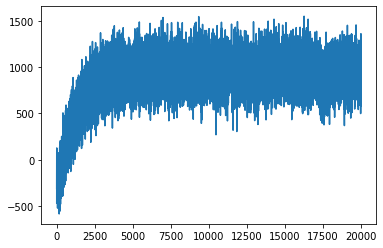

In [8]:
plt.plot(episodes,rewards_per_episode)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [9]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

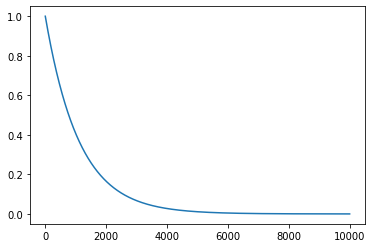

In [10]:
plt.plot(time, epsilon)
plt.show()

In [11]:
epsilon2=[]
for i in range(0,10000):
    if i==0:
        epsilon2.append(1)
    else:
        epsilon2.append(0.9991 * epsilon2[i-1])

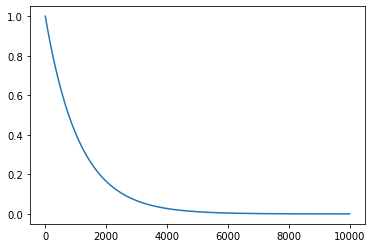

In [12]:
plt.plot(time, epsilon2)
plt.show()